# Generator
Build generator architecture with:
* Attention blocks
* Spectral Convolutions
* Upsampling and Downsampling layers
* Resnet blocks

In [ ]:
import tensorflow as tf

def attention_block(x, filters):
    """Self-attention mechanism to capture long-range dependencies"""
    batch_size = tf.shape(x)[0]
    height = tf.shape(x)[1]
    width = tf.shape(x)[2]
    
    # Change reshape operations to use tf.shape for dynamic batch size
    f = tf.keras.layers.Conv2D(filters // 8, 1)(x)
    g = tf.keras.layers.Conv2D(filters // 8, 1)(x)
    h = tf.keras.layers.Conv2D(filters, 1)(x)
    
    # Reshape using tf.reshape with properly specified dimensions
    f = tf.reshape(f, [batch_size, height * width, filters // 8])
    g = tf.reshape(g, [batch_size, height * width, filters // 8])
    h = tf.reshape(h, [batch_size, height * width, filters])
    
    # Compute attention map
    s = tf.matmul(f, g, transpose_b=True)
    beta = tf.nn.softmax(s)
    
    o = tf.matmul(beta, h)
    o = tf.reshape(o, [batch_size, height, width, filters])
    
    # Gamma as learnable parameter (can be initialized to 0)
    gamma = tf.Variable(0.0, trainable=True)
    return x + gamma * o

def spectral_conv2d(filters, kernel_size, strides=1):
    return tf.keras.layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        padding='same',
        kernel_initializer='orthogonal',
        use_bias=False
    )

def downsample(filters, size, apply_batchnorm=True):
    result = tf.keras.Sequential()
    result.add(spectral_conv2d(filters, size, strides=2))
    
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    
    result.add(tf.keras.layers.PReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(
            filters, size, strides=2,
            padding='same',
            kernel_initializer='orthogonal',
            use_bias=False
        )
    )
    
    result.add(tf.keras.layers.LayerNormalization())
    
    if apply_dropout:
        result.add(tf.keras.layers.SpatialDropout2D(0.5))
    
    result.add(tf.keras.layers.PReLU())
    return result

def resnet_block(input_tensor, filters, kernel_size=3):
    def squeeze_excite_block(input_tensor, ratio=16):
        channels = input_tensor.shape[-1]
        
        se = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
        se = tf.keras.layers.Reshape((1, 1, channels))(se)
        se = tf.keras.layers.Dense(channels // ratio, activation='relu')(se)
        se = tf.keras.layers.Dense(channels, activation='sigmoid')(se)
        
        return tf.keras.layers.Multiply()([input_tensor, se])
    
    x = spectral_conv2d(filters, kernel_size)(input_tensor)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    
    x = spectral_conv2d(filters, kernel_size)(x)
    x = tf.keras.layers.LayerNormalization()(x)
    
    x = squeeze_excite_block(x)
    x = tf.keras.layers.Add()([x, input_tensor])
    x = tf.keras.layers.PReLU()(x)
    
    return x

def build_generator(input_shape=(64, 64, 3)):
    # Input: 64x64
    tf.keras.backend.set_floatx('float32')
    inputs = tf.keras.layers.Input(shape=input_shape)

    
    # Initial convolution: 64x64 -> 64x64
    x = spectral_conv2d(32, 7)(inputs)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    
    # Downsampling path
    down_stack = [
        downsample(64, 3, apply_batchnorm=False),   # 64x64 -> 32x32
        downsample(128, 3),                         # 32x32 -> 16x16
        downsample(256, 3),                         # 16x16 -> 8x8
    ]
    
    # Using more ResNet blocks since we have a smaller architecture
    num_res_blocks = 9 # Increased from 6
    
    # Upsampling path
    up_stack = [
        upsample(128, 3, apply_dropout=True),       # 8x8 -> 16x16
        upsample(64, 3),                           # 16x16 -> 32x32
        upsample(32, 3),                           # 32x32 -> 64x64
    ]

    OUTPUT_CHANNELS = 3
    # Final output layer: 64x64 -> 128x128
    last = tf.keras.layers.Conv2DTranspose(
        OUTPUT_CHANNELS, 4,
        strides=2,
        padding='same',
        kernel_initializer='orthogonal',
        activation='tanh'
    )
    
    # Encoder
    x = inputs  # 64x64
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    # Print shapes for verification
    print(f"Bottleneck shape before ResNet blocks: {x.shape}")  # Should be (None, 8, 8, 256)
    
    # ResNet blocks at 8x8 resolution
    for _ in range(num_res_blocks):
        x = resnet_block(x, filters=256)  # Reduced from 512 due to smaller size
        if _ % 2 == 0:
            x = attention_block(x, filters=256)
    
    # Decoder
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = attention_block(x, x.shape[-1])
        x = tf.keras.layers.Concatenate()([x, skip])
    
    # Final output: 64x64 -> 128x128
    outputs = last(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [2]:
generator = build_generator()
generator.summary()

2024-11-17 19:00:15.060501: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-17 19:00:15.064765: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-17 19:00:15.064805: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-17 19:00:15.067290: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-17 19:00:15.067326: I tensorflow/compile

Bottleneck shape before ResNet blocks: (None, 8, 8, 256)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 32, 32, 64)           67264     ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 16, 16, 128)          107008    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 8, 8, 256)            312320    ['sequential_1[0][0]']        
                                     

# Discriminator
Build discriminator architecture:

In [3]:
# DISCRIMINATOR
import tensorflow as tf
import tensorflow_addons as tfa
    
from tensorflow.keras import layers
import numpy as np

def build_discriminator(input_shape=(64, 64, 3)):
    """
    Stabilized PatchGAN discriminator with spectral normalization and smooth activation
    """
    def conv_block(x, filters, kernel_size=4, strides=2):
        # Add spectral normalization
        x = tfa.layers.SpectralNormalization(
            layers.Conv2D(filters, kernel_size, strides, padding='same',
                         kernel_initializer='orthogonal', use_bias=False))(x)
        
        # Use GroupNormalization instead of BatchNorm/LayerNorm
        #x = tfa.layers.GroupNormalization(groups=8)(x) # Groupnorm as suggested
        x = layers.LayerNormalization()(x) # Layernorm could be more stable
        
        # Smoother activation function
        x = tf.nn.selu(x)  # Using SELU for self-normalizing properties
        return x

    inp = layers.Input(shape=input_shape, dtype=tf.float32, name='input_image')
    tar = layers.Input(shape=input_shape, dtype=tf.float32, name='target_image')
    
    # Add noise to inputs for smoothing
    noise_stddev = 0.01
    noised_inp = inp + tf.random.normal(tf.shape(inp), 0, noise_stddev)
    noised_tar = tar + tf.random.normal(tf.shape(tar), 0, noise_stddev)
    
    x = layers.Concatenate(axis=-1)([noised_inp, noised_tar])
    
    # Gradual filter increase
    x = conv_block(x, 32)          # (32x32x32)
    x = conv_block(x, 64)          # (16x16x64)
    x = conv_block(x, 128)         # (8x8x128)
    x = conv_block(x, 256)         # (4x4x256)
    
    # Final layer with smaller kernel and no activation
    output = layers.Conv2D(1, 1, 1, padding='same',
                          kernel_initializer='orthogonal',
                          activation='linear')(x)
    
    return tf.keras.Model(inputs=[inp, tar], outputs=output)

/home/megger/miniconda3/envs/pressure_predict/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
# DISCRIMINATOR
import tensorflow as tf
import tensorflow_addons as tfa
    
from tensorflow.keras import layers
import numpy as np

def build_discriminator(input_shape=(64, 64, 3)):
    """
    Stabilized PatchGAN discriminator with improved loss scaling
    """
    def conv_block(x, filters, kernel_size=4, strides=2, apply_norm=True):
        # Use smaller initialization for better stability
        x = tfa.layers.SpectralNormalization(
            layers.Conv2D(filters, kernel_size, strides, padding='same',
                         kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01),
                         use_bias=False))(x)
        
        if apply_norm:
            x = tfa.layers.InstanceNormalization()(x)
        
        x = layers.LeakyReLU(alpha=0.2)(x)
        return x

    inp = layers.Input(shape=input_shape, dtype=tf.float32, name='input_image')
    tar = layers.Input(shape=input_shape, dtype=tf.float32, name='target_image')
    
    # Reduced noise scale
    noise_scale = tf.Variable(0.001, trainable=True)
    noise = tf.random.normal(tf.shape(inp)) * noise_scale
    x = layers.Concatenate(axis=-1)([inp + noise, tar + noise])
    
    # More gradual filter progression
    x = conv_block(x, 32, strides=2)        # 32x32
    x = conv_block(x, 64, strides=2)        # 16x16
    x = conv_block(x, 128, strides=2)       # 8x8
    x = conv_block(x, 256, strides=1)       # 8x8
    
    # Final layer with smaller kernel
    x = layers.Conv2D(1, 3, strides=1, padding='same',
                     kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
    
    return tf.keras.Model(inputs=[inp, tar], outputs=x)

In [5]:
discriminator = build_discriminator()
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 tf.compat.v1.shape_15 (TFO  (4,)                         0         ['input_image[0][0]']         
 pLambda)                                                                                         
                                                                                                  
 tf.random.normal (TFOpLamb  (None, 64, 64, 3)            0         ['tf.compat.v1.shape_15[0][0]'
 da)                                                                ]                             
                                                                                            

# Loss function class
An object with physics-informed loss for the generator and discriminator

In [6]:
import tensorflow as tf

class FluidGANLoss:
    def __init__(self, discriminator, lambda_gp=10.0, lambda_physics=1.0):
        self.discriminator = discriminator
        self.lambda_gp = lambda_gp
        self.lambda_physics = lambda_physics
        # Add adaptive weights
        self.adversarial_weight = tf.Variable(1.0, trainable=False)
        self.running_gen_loss = tf.Variable(0.0, trainable=False)
        self.running_disc_loss = tf.Variable(0.0, trainable=False)
        self.beta = 0.99  # For running average
        
    def generator_loss(self, disc_generated_output, y_true, y_pred):
        # Use least squares GAN loss instead of relativistic
        # This tends to be more stable for fluid dynamics
        adversarial_loss = tf.reduce_mean(tf.square(disc_generated_output - 1.0))
        
        # Enhanced L1 loss with focus on high-gradient regions
        base_l1 = tf.abs(y_true - y_pred)
        grad_weights = tf.reduce_mean(tf.image.sobel_edges(y_true), axis=-1)
        grad_weights = tf.nn.softmax(grad_weights * 10.0)  # Temperature scaling
        weighted_l1 = base_l1 * (1.0 + grad_weights)
        l1_loss = tf.reduce_mean(weighted_l1)
        
        # Gradient matching with different scales
        grad_loss = 0.0
        scales = [1, 2]
        for scale in scales:
            if scale > 1:
                y_true_scaled = tf.nn.avg_pool2d(y_true, scale, scale, 'VALID')
                y_pred_scaled = tf.nn.avg_pool2d(y_pred, scale, scale, 'VALID')
            else:
                y_true_scaled = y_true
                y_pred_scaled = y_pred
                
            true_grads = tf.image.sobel_edges(y_true_scaled)
            pred_grads = tf.image.sobel_edges(y_pred_scaled)
            grad_loss += tf.reduce_mean(tf.abs(true_grads - pred_grads))
        
        # Physics loss with adaptive weight
        physics_loss = self.physics_consistency_loss(y_pred)
        physics_weight = tf.minimum(1.0, tf.cast(self.running_gen_loss, tf.float32) / 2.0)
        
        # Dynamically adjust weights based on running losses
        l1_weight = 50.0  # Reduced from 100.0
        grad_weight = 10.0  # Reduced from 25.0
        
        total_loss = (
            self.adversarial_weight * adversarial_loss + 
            l1_weight * l1_loss +
            grad_weight * grad_loss + 
            physics_weight * self.lambda_physics * physics_loss
        )
        
        # Update running average of generator loss
        self.running_gen_loss.assign(
            self.beta * self.running_gen_loss + (1 - self.beta) * total_loss
        )
        
        return {
            'total_loss': total_loss,
            'adversarial_loss': adversarial_loss,
            'l1_loss': l1_loss,
            'grad_loss': grad_loss,
            'physics_loss': physics_loss,
            'physics_weight': physics_weight
        }
    
    def discriminator_loss(self, disc_real_output, disc_generated_output, 
                          real_images, generated_images, batch_size):
        # Use least squares GAN loss for discriminator
        real_loss = tf.reduce_mean(tf.square(disc_real_output - 1.0))
        fake_loss = tf.reduce_mean(tf.square(disc_generated_output))
        
        # Calculate gradient penalty with adaptive weight
        gp = self.gradient_penalty(real_images, generated_images, batch_size)
        gp_weight = tf.minimum(10.0, 2.0 * tf.cast(self.running_disc_loss, tf.float32))
        
        total_loss = real_loss + fake_loss + gp_weight * gp
        
        # Update running average of discriminator loss
        self.running_disc_loss.assign(
            self.beta * self.running_disc_loss + (1 - self.beta) * total_loss
        )
        
        # Adjust adversarial weight for generator based on discriminator performance
        disc_ratio = real_loss / (fake_loss + 1e-6)
        self.adversarial_weight.assign(
            tf.clip_by_value(self.adversarial_weight * tf.sqrt(disc_ratio), 0.5, 2.0)
        )
        
        return {
            'total_loss': total_loss,
            'real_loss': real_loss,
            'fake_loss': fake_loss,
            'gradient_penalty': gp,
            'gp_weight': gp_weight
        }
    
    def physics_consistency_loss(self, y_pred):
        """Physics-based loss focusing on fluid dynamics constraints"""
        # Calculate velocity gradients using central differences
        dx = (y_pred[:, 2:, 1:-1, :] - y_pred[:, :-2, 1:-1, :]) / 2.0
        dy = (y_pred[:, 1:-1, 2:, :] - y_pred[:, 1:-1, :-2, :]) / 2.0
        
        # Divergence-free constraint
        divergence = dx + dy
        divergence_loss = tf.reduce_mean(tf.square(divergence))
        
        # Add smoothness constraint for better stability
        smoothness_loss = tf.reduce_mean(tf.square(dx)) + tf.reduce_mean(tf.square(dy))
        
        # Boundary conditions
        boundary_loss = tf.reduce_mean(tf.square(y_pred[:, 0, :, :]) + 
                                     tf.square(y_pred[:, -1, :, :]) +
                                     tf.square(y_pred[:, :, 0, :]) + 
                                     tf.square(y_pred[:, :, -1, :]))
        
        return divergence_loss + 0.1 * smoothness_loss + 0.05 * boundary_loss
    
    def gradient_penalty(self, real_images, fake_images, batch_size):
        """Calculate gradient penalty with improved interpolation"""
        # Use random interpolation points
        alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff
        
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            disc_interpolated = self.discriminator([interpolated, real_images], 
                                                 training=True)
        
        gradients = tape.gradient(disc_interpolated, interpolated)
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]) + 1e-8)
        return tf.reduce_mean(tf.square(slopes - 1.0))

# Training setup
An object containing all the necessary capabilities to train the model and preview progress

In [7]:
import matplotlib.pyplot as plt

def generate_images(model, test_input, tar):
    """ Generates and displays a comparison between input image, 
    ground truth and predicted image from a model.
    """
    prediction = model(test_input, training=True)
    plt.figure(figsize=(10, 10))
    value_range = .05

    display_list = [
        test_input[0][:,:,0], tar[0][:,:,0], prediction[0][:,:,0],
        test_input[0][:,:,1], tar[0][:,:,1], prediction[0][:,:,1],
        test_input[0][:,:,2], tar[0][:,:,2], prediction[0][:,:,2] 
    ]
    maintitle = ['Input Image', 'Ground Truth', 'Predicted Image']
    title = ['vel.x', 'vel.y', 'pressure']

    for i in range(9):
        plt_idx = i
        plt.subplot(3, 3, i+1)
        
        try: header = f"----- {maintitle[i]} -----"
        except: header = ""
        plt.title(f"{header}\n\n{title[i//3]}", fontsize=11)
        
        # Getting the pixel values in the [0, 1] range to plot.
        a, b = 0.5, 0.1
        tile = display_list[i]
        # if (i-2)%3 == 0:
        #     # Blur prediction with gaussian sigma
        #     BLUR_SIGMA = 0.35
        #     tile = scipy.ndimage.gaussian_filter(tile, BLUR_SIGMA)
        plt.imshow(tile, vmin=-value_range, vmax=value_range)
        plt.axis('off')
    plt.show()

In [ ]:
import tensorflow as tf

class DataAugmentor:
    def __init__(self, min_size=48, max_size=96, rotation_range=15):
        self.min_size = min_size
        self.max_size = max_size
        self.rotation_range = rotation_range
    
    @tf.function
    def augment(self, input_image, target_image):
        """Apply consistent augmentations to both input and target"""
        # Generate random parameters once to apply same transformation to both
        do_flip_lr = tf.random.uniform([]) > 0.5
        do_flip_ud = tf.random.uniform([]) > 0.5
        angle = tf.random.uniform([], -self.rotation_range, self.rotation_range) * np.pi / 180
        height = tf.random.uniform([], self.min_size, self.max_size, dtype=tf.int32)
        width = tf.random.uniform([], self.min_size, self.max_size, dtype=tf.int32)
        
        # Apply same transformations to both images
        for image in [input_image, target_image]:
            if do_flip_lr:
                image = tf.image.flip_left_right(image)
            if do_flip_ud:
                image = tf.image.flip_up_down(image)
            image = tf.image.rotate(image, angle)
            image = tf.image.resize(image, [height, width])
            image = tf.image.resize(image, [64, 64])  # Final consistent size
        
        return input_image, target_image

In [28]:
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import datetime
import numpy as np

class FluidGANTrainer:
    def __init__(
        self,
        generator,
        discriminator,
        train_dataset,
        test_dataset,
        checkpoint_dir='./training_checkpoints',
        preview_interval=10,
        checkpoint_interval=50,
        validation_interval=5,
        samples_per_epoch=2000,  # New parameter for controlling epoch size
        log_rate=100
    ):
        self.generator = generator
        self.discriminator = discriminator
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.checkpoint_dir = checkpoint_dir
        self.preview_interval = preview_interval
        self.checkpoint_interval = checkpoint_interval
        self.validation_interval = validation_interval
        self.samples_per_epoch = samples_per_epoch
        self.log_rate = log_rate
                
        # Add learning rate scheduling
        initial_lr_gen = 2e-4
        initial_lr_disc = 5e-5
        self.generator_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_lr_gen, decay_steps=2000, decay_rate=0.98, staircase=True)
        self.discriminator_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_lr_disc, decay_steps=2000, decay_rate=0.98, staircase=True)
        
        # Initialize optimizers
        self.generator_optimizer = tf.keras.optimizers.Adam(
            self.generator_scheduler, beta_1=0.5, beta_2=0.9)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(
            self.discriminator_scheduler, beta_1=0.0, beta_2=0.9, epsilon=1e-8)
        
        # Initialize loss function
        self.loss_fn = FluidGANLoss(discriminator=self.discriminator, lambda_gp=10.0, lambda_physics=0.0)
        
        # Setup checkpointing
        self.checkpoint = tf.train.Checkpoint(
            generator_optimizer=self.generator_optimizer,
            discriminator_optimizer=self.discriminator_optimizer,
            generator=self.generator,
            discriminator=self.discriminator
        )
        self.checkpoint_manager = tf.train.CheckpointManager(
            self.checkpoint, self.checkpoint_dir, max_to_keep=10
        )
        
        # Setup logging
        current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        self.log_dir = f'logs/{current_time}'
        self.summary_writer = tf.summary.create_file_writer(self.log_dir)

    def create_epoch_dataset(self, full_dataset, num_samples, batch_size=1):
        """Create a smaller dataset for one epoch by sampling randomly"""
        # Convert dataset to numpy for easier sampling
        
        inputs, targets = [], []
        for x, y in full_dataset:
            inputs.append(x)
            targets.append(y)
        inputs = np.concatenate(inputs, axis=0)
        targets = np.concatenate(targets, axis=0)
        
        # Randomly sample indices
        total_samples = inputs.shape[0]
        indices = np.random.choice(total_samples, num_samples, replace=False)
        
        # Create new dataset from sampled data
        sampled_inputs = inputs[indices]
        sampled_targets = targets[indices]
        
        # Create TF dataset
        dataset = tf.data.Dataset.from_tensor_slices((sampled_inputs, sampled_targets))
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        
        return dataset

    @tf.function
    def train_step(self, input_image, target_image):
        """Single training step"""
        batch_size = tf.shape(input_image)[0]
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Generator forward pass
            gen_output = self.generator(input_image, training=True)
            
            # Discriminator forward passes
            disc_real_output = self.discriminator([input_image, target_image], training=True)
            disc_generated_output = self.discriminator([input_image, gen_output], training=True)
            
            # Calculate losses
            gen_losses = self.loss_fn.generator_loss(
                disc_generated_output, target_image, gen_output
            )
            disc_losses = self.loss_fn.discriminator_loss(
                disc_real_output, disc_generated_output,
                target_image, gen_output, batch_size
            )
        
        # Calculate gradients
        generator_gradients = gen_tape.gradient(
            gen_losses['total_loss'],
            self.generator.trainable_variables
        )
        discriminator_gradients = disc_tape.gradient(
            disc_losses['total_loss'],
            self.discriminator.trainable_variables
        )
        
        # Apply gradient clipping
        generator_gradients = [tf.clip_by_norm(g, 1.0) for g in generator_gradients]
        discriminator_gradients = [tf.clip_by_norm(g, 1.0) for g in discriminator_gradients]
        
        # Apply gradients
        self.generator_optimizer.apply_gradients(
            zip(generator_gradients, self.generator.trainable_variables)
        )
        self.discriminator_optimizer.apply_gradients(
            zip(discriminator_gradients, self.discriminator.trainable_variables)
        )
        
        return gen_losses, disc_losses

    
    @tf.function
    def validation_step(self, input_image, target_image):
        """Single validation step without gradient updates"""
        batch_size = tf.shape(input_image)[0]
        
        # Generator forward pass
        gen_output = self.generator(input_image, training=False)
        
        # Discriminator forward passes
        disc_real_output = self.discriminator([input_image, target_image], training=False)
        disc_generated_output = self.discriminator([input_image, gen_output], training=False)
        
        # Calculate losses
        gen_losses = self.loss_fn.generator_loss(
            disc_generated_output, target_image, gen_output
        )
        disc_losses = self.loss_fn.discriminator_loss(
            disc_real_output, disc_generated_output,
            target_image, gen_output, batch_size
        )
        
        return gen_losses, disc_losses

    def validate_model(self):
        """Run validation on the test dataset"""
        total_gen_loss = 0
        total_disc_loss = 0
        num_batches = 0
        
        for input_image, target_image in self.test_dataset:
            gen_losses, disc_losses = self.validation_step(input_image, target_image)
            total_gen_loss += gen_losses['total_loss']
            total_disc_loss += disc_losses['total_loss']
            num_batches += 1
        
        avg_gen_loss = total_gen_loss / num_batches
        avg_disc_loss = total_disc_loss / num_batches
        
        return {
            'generator_loss': avg_gen_loss,
            'discriminator_loss': avg_disc_loss
        }

    def train(self, epochs, batch_size=1):
        """Main training loop with epoch sampling"""
        start = time.time()
        
        # Try to restore latest checkpoint
        if self.checkpoint_manager.latest_checkpoint:
            self.checkpoint.restore(self.checkpoint_manager.latest_checkpoint)
            print(f'Latest checkpoint restored from {self.checkpoint_manager.latest_checkpoint}')
        
        # Get a test batch for previewing results
        test_input, test_target = next(iter(self.test_dataset))
        
        for epoch in range(epochs):
            start_time = time.time()
            
            # Create a new sampled dataset for this epoch
            epoch_dataset = self.create_epoch_dataset(
                self.train_dataset, 
                self.samples_per_epoch, 
                batch_size
            )
            
            # Train on batches
            for batch_idx, (input_image, target_image) in enumerate(epoch_dataset):
                gen_losses, disc_losses = self.train_step(input_image, target_image)
                
                # Log every @log_rate batches
                if batch_idx % self.log_rate == 0:
                    print(f'Epoch {epoch+1}, Batch {batch_idx}:')
                    gen_lr = self.generator_scheduler(self.generator_optimizer.iterations)
                    disc_lr = self.discriminator_scheduler(self.discriminator_optimizer.iterations)
                    print(f'Generator Loss: {gen_losses["total_loss"]:.4f},  LR: {gen_lr:.2e}')
                    print(f'Discriminator Loss: {disc_losses["total_loss"]:.4f},  LR: {disc_lr:.2e}')
                    
                    # Log to TensorBoard
                    with self.summary_writer.as_default():
                        step = epoch * (self.samples_per_epoch // batch_size) + batch_idx
                        tf.summary.scalar('train/gen_total_loss', gen_losses['total_loss'], step=step)
                        tf.summary.scalar('train/gen_adversarial_loss', gen_losses['adversarial_loss'], step=step)
                        tf.summary.scalar('train/l1_loss', gen_losses['l1_loss'], step=step)
                        tf.summary.scalar('train/gen_physics_loss', gen_losses['physics_loss'], step=step)
                        tf.summary.scalar('train/disc_total_loss', disc_losses['total_loss'], step=step)

                        
            # Run validation
            if (epoch + 1) % self.validation_interval == 0:
                val_losses = self.validate_model()
                print(f'Validation Losses:')
                print(f'Generator Loss: {val_losses["generator_loss"]:.4f}')
                print(f'Discriminator Loss: {val_losses["discriminator_loss"]:.4f}')
                
                # Log validation metrics
                with self.summary_writer.as_default():
                    tf.summary.scalar('validation/gen_loss', val_losses['generator_loss'], step=(epoch + 1))
                    tf.summary.scalar('validation/disc_loss', val_losses['discriminator_loss'], step=(epoch + 1))
            
            # Preview images
            if (epoch + 1) % self.preview_interval == 0:
                generate_images(self.generator, test_input, test_target)
            
            # Save checkpoint
            if (epoch + 1) % self.checkpoint_interval == 0:
                self.checkpoint_manager.save()
                print(f'Checkpoint saved for epoch {epoch+1}')
            
            print(f'Epoch {epoch+1} took {time.time()-start_time:.2f} seconds')
        
        print(f'Training took {time.time()-start} seconds')

# Ingest Data, build datasets, run training
Load concatenated data output by "pressure_predict_1_data_prep"

In [29]:
import numpy as np
import time

start_time = time.perf_counter()
combined_data_path = "./data2D/loaded_data_v2_rand.npz"
with np.load(combined_data_path) as data:
    X_train = data["X_train"]
    Y_train = data["Y_train"]
    X_test  = data["X_test"]
    Y_test  = data["Y_test"]

end_time = time.perf_counter()
print(f"Loaded combined array in {end_time - start_time:.2f} seconds.")
print("Loaded X shape: ", np.array(X_train).shape, np.array(X_test).shape)
print("Loaded Y shape: ", np.array(Y_train).shape, np.array(Y_test).shape)

# Normally returns:
# Loaded X shape:  (5000, 64, 64, 3) (1000, 64, 64, 3)
# Loaded Y shape:  (5000, 64, 64, 3) (1000, 64, 64, 3)

Loaded combined array in 7.37 seconds.
Loaded X shape:  (5000, 64, 64, 3) (1000, 64, 64, 3)
Loaded Y shape:  (5000, 64, 64, 3) (1000, 64, 64, 3)


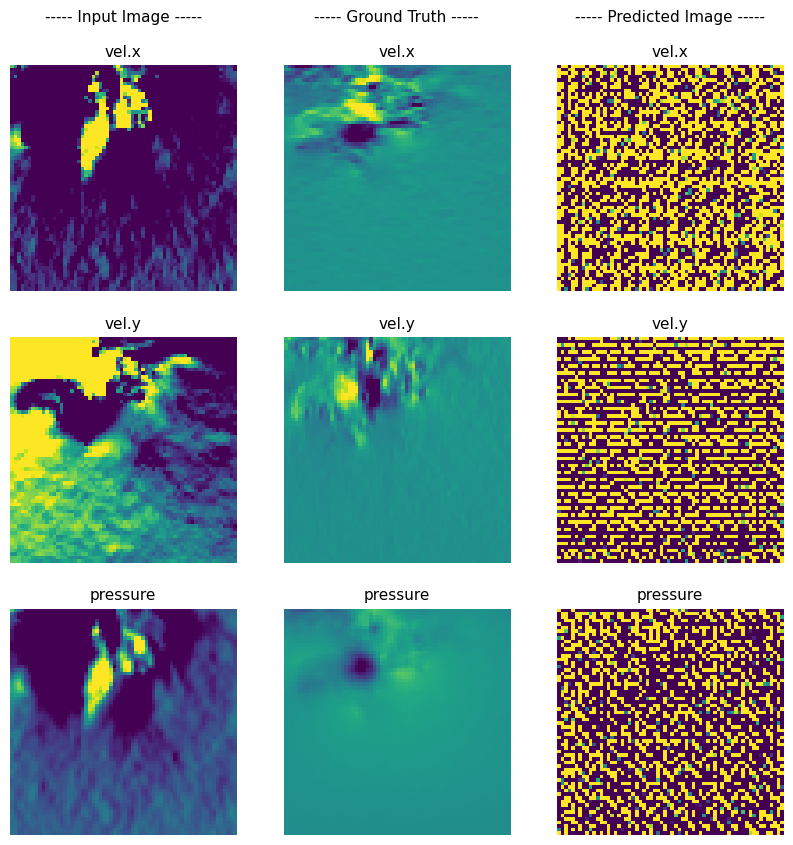

In [30]:
# Test untrained generator and preview.
prev_idx = 10
generate_images(generator, X_train[prev_idx][tf.newaxis, ...], Y_train[prev_idx][tf.newaxis, ...])

In [31]:
# APPLY BATCHING (with 1)
# ... and achieve output dimensionality of:     [2,     n, 64, 64, 3] 
# ... with desired iteration dimensionality of:     [None, 64, 64, 3]
import tensorflow as tf

X_train = tf.cast(X_train, tf.float32)
Y_train = tf.cast(Y_train, tf.float32)
X_test = tf.cast(X_test, tf.float32)
Y_test = tf.cast(Y_test, tf.float32)

# Normalize data to [-1, 1] range if not already done
# def normalize(x):
#     return tf.clip_by_value(x, -1, 1)

# X_train, Y_train = normalize(X_train), normalize(Y_train)
# X_test, Y_test = normalize(X_test), normalize(Y_test)

# Create datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_ds = train_ds.shuffle(5000).batch(5)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_ds = test_ds.shuffle(1000).batch(5)


In [32]:
import random
log_dir = "./logs"

%load_ext tensorboard
%reload_ext tensorboard
random_port = random.randrange(1001,9900)
print(f"Loading tensorboard on port: {random_port}")
%tensorboard --logdir={log_dir} --reload_multifile=true --port={random_port} --host localhost

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Loading tensorboard on port: 4279


Bottleneck shape before ResNet blocks: (None, 8, 8, 256)
Latest checkpoint restored from ./training_checkpointsF/ckpt-40


2024-11-18 01:18:25.337546: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/model_12/sequential_39/spatial_dropout2d_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 1, Batch 0:
Generator Loss: 1.3944,  LR: 5.95e-05
Discriminator Loss: 0.1275,  LR: 1.49e-05
Epoch 1, Batch 200:
Generator Loss: 1.1125,  LR: 5.95e-05
Discriminator Loss: 0.0330,  LR: 1.49e-05
Epoch 1, Batch 400:
Generator Loss: 0.9778,  LR: 5.95e-05
Discriminator Loss: 0.0933,  LR: 1.49e-05
Epoch 1, Batch 600:
Generator Loss: 1.2385,  LR: 5.95e-05
Discriminator Loss: 0.0701,  LR: 1.49e-05
Epoch 1 took 106.69 seconds
Epoch 2, Batch 0:
Generator Loss: 1.0262,  LR: 5.95e-05
Discriminator Loss: 0.1879,  LR: 1.49e-05
Epoch 2, Batch 200:
Generator Loss: 2.0815,  LR: 5.95e-05
Discriminator Loss: 0.0300,  LR: 1.49e-05
Epoch 2, Batch 400:
Generator Loss: 2.0887,  LR: 5.95e-05
Discriminator Loss: 0.0716,  LR: 1.49e-05
Epoch 2, Batch 600:
Generator Loss: 1.4755,  LR: 5.95e-05
Discriminator Loss: 0.1686,  LR: 1.49e-05
Epoch 2 took 87.27 seconds
Epoch 3, Batch 0:
Generator Loss: 1.7517,  LR: 5.95e-05
Discriminator Loss: 0.1010,  LR: 1.49e-05
Epoch 3, Batch 200:
Generator Loss: 1.4649,  LR: 5.

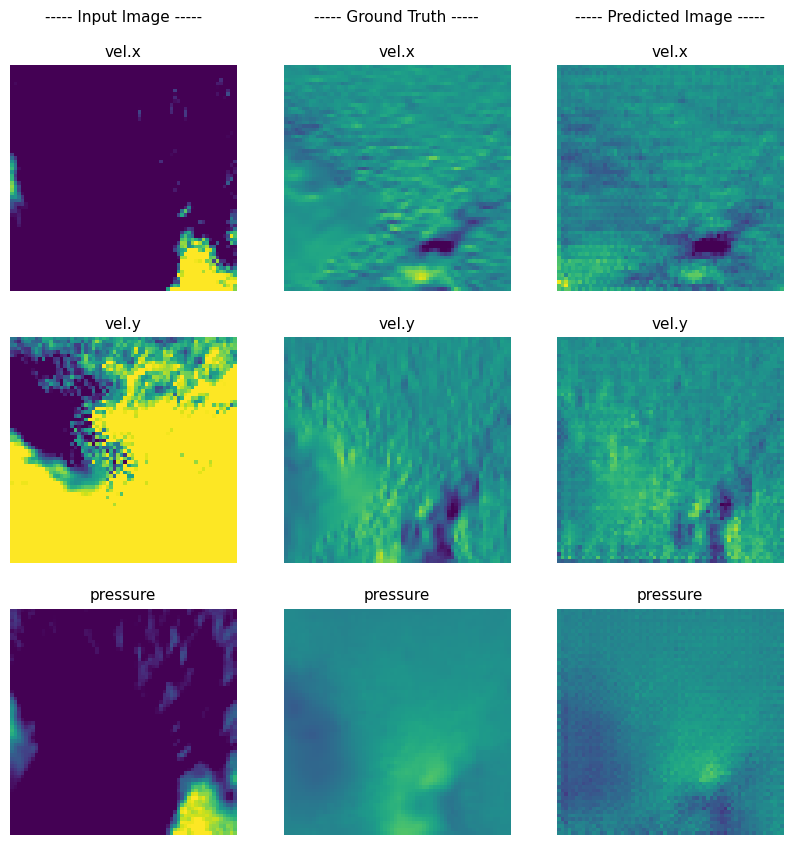

Epoch 5 took 86.83 seconds
Epoch 6, Batch 0:
Generator Loss: 1.1130,  LR: 5.72e-05
Discriminator Loss: 0.0994,  LR: 1.43e-05
Epoch 6, Batch 200:
Generator Loss: 1.5746,  LR: 5.72e-05
Discriminator Loss: 0.0651,  LR: 1.43e-05
Epoch 6, Batch 400:
Generator Loss: 2.1129,  LR: 5.72e-05
Discriminator Loss: 0.0403,  LR: 1.43e-05
Epoch 6, Batch 600:
Generator Loss: 1.1080,  LR: 5.72e-05
Discriminator Loss: 0.0469,  LR: 1.43e-05
Epoch 6 took 86.45 seconds
Epoch 7, Batch 0:
Generator Loss: 1.3011,  LR: 5.72e-05
Discriminator Loss: 0.0636,  LR: 1.43e-05
Epoch 7, Batch 200:
Generator Loss: 1.5018,  LR: 5.72e-05
Discriminator Loss: 0.1210,  LR: 1.43e-05
Epoch 7, Batch 400:
Generator Loss: 1.0963,  LR: 5.72e-05
Discriminator Loss: 0.1086,  LR: 1.43e-05
Epoch 7, Batch 600:
Generator Loss: 1.4563,  LR: 5.72e-05
Discriminator Loss: 0.0465,  LR: 1.43e-05
Epoch 7 took 86.24 seconds
Epoch 8, Batch 0:
Generator Loss: 1.4254,  LR: 5.72e-05
Discriminator Loss: 0.1168,  LR: 1.43e-05
Epoch 8, Batch 200:
Gener

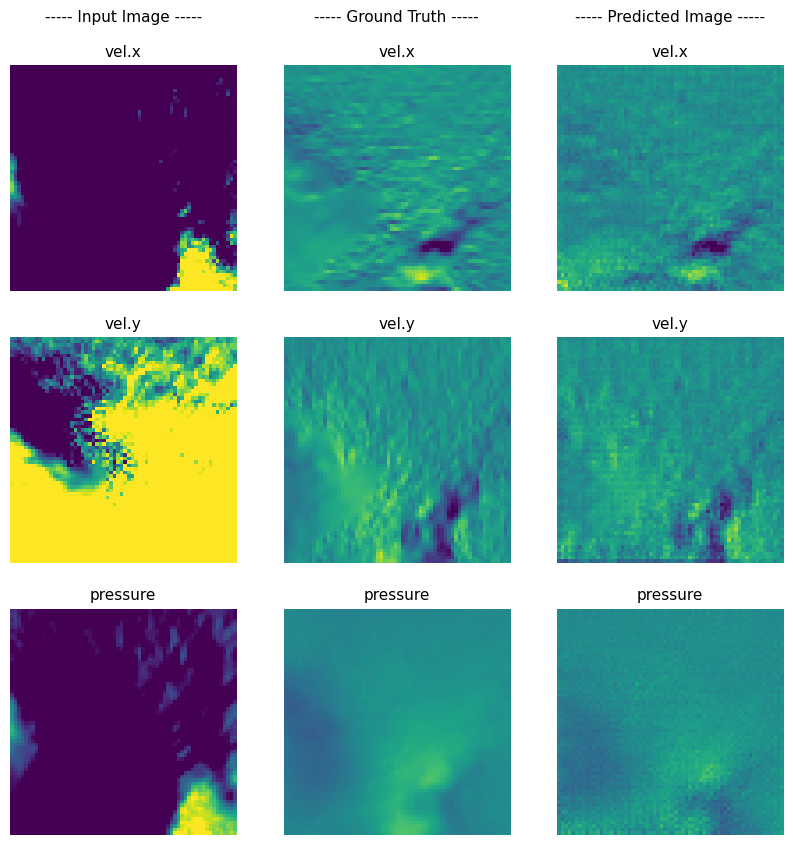

Epoch 10 took 93.68 seconds
Epoch 11, Batch 0:
Generator Loss: 2.0328,  LR: 5.49e-05
Discriminator Loss: 0.1907,  LR: 1.37e-05
Epoch 11, Batch 200:
Generator Loss: 1.2719,  LR: 5.49e-05
Discriminator Loss: 0.1103,  LR: 1.37e-05
Epoch 11, Batch 400:
Generator Loss: 1.0978,  LR: 5.49e-05
Discriminator Loss: 0.1139,  LR: 1.37e-05
Epoch 11, Batch 600:
Generator Loss: 1.7029,  LR: 5.49e-05
Discriminator Loss: 0.0494,  LR: 1.37e-05
Epoch 11 took 86.42 seconds
Epoch 12, Batch 0:
Generator Loss: 1.1030,  LR: 5.49e-05
Discriminator Loss: 0.0606,  LR: 1.37e-05
Epoch 12, Batch 200:
Generator Loss: 1.5276,  LR: 5.49e-05
Discriminator Loss: 0.0236,  LR: 1.37e-05
Epoch 12, Batch 400:
Generator Loss: 1.7816,  LR: 5.49e-05
Discriminator Loss: 0.1647,  LR: 1.37e-05
Epoch 12, Batch 600:
Generator Loss: 0.9962,  LR: 5.49e-05
Discriminator Loss: 0.0818,  LR: 1.37e-05
Epoch 12 took 86.28 seconds
Epoch 13, Batch 0:
Generator Loss: 1.2423,  LR: 5.49e-05
Discriminator Loss: 0.1218,  LR: 1.37e-05
Epoch 13, Bat

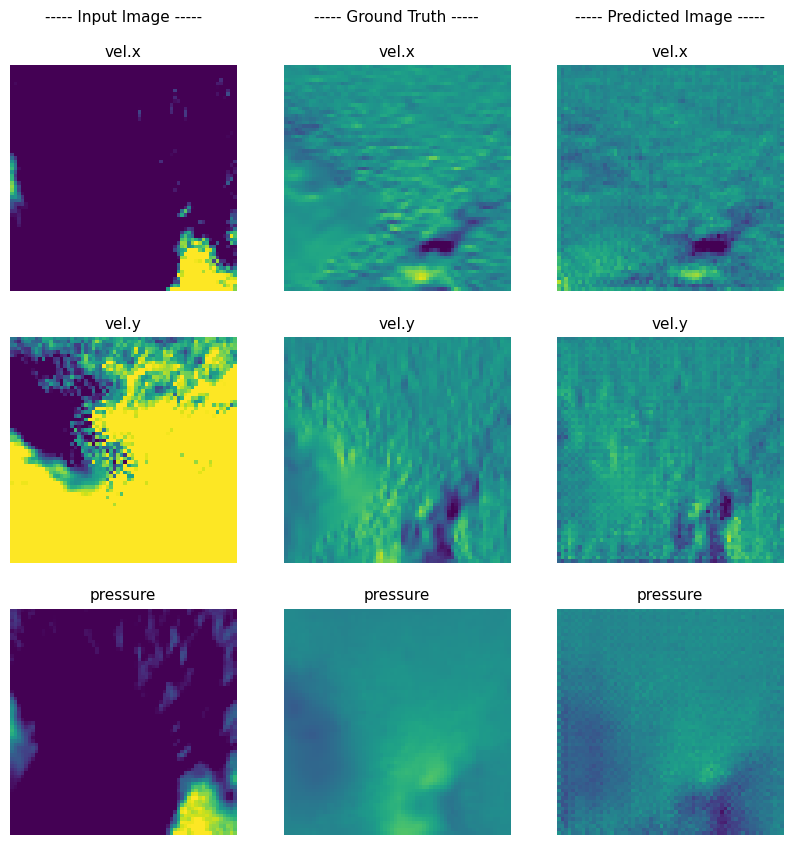

Epoch 15 took 86.63 seconds
Epoch 16, Batch 0:
Generator Loss: 1.6544,  LR: 5.27e-05
Discriminator Loss: 0.1114,  LR: 1.32e-05
Epoch 16, Batch 200:
Generator Loss: 1.0920,  LR: 5.27e-05
Discriminator Loss: 0.0886,  LR: 1.32e-05
Epoch 16, Batch 400:
Generator Loss: 1.0670,  LR: 5.27e-05
Discriminator Loss: 0.0864,  LR: 1.32e-05
Epoch 16, Batch 600:
Generator Loss: 2.3316,  LR: 5.27e-05
Discriminator Loss: 0.0721,  LR: 1.32e-05
Epoch 16 took 86.53 seconds
Epoch 17, Batch 0:
Generator Loss: 1.3307,  LR: 5.27e-05
Discriminator Loss: 0.2206,  LR: 1.32e-05
Epoch 17, Batch 200:
Generator Loss: 1.2375,  LR: 5.27e-05
Discriminator Loss: 0.0493,  LR: 1.32e-05
Epoch 17, Batch 400:
Generator Loss: 1.3327,  LR: 5.27e-05
Discriminator Loss: 0.1033,  LR: 1.32e-05
Epoch 17, Batch 600:
Generator Loss: 1.1875,  LR: 5.27e-05
Discriminator Loss: 0.1142,  LR: 1.32e-05
Epoch 17 took 86.28 seconds
Epoch 18, Batch 0:
Generator Loss: 1.1461,  LR: 5.27e-05
Discriminator Loss: 0.1208,  LR: 1.32e-05
Epoch 18, Bat

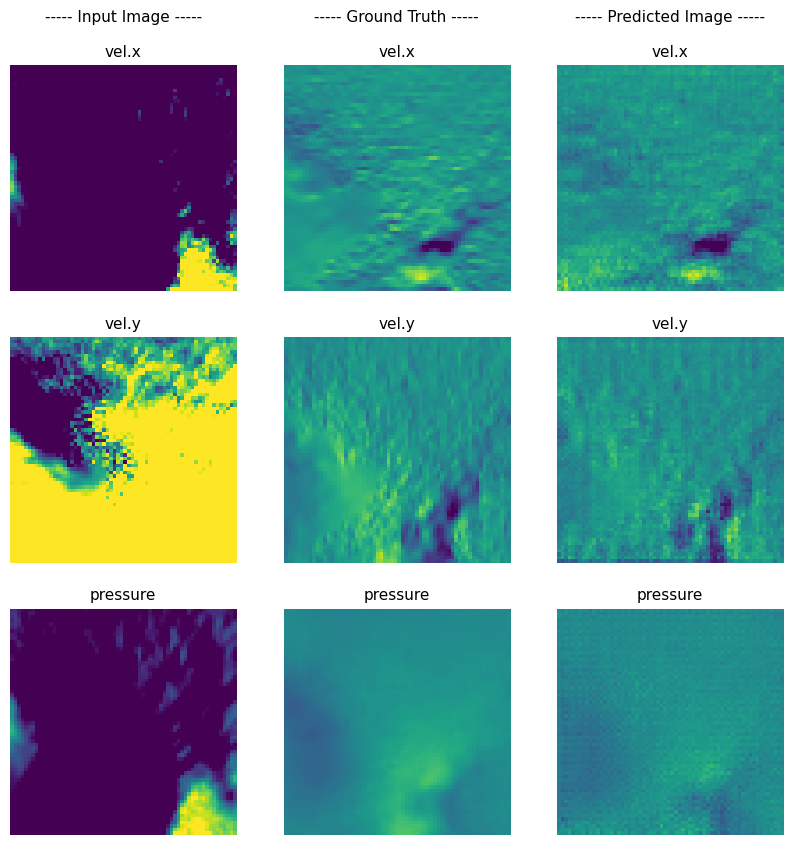

Checkpoint saved for epoch 20
Epoch 20 took 93.37 seconds
Epoch 21, Batch 0:
Generator Loss: 2.3607,  LR: 5.06e-05
Discriminator Loss: 0.0775,  LR: 1.27e-05
Epoch 21, Batch 200:
Generator Loss: 1.2104,  LR: 5.06e-05
Discriminator Loss: 0.0923,  LR: 1.27e-05
Epoch 21, Batch 400:
Generator Loss: 1.5164,  LR: 5.06e-05
Discriminator Loss: 0.1908,  LR: 1.27e-05
Epoch 21, Batch 600:
Generator Loss: 1.0489,  LR: 5.06e-05
Discriminator Loss: 0.1074,  LR: 1.27e-05
Epoch 21 took 86.63 seconds
Epoch 22, Batch 0:
Generator Loss: 0.9788,  LR: 5.06e-05
Discriminator Loss: 0.0590,  LR: 1.27e-05
Epoch 22, Batch 200:
Generator Loss: 1.1369,  LR: 5.06e-05
Discriminator Loss: 0.0720,  LR: 1.27e-05
Epoch 22, Batch 400:
Generator Loss: 0.8910,  LR: 5.06e-05
Discriminator Loss: 0.1608,  LR: 1.27e-05
Epoch 22, Batch 600:
Generator Loss: 1.3595,  LR: 5.06e-05
Discriminator Loss: 0.0727,  LR: 1.27e-05
Epoch 22 took 86.49 seconds
Epoch 23, Batch 0:
Generator Loss: 1.0519,  LR: 5.06e-05
Discriminator Loss: 0.066

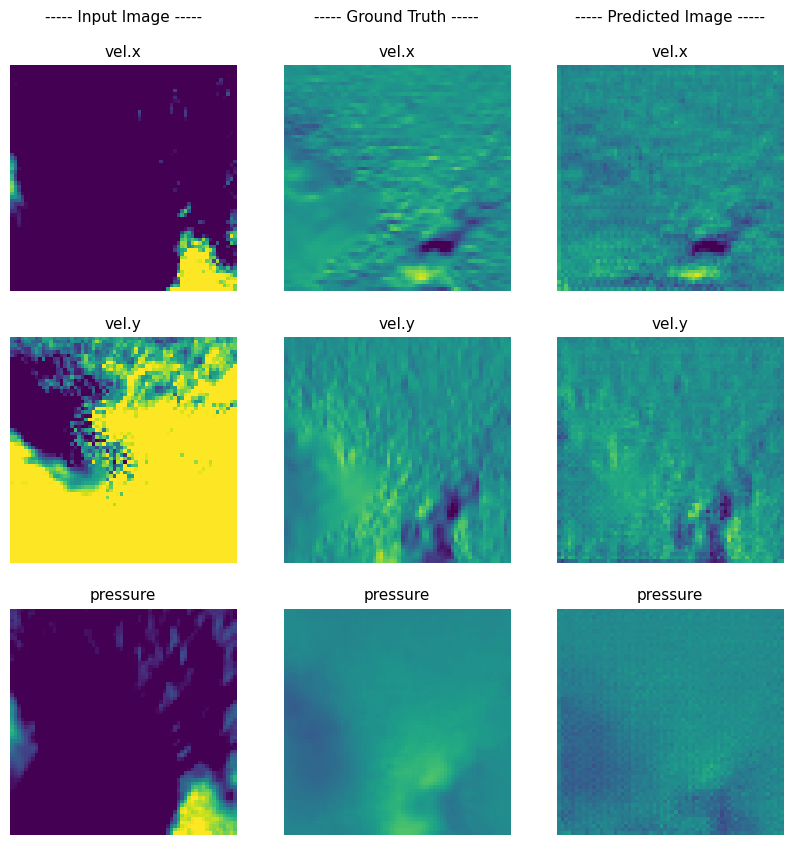

Epoch 25 took 88.75 seconds
Epoch 26, Batch 0:
Generator Loss: 1.0316,  LR: 4.86e-05
Discriminator Loss: 0.1148,  LR: 1.22e-05
Epoch 26, Batch 200:
Generator Loss: 1.4091,  LR: 4.86e-05
Discriminator Loss: 0.0461,  LR: 1.22e-05
Epoch 26, Batch 400:
Generator Loss: 1.2432,  LR: 4.86e-05
Discriminator Loss: 0.1162,  LR: 1.22e-05
Epoch 26, Batch 600:
Generator Loss: 1.1359,  LR: 4.86e-05
Discriminator Loss: 0.0575,  LR: 1.22e-05
Epoch 26 took 88.04 seconds
Epoch 27, Batch 0:
Generator Loss: 1.0479,  LR: 4.86e-05
Discriminator Loss: 0.1726,  LR: 1.22e-05
Epoch 27, Batch 200:
Generator Loss: 1.0169,  LR: 4.86e-05
Discriminator Loss: 0.1209,  LR: 1.22e-05
Epoch 27, Batch 400:
Generator Loss: 1.0237,  LR: 4.86e-05
Discriminator Loss: 0.1105,  LR: 1.22e-05
Epoch 27, Batch 600:
Generator Loss: 1.1471,  LR: 4.86e-05
Discriminator Loss: 0.0991,  LR: 1.22e-05
Epoch 27 took 87.22 seconds
Epoch 28, Batch 0:
Generator Loss: 1.0607,  LR: 4.86e-05
Discriminator Loss: 0.0761,  LR: 1.22e-05
Epoch 28, Bat

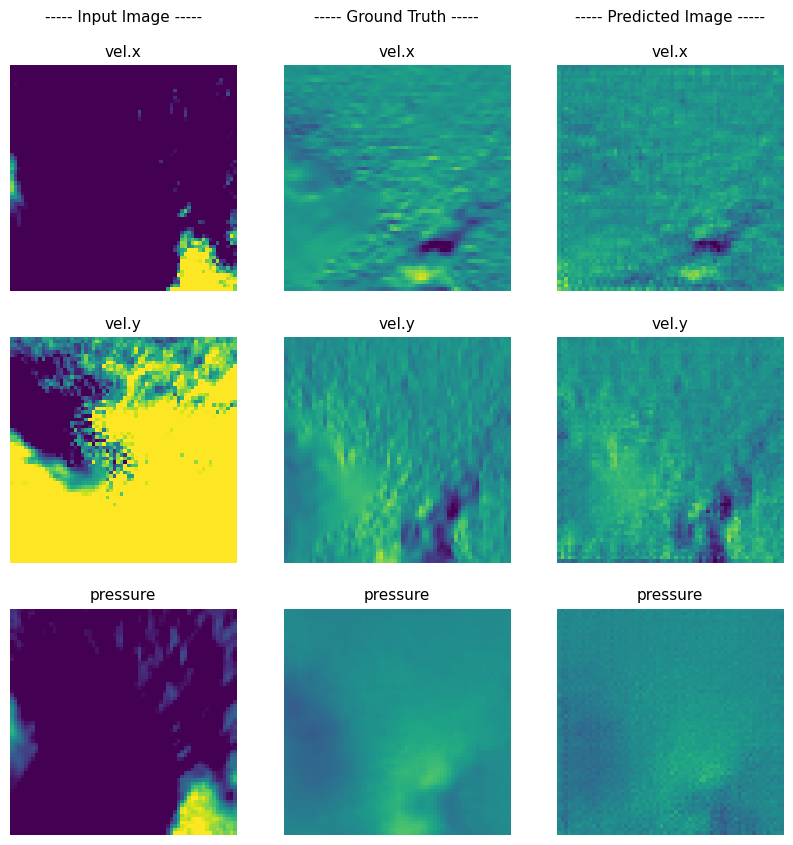

Epoch 30 took 92.97 seconds
Epoch 31, Batch 0:
Generator Loss: 2.5236,  LR: 4.67e-05
Discriminator Loss: 0.7399,  LR: 1.17e-05
Epoch 31, Batch 200:
Generator Loss: 1.3489,  LR: 4.67e-05
Discriminator Loss: 0.0511,  LR: 1.17e-05
Epoch 31, Batch 400:
Generator Loss: 1.0050,  LR: 4.67e-05
Discriminator Loss: 0.0678,  LR: 1.17e-05
Epoch 31, Batch 600:
Generator Loss: 0.9847,  LR: 4.67e-05
Discriminator Loss: 0.1512,  LR: 1.17e-05
Epoch 31 took 86.70 seconds
Epoch 32, Batch 0:
Generator Loss: 1.9969,  LR: 4.67e-05
Discriminator Loss: 0.1077,  LR: 1.17e-05
Epoch 32, Batch 200:
Generator Loss: 1.2385,  LR: 4.67e-05
Discriminator Loss: 0.0829,  LR: 1.17e-05
Epoch 32, Batch 400:
Generator Loss: 1.5356,  LR: 4.67e-05
Discriminator Loss: 0.0509,  LR: 1.17e-05
Epoch 32, Batch 600:
Generator Loss: 1.5363,  LR: 4.67e-05
Discriminator Loss: 0.0729,  LR: 1.17e-05
Epoch 32 took 86.53 seconds
Epoch 33, Batch 0:
Generator Loss: 1.9182,  LR: 4.67e-05
Discriminator Loss: 0.0409,  LR: 1.17e-05
Epoch 33, Bat

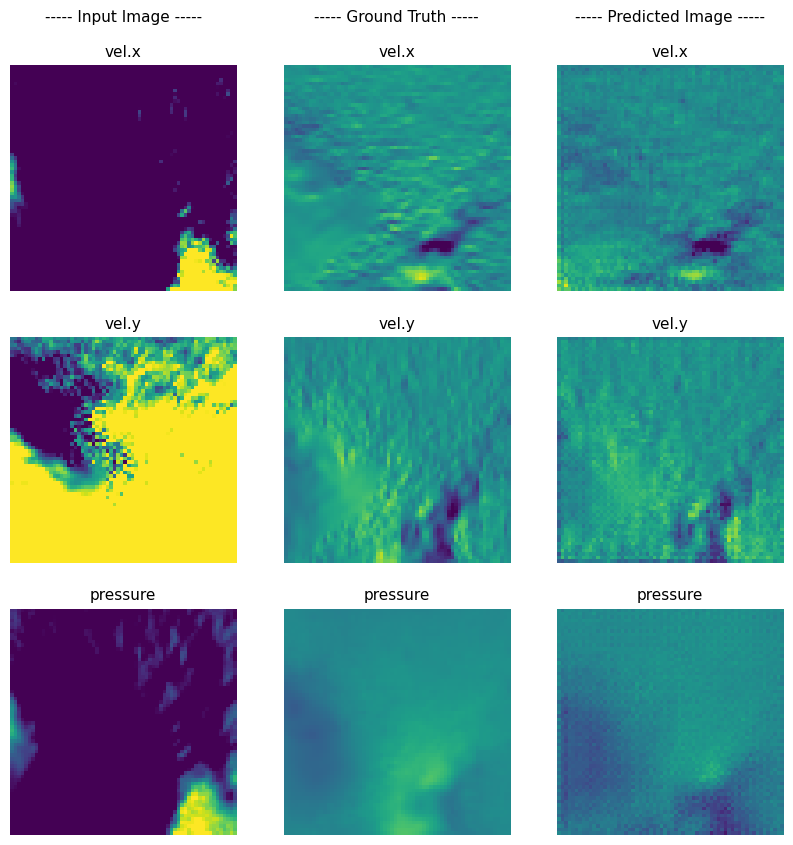

Epoch 35 took 87.15 seconds
Epoch 36, Batch 0:
Generator Loss: 1.3729,  LR: 4.48e-05
Discriminator Loss: 0.0876,  LR: 1.12e-05
Epoch 36, Batch 200:
Generator Loss: 1.1709,  LR: 4.48e-05
Discriminator Loss: 0.0909,  LR: 1.12e-05
Epoch 36, Batch 400:
Generator Loss: 1.3639,  LR: 4.48e-05
Discriminator Loss: 0.1430,  LR: 1.12e-05
Epoch 36, Batch 600:
Generator Loss: 1.0397,  LR: 4.48e-05
Discriminator Loss: 0.0840,  LR: 1.12e-05
Epoch 36 took 86.59 seconds
Epoch 37, Batch 0:
Generator Loss: 2.0985,  LR: 4.48e-05
Discriminator Loss: 0.0587,  LR: 1.12e-05
Epoch 37, Batch 200:
Generator Loss: 2.0578,  LR: 4.48e-05
Discriminator Loss: 0.0840,  LR: 1.12e-05
Epoch 37, Batch 400:
Generator Loss: 1.3852,  LR: 4.48e-05
Discriminator Loss: 0.1379,  LR: 1.12e-05
Epoch 37, Batch 600:
Generator Loss: 0.9844,  LR: 4.48e-05
Discriminator Loss: 0.0931,  LR: 1.12e-05
Epoch 37 took 86.40 seconds
Epoch 38, Batch 0:
Generator Loss: 1.0019,  LR: 4.48e-05
Discriminator Loss: 0.0723,  LR: 1.12e-05
Epoch 38, Bat

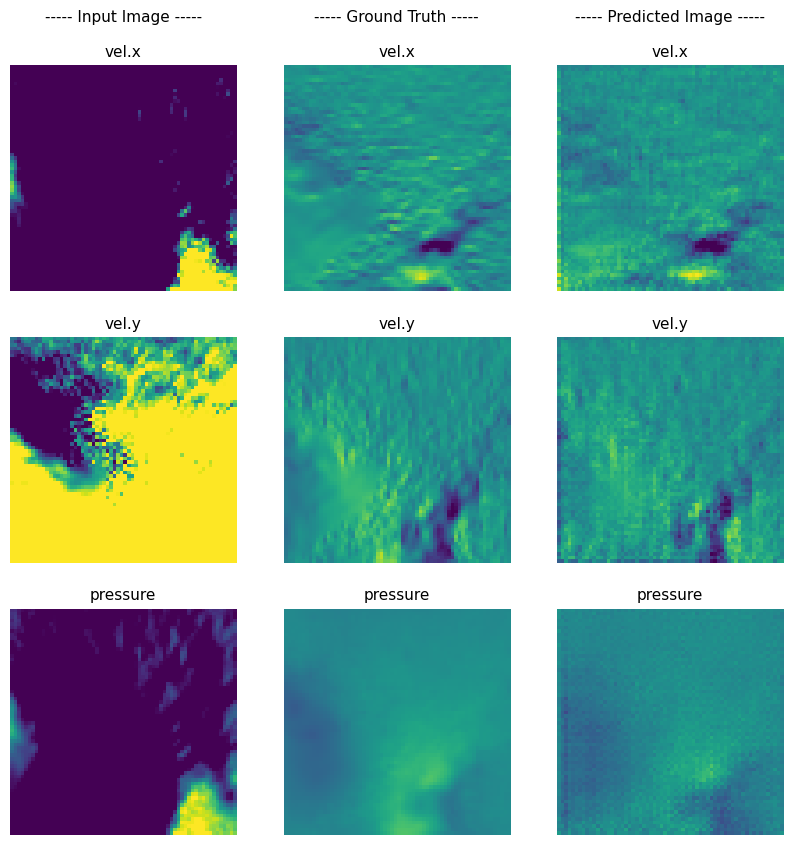

Checkpoint saved for epoch 40
Epoch 40 took 92.66 seconds
Epoch 41, Batch 0:
Generator Loss: 2.4332,  LR: 4.31e-05
Discriminator Loss: 0.1864,  LR: 1.08e-05
Epoch 41, Batch 200:
Generator Loss: 1.2211,  LR: 4.31e-05
Discriminator Loss: 0.0649,  LR: 1.08e-05
Epoch 41, Batch 400:
Generator Loss: 1.0480,  LR: 4.31e-05
Discriminator Loss: 0.0977,  LR: 1.08e-05
Epoch 41, Batch 600:
Generator Loss: 1.6709,  LR: 4.31e-05
Discriminator Loss: 0.0743,  LR: 1.08e-05
Epoch 41 took 86.48 seconds
Epoch 42, Batch 0:
Generator Loss: 1.2288,  LR: 4.31e-05
Discriminator Loss: 0.0762,  LR: 1.08e-05
Epoch 42, Batch 200:
Generator Loss: 1.1269,  LR: 4.31e-05
Discriminator Loss: 0.0695,  LR: 1.08e-05
Epoch 42, Batch 400:
Generator Loss: 1.0331,  LR: 4.31e-05
Discriminator Loss: 0.1461,  LR: 1.08e-05
Epoch 42, Batch 600:
Generator Loss: 1.3194,  LR: 4.31e-05
Discriminator Loss: 0.0757,  LR: 1.08e-05
Epoch 42 took 86.32 seconds
Epoch 43, Batch 0:
Generator Loss: 1.1370,  LR: 4.31e-05
Discriminator Loss: 0.100

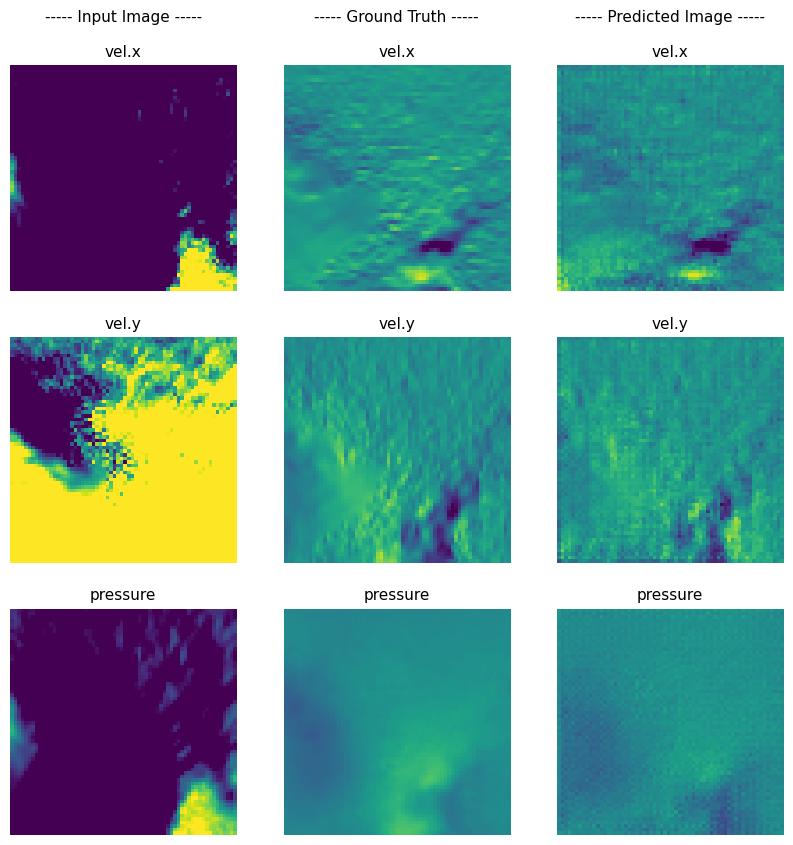

Epoch 45 took 86.38 seconds
Epoch 46, Batch 0:
Generator Loss: 1.1792,  LR: 4.14e-05
Discriminator Loss: 0.0659,  LR: 1.03e-05
Epoch 46, Batch 200:
Generator Loss: 1.4409,  LR: 4.14e-05
Discriminator Loss: 0.0641,  LR: 1.03e-05
Epoch 46, Batch 400:
Generator Loss: 1.0200,  LR: 4.14e-05
Discriminator Loss: 0.1089,  LR: 1.03e-05
Epoch 46, Batch 600:
Generator Loss: 1.0911,  LR: 4.14e-05
Discriminator Loss: 0.0453,  LR: 1.03e-05
Epoch 46 took 86.77 seconds
Epoch 47, Batch 0:
Generator Loss: 1.5587,  LR: 4.14e-05
Discriminator Loss: 3.0060,  LR: 1.03e-05
Epoch 47, Batch 200:
Generator Loss: 1.2572,  LR: 4.14e-05
Discriminator Loss: 7.7867,  LR: 1.03e-05
Epoch 47, Batch 400:
Generator Loss: 1.8919,  LR: 4.14e-05
Discriminator Loss: 0.1136,  LR: 1.03e-05
Epoch 47, Batch 600:
Generator Loss: 1.0363,  LR: 4.14e-05
Discriminator Loss: 0.1290,  LR: 1.03e-05
Epoch 47 took 86.76 seconds
Epoch 48, Batch 0:
Generator Loss: 1.7305,  LR: 4.14e-05
Discriminator Loss: 0.0870,  LR: 1.03e-05
Epoch 48, Bat

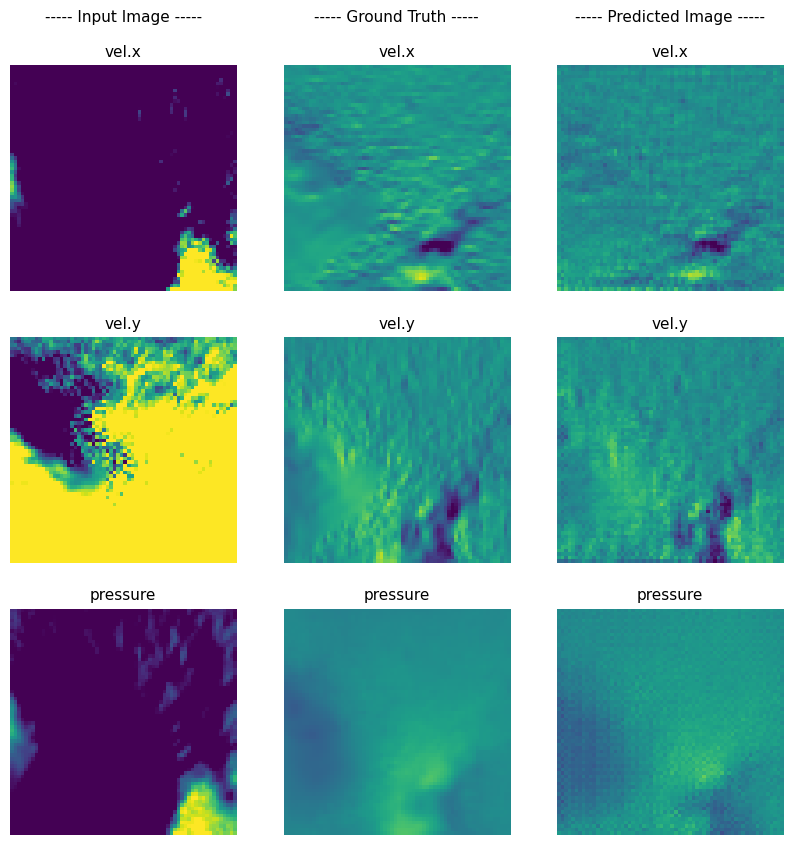

Epoch 50 took 92.08 seconds
Epoch 51, Batch 0:
Generator Loss: 1.6408,  LR: 3.97e-05
Discriminator Loss: 0.3091,  LR: 9.93e-06
Epoch 51, Batch 200:
Generator Loss: 1.0580,  LR: 3.97e-05
Discriminator Loss: 0.1508,  LR: 9.93e-06
Epoch 51, Batch 400:
Generator Loss: 0.7922,  LR: 3.97e-05
Discriminator Loss: 0.1528,  LR: 9.93e-06
Epoch 51, Batch 600:
Generator Loss: 1.7116,  LR: 3.97e-05
Discriminator Loss: 0.0316,  LR: 9.93e-06
Epoch 51 took 86.24 seconds
Epoch 52, Batch 0:
Generator Loss: 0.9651,  LR: 3.97e-05
Discriminator Loss: 0.1339,  LR: 9.93e-06
Epoch 52, Batch 200:
Generator Loss: 1.1402,  LR: 3.97e-05
Discriminator Loss: 0.0817,  LR: 9.93e-06
Epoch 52, Batch 400:
Generator Loss: 1.3528,  LR: 3.97e-05
Discriminator Loss: 0.0751,  LR: 9.93e-06
Epoch 52, Batch 600:
Generator Loss: 2.1203,  LR: 3.97e-05
Discriminator Loss: 0.0401,  LR: 9.93e-06
Epoch 52 took 86.15 seconds
Epoch 53, Batch 0:
Generator Loss: 0.9834,  LR: 3.97e-05
Discriminator Loss: 0.0711,  LR: 9.93e-06
Epoch 53, Bat

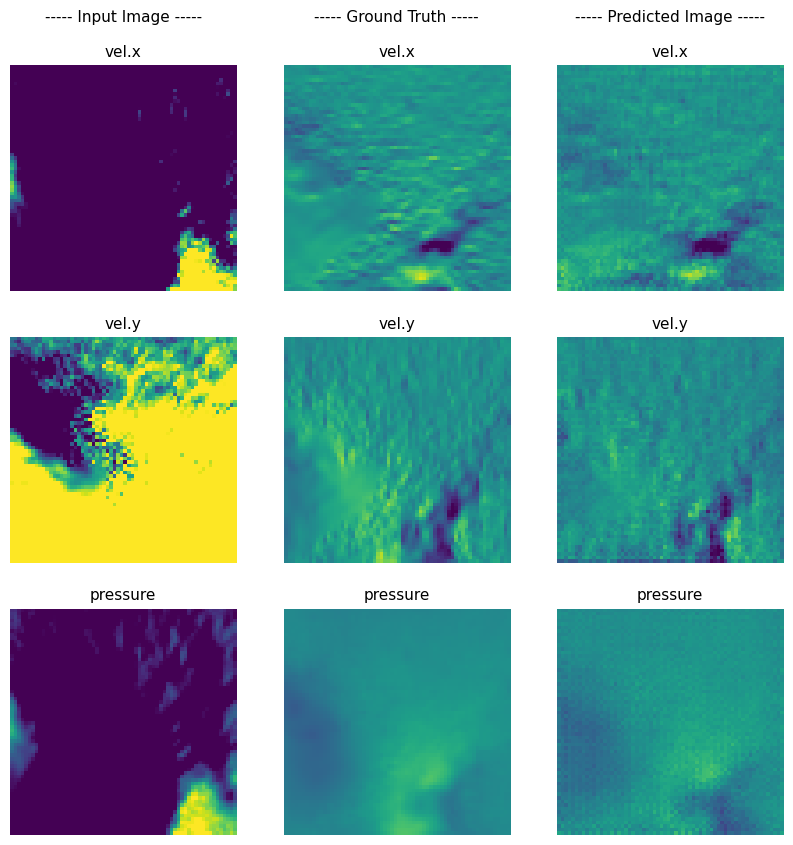

Epoch 55 took 86.45 seconds
Epoch 56, Batch 0:
Generator Loss: 1.4594,  LR: 3.82e-05
Discriminator Loss: 0.0392,  LR: 9.54e-06
Epoch 56, Batch 200:
Generator Loss: 0.9294,  LR: 3.82e-05
Discriminator Loss: 0.0743,  LR: 9.54e-06
Epoch 56, Batch 400:
Generator Loss: 1.0636,  LR: 3.82e-05
Discriminator Loss: 0.0622,  LR: 9.54e-06
Epoch 56, Batch 600:
Generator Loss: 1.1897,  LR: 3.82e-05
Discriminator Loss: 0.0845,  LR: 9.54e-06
Epoch 56 took 86.89 seconds
Epoch 57, Batch 0:
Generator Loss: 1.1597,  LR: 3.82e-05
Discriminator Loss: 0.0525,  LR: 9.54e-06
Epoch 57, Batch 200:
Generator Loss: 1.1031,  LR: 3.82e-05
Discriminator Loss: 0.0759,  LR: 9.54e-06
Epoch 57, Batch 400:
Generator Loss: 1.0547,  LR: 3.82e-05
Discriminator Loss: 0.0890,  LR: 9.54e-06
Epoch 57, Batch 600:
Generator Loss: 1.4443,  LR: 3.82e-05
Discriminator Loss: 0.0513,  LR: 9.54e-06
Epoch 57 took 86.61 seconds
Epoch 58, Batch 0:
Generator Loss: 1.0509,  LR: 3.82e-05
Discriminator Loss: 0.1263,  LR: 9.54e-06
Epoch 58, Bat

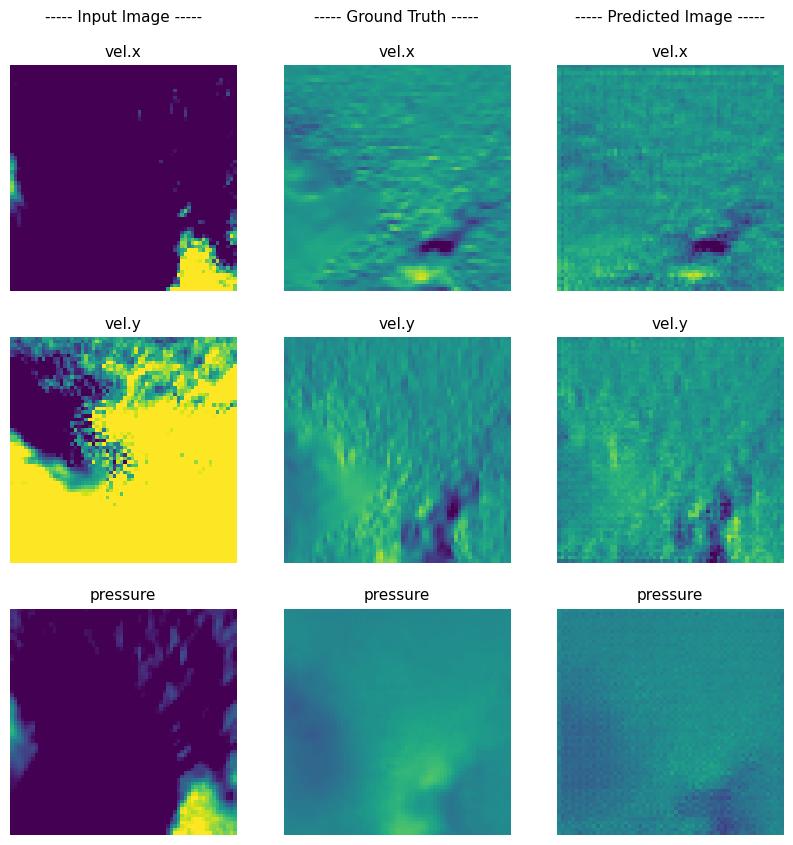

Checkpoint saved for epoch 60
Epoch 60 took 92.86 seconds
Epoch 61, Batch 0:
Generator Loss: 2.5697,  LR: 3.66e-05
Discriminator Loss: 0.0849,  LR: 9.16e-06
Epoch 61, Batch 200:
Generator Loss: 0.9220,  LR: 3.66e-05
Discriminator Loss: 0.1133,  LR: 9.16e-06
Epoch 61, Batch 400:
Generator Loss: 0.9878,  LR: 3.66e-05
Discriminator Loss: 0.0558,  LR: 9.16e-06
Epoch 61, Batch 600:
Generator Loss: 1.1957,  LR: 3.66e-05
Discriminator Loss: 0.0420,  LR: 9.16e-06
Epoch 61 took 86.52 seconds
Epoch 62, Batch 0:
Generator Loss: 1.3556,  LR: 3.66e-05
Discriminator Loss: 0.1077,  LR: 9.16e-06
Epoch 62, Batch 200:
Generator Loss: 1.1795,  LR: 3.66e-05
Discriminator Loss: 0.0952,  LR: 9.16e-06
Epoch 62, Batch 400:
Generator Loss: 1.1207,  LR: 3.66e-05
Discriminator Loss: 0.0889,  LR: 9.16e-06
Epoch 62, Batch 600:
Generator Loss: 1.2281,  LR: 3.66e-05
Discriminator Loss: 0.0699,  LR: 9.16e-06
Epoch 62 took 86.22 seconds
Epoch 63, Batch 0:
Generator Loss: 1.1681,  LR: 3.66e-05
Discriminator Loss: 0.114

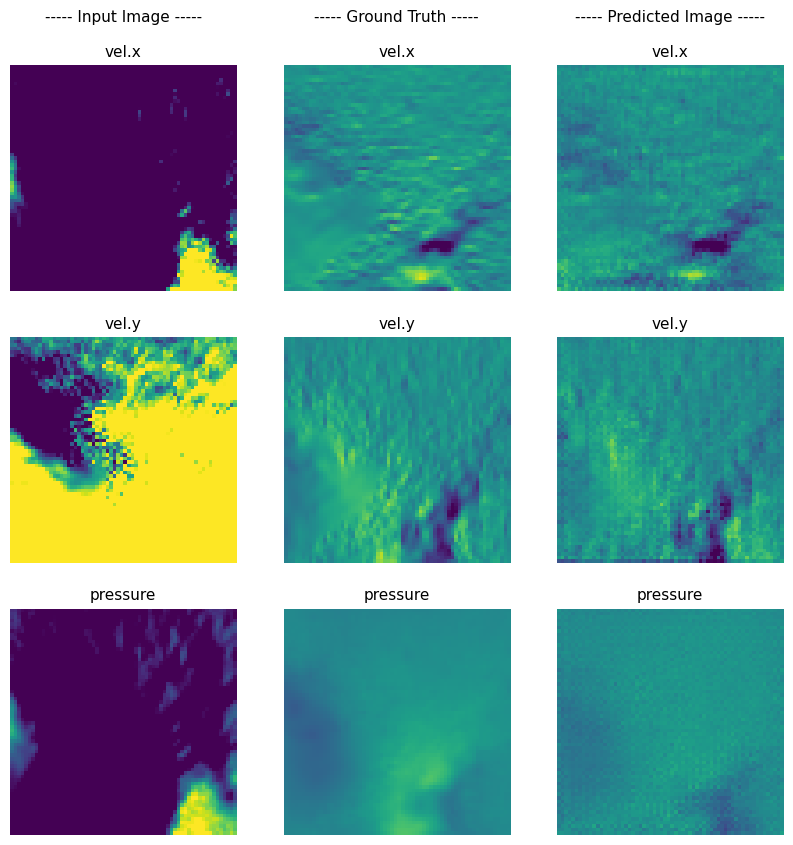

Epoch 65 took 87.00 seconds
Epoch 66, Batch 0:
Generator Loss: 1.3560,  LR: 3.52e-05
Discriminator Loss: 0.0549,  LR: 8.80e-06
Epoch 66, Batch 200:
Generator Loss: 0.8963,  LR: 3.52e-05
Discriminator Loss: 0.0690,  LR: 8.80e-06
Epoch 66, Batch 400:
Generator Loss: 0.9509,  LR: 3.52e-05
Discriminator Loss: 0.1871,  LR: 8.80e-06
Epoch 66, Batch 600:
Generator Loss: 1.1148,  LR: 3.52e-05
Discriminator Loss: 0.0453,  LR: 8.80e-06
Epoch 66 took 86.43 seconds
Epoch 67, Batch 0:
Generator Loss: 0.9960,  LR: 3.52e-05
Discriminator Loss: 0.1320,  LR: 8.80e-06
Epoch 67, Batch 200:
Generator Loss: 1.1301,  LR: 3.52e-05
Discriminator Loss: 0.0629,  LR: 8.80e-06
Epoch 67, Batch 400:
Generator Loss: 2.3720,  LR: 3.52e-05
Discriminator Loss: 0.0424,  LR: 8.80e-06
Epoch 67, Batch 600:
Generator Loss: 1.0192,  LR: 3.52e-05
Discriminator Loss: 0.1338,  LR: 8.80e-06
Epoch 67 took 86.22 seconds
Epoch 68, Batch 0:
Generator Loss: 1.1707,  LR: 3.52e-05
Discriminator Loss: 0.0950,  LR: 8.80e-06
Epoch 68, Bat

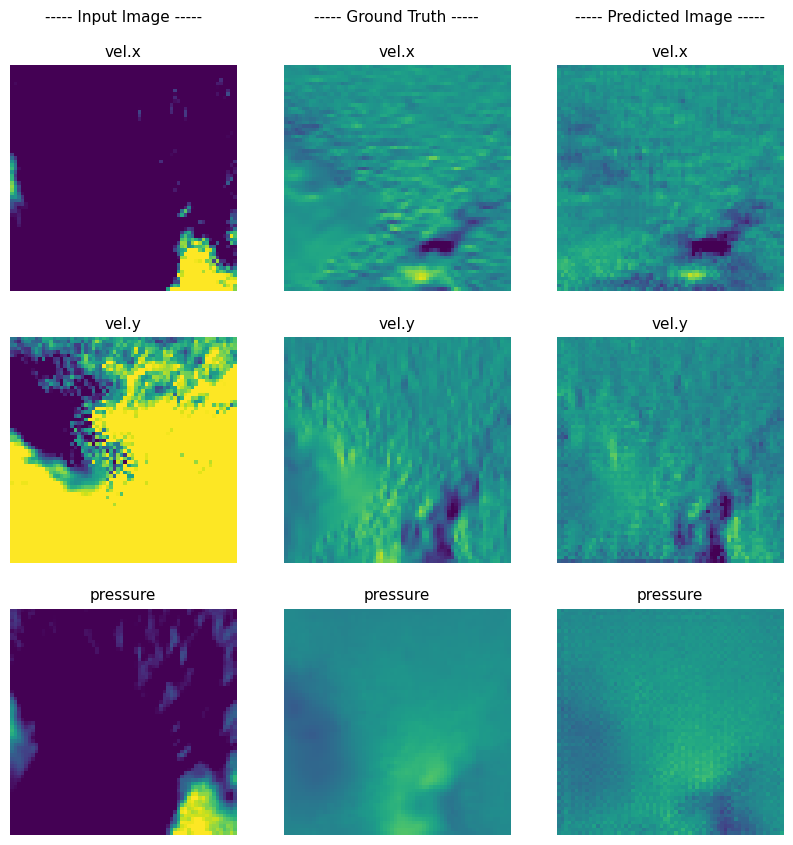

Epoch 70 took 92.29 seconds
Epoch 71, Batch 0:
Generator Loss: 2.0295,  LR: 3.38e-05
Discriminator Loss: 0.1950,  LR: 8.45e-06
Epoch 71, Batch 200:
Generator Loss: 1.2833,  LR: 3.38e-05
Discriminator Loss: 0.1265,  LR: 8.45e-06
Epoch 71, Batch 400:
Generator Loss: 0.9598,  LR: 3.38e-05
Discriminator Loss: 0.1275,  LR: 8.45e-06
Epoch 71, Batch 600:
Generator Loss: 0.9626,  LR: 3.38e-05
Discriminator Loss: 0.0746,  LR: 8.45e-06
Epoch 71 took 88.02 seconds
Epoch 72, Batch 0:
Generator Loss: 1.2013,  LR: 3.38e-05
Discriminator Loss: 0.0690,  LR: 8.45e-06
Epoch 72, Batch 200:
Generator Loss: 1.0256,  LR: 3.38e-05
Discriminator Loss: 0.1159,  LR: 8.45e-06
Epoch 72, Batch 400:
Generator Loss: 1.5184,  LR: 3.38e-05
Discriminator Loss: 0.0571,  LR: 8.45e-06
Epoch 72, Batch 600:
Generator Loss: 1.2873,  LR: 3.38e-05
Discriminator Loss: 0.0732,  LR: 8.45e-06
Epoch 72 took 86.52 seconds
Epoch 73, Batch 0:
Generator Loss: 1.4785,  LR: 3.38e-05
Discriminator Loss: 0.0789,  LR: 8.45e-06
Epoch 73, Bat

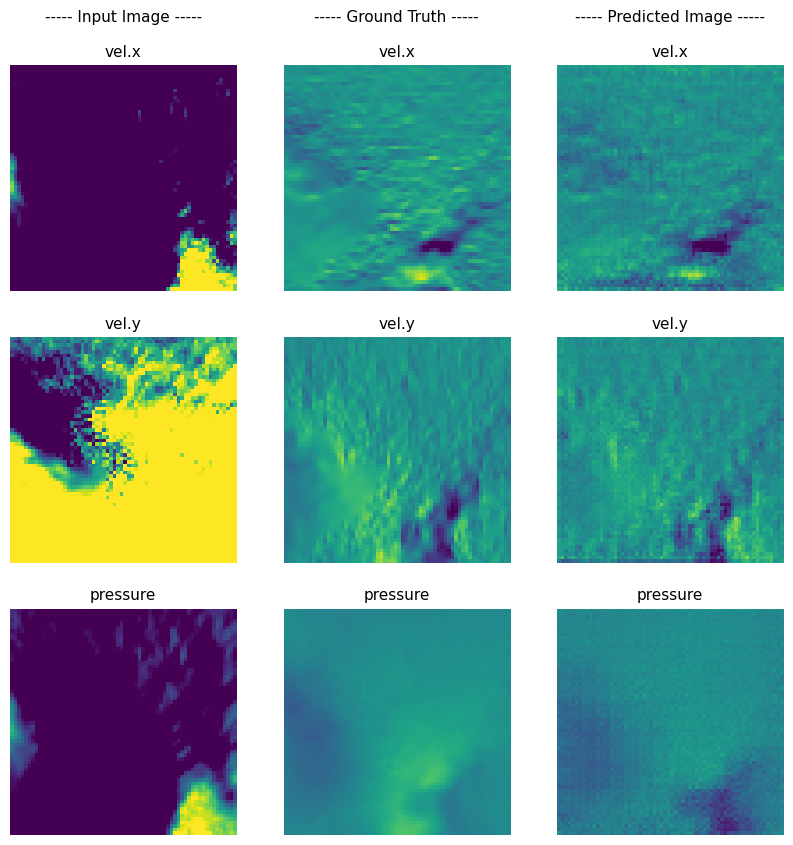

Epoch 75 took 89.12 seconds
Epoch 76, Batch 0:
Generator Loss: 1.1637,  LR: 3.25e-05
Discriminator Loss: 0.0924,  LR: 8.12e-06
Epoch 76, Batch 200:
Generator Loss: 1.1441,  LR: 3.25e-05
Discriminator Loss: 0.0970,  LR: 8.12e-06
Epoch 76, Batch 400:
Generator Loss: 1.4842,  LR: 3.25e-05
Discriminator Loss: 0.0332,  LR: 8.12e-06
Epoch 76, Batch 600:
Generator Loss: 1.5106,  LR: 3.25e-05
Discriminator Loss: 0.0521,  LR: 8.12e-06
Epoch 76 took 90.36 seconds
Epoch 77, Batch 0:
Generator Loss: 1.1563,  LR: 3.25e-05
Discriminator Loss: 0.0432,  LR: 8.12e-06
Epoch 77, Batch 200:
Generator Loss: 1.2662,  LR: 3.25e-05
Discriminator Loss: 0.0334,  LR: 8.12e-06
Epoch 77, Batch 400:
Generator Loss: 1.6636,  LR: 3.25e-05
Discriminator Loss: 0.0868,  LR: 8.12e-06
Epoch 77, Batch 600:
Generator Loss: 1.0432,  LR: 3.25e-05
Discriminator Loss: 0.0648,  LR: 8.12e-06
Epoch 77 took 90.27 seconds
Epoch 78, Batch 0:
Generator Loss: 1.3026,  LR: 3.25e-05
Discriminator Loss: 0.1033,  LR: 8.12e-06
Epoch 78, Bat

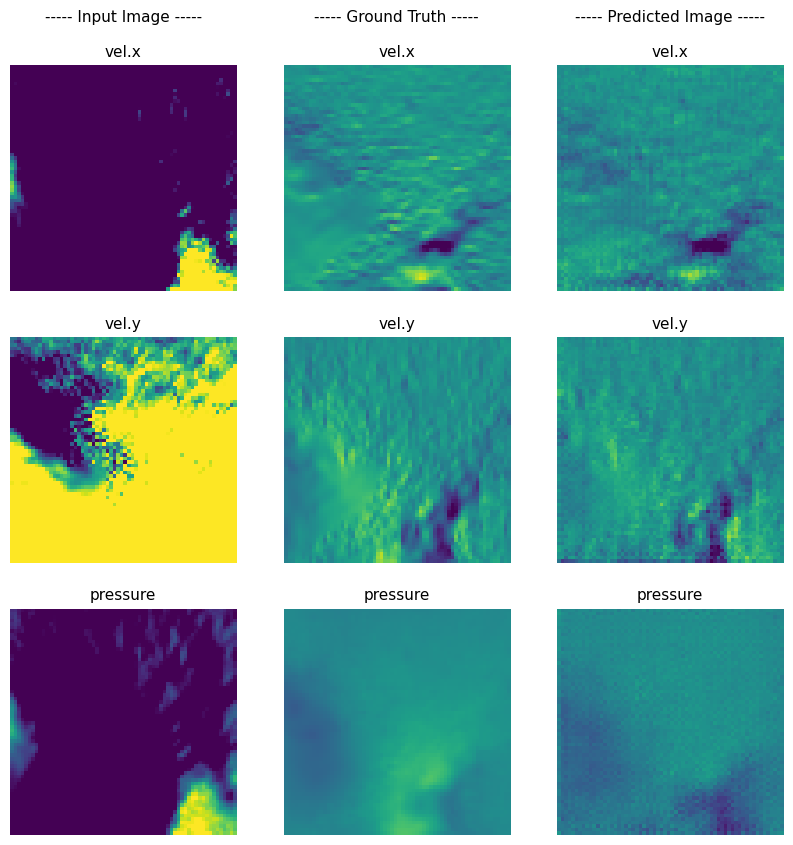

Checkpoint saved for epoch 80
Epoch 80 took 97.12 seconds
Epoch 81, Batch 0:
Generator Loss: 2.3920,  LR: 3.12e-05
Discriminator Loss: 0.1381,  LR: 7.79e-06
Epoch 81, Batch 200:
Generator Loss: 1.3341,  LR: 3.12e-05
Discriminator Loss: 0.0734,  LR: 7.79e-06
Epoch 81, Batch 400:
Generator Loss: 1.2830,  LR: 3.12e-05
Discriminator Loss: 0.0923,  LR: 7.79e-06
Epoch 81, Batch 600:
Generator Loss: 0.9261,  LR: 3.12e-05
Discriminator Loss: 0.1176,  LR: 7.79e-06
Epoch 81 took 91.80 seconds
Epoch 82, Batch 0:
Generator Loss: 1.4502,  LR: 3.12e-05
Discriminator Loss: 0.0863,  LR: 7.79e-06
Epoch 82, Batch 200:
Generator Loss: 0.8961,  LR: 3.12e-05
Discriminator Loss: 0.0928,  LR: 7.79e-06
Epoch 82, Batch 400:
Generator Loss: 1.3722,  LR: 3.12e-05
Discriminator Loss: 0.0924,  LR: 7.79e-06
Epoch 82, Batch 600:
Generator Loss: 1.6469,  LR: 3.12e-05
Discriminator Loss: 0.0895,  LR: 7.79e-06
Epoch 82 took 90.24 seconds
Epoch 83, Batch 0:
Generator Loss: 1.5234,  LR: 3.12e-05
Discriminator Loss: 0.059

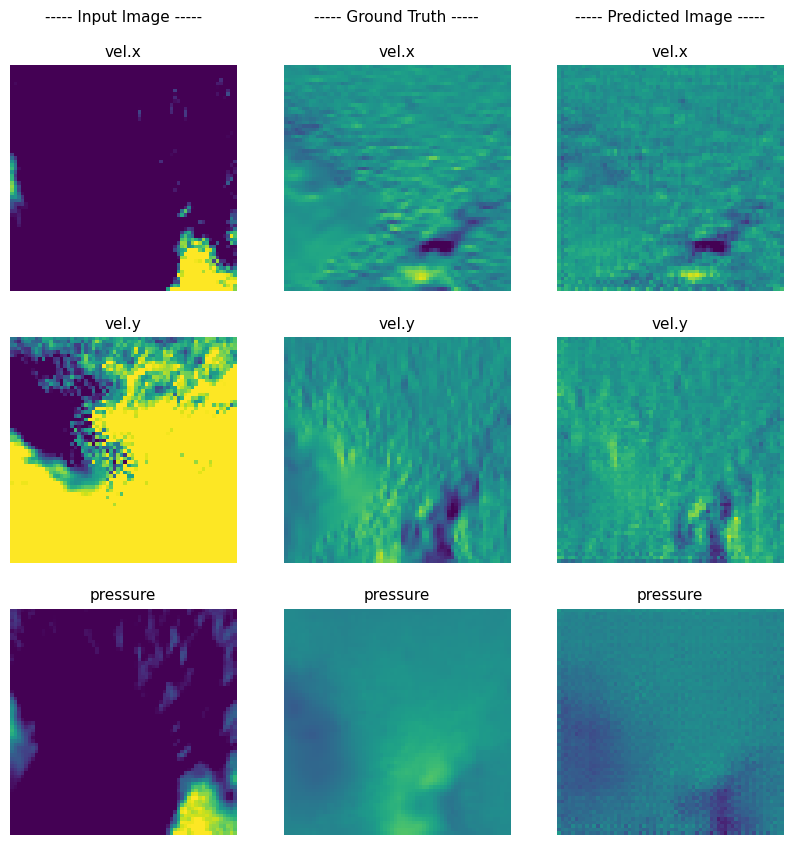

Epoch 85 took 90.88 seconds
Epoch 86, Batch 0:
Generator Loss: 2.0170,  LR: 2.99e-05
Discriminator Loss: 0.0806,  LR: 7.49e-06
Epoch 86, Batch 200:
Generator Loss: 1.3963,  LR: 2.99e-05
Discriminator Loss: 0.0812,  LR: 7.49e-06
Epoch 86, Batch 400:
Generator Loss: 1.0910,  LR: 2.99e-05
Discriminator Loss: 0.0452,  LR: 7.49e-06
Epoch 86, Batch 600:
Generator Loss: 0.9285,  LR: 2.99e-05
Discriminator Loss: 0.0975,  LR: 7.49e-06
Epoch 86 took 98.65 seconds
Epoch 87, Batch 0:
Generator Loss: 0.8839,  LR: 2.99e-05
Discriminator Loss: 0.1679,  LR: 7.49e-06
Epoch 87, Batch 200:
Generator Loss: 1.1235,  LR: 2.99e-05
Discriminator Loss: 0.0439,  LR: 7.49e-06
Epoch 87, Batch 400:
Generator Loss: 1.2855,  LR: 2.99e-05
Discriminator Loss: 0.0492,  LR: 7.49e-06
Epoch 87, Batch 600:
Generator Loss: 0.8876,  LR: 2.99e-05
Discriminator Loss: 0.1173,  LR: 7.49e-06
Epoch 87 took 87.51 seconds
Epoch 88, Batch 0:
Generator Loss: 1.0345,  LR: 2.99e-05
Discriminator Loss: 0.0416,  LR: 7.49e-06
Epoch 88, Bat

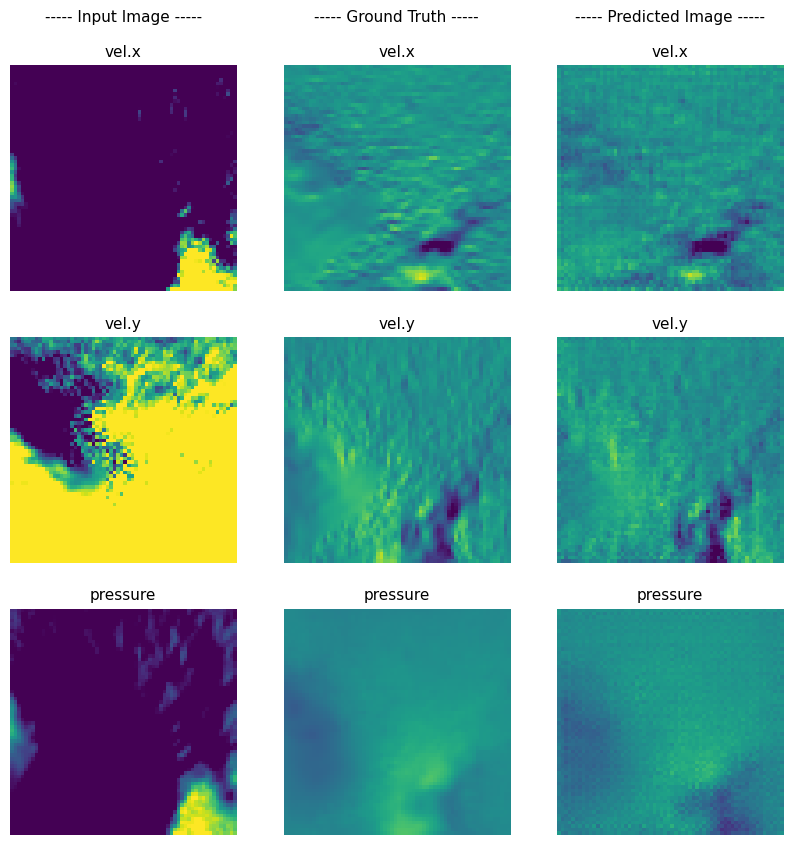

Epoch 90 took 92.06 seconds
Epoch 91, Batch 0:
Generator Loss: 2.4804,  LR: 2.88e-05
Discriminator Loss: 0.0909,  LR: 7.19e-06
Epoch 91, Batch 200:
Generator Loss: 1.2374,  LR: 2.88e-05
Discriminator Loss: 0.0665,  LR: 7.19e-06
Epoch 91, Batch 400:
Generator Loss: 1.0854,  LR: 2.88e-05
Discriminator Loss: 0.0277,  LR: 7.19e-06
Epoch 91, Batch 600:
Generator Loss: 1.2074,  LR: 2.88e-05
Discriminator Loss: 0.0781,  LR: 7.19e-06
Epoch 91 took 86.52 seconds
Epoch 92, Batch 0:
Generator Loss: 1.2701,  LR: 2.88e-05
Discriminator Loss: 0.0223,  LR: 7.19e-06
Epoch 92, Batch 200:
Generator Loss: 1.1675,  LR: 2.88e-05
Discriminator Loss: 0.0330,  LR: 7.19e-06
Epoch 92, Batch 400:
Generator Loss: 1.0795,  LR: 2.88e-05
Discriminator Loss: 0.0562,  LR: 7.19e-06
Epoch 92, Batch 600:
Generator Loss: 1.1561,  LR: 2.88e-05
Discriminator Loss: 0.0808,  LR: 7.19e-06
Epoch 92 took 86.75 seconds
Epoch 93, Batch 0:
Generator Loss: 1.1553,  LR: 2.88e-05
Discriminator Loss: 0.0692,  LR: 7.19e-06
Epoch 93, Bat

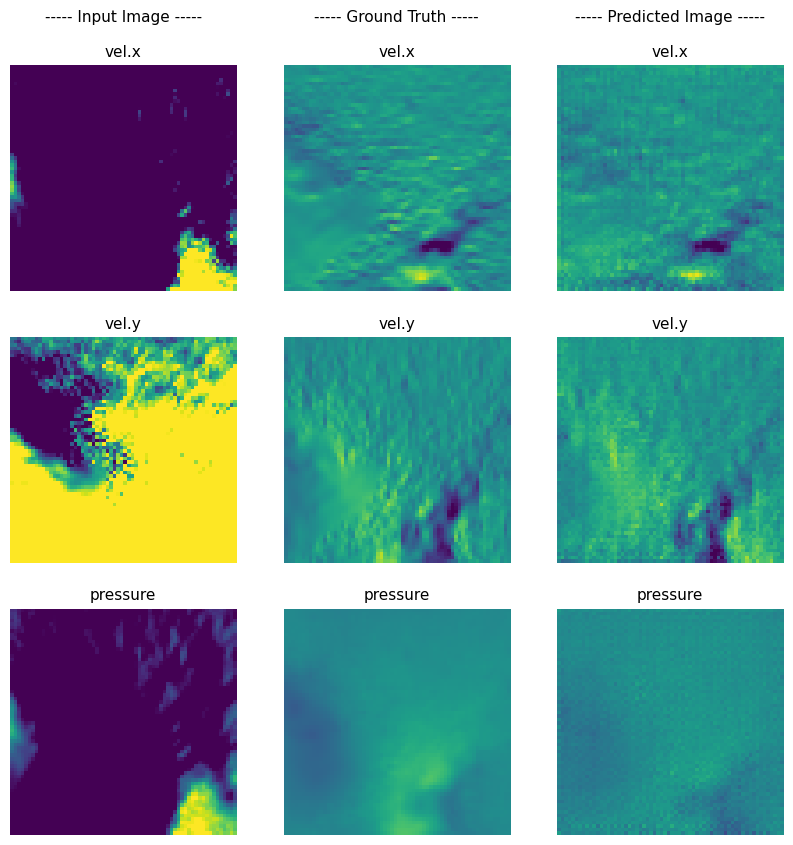

Epoch 95 took 86.58 seconds
Epoch 96, Batch 0:
Generator Loss: 1.0374,  LR: 2.76e-05
Discriminator Loss: 0.0870,  LR: 6.90e-06
Epoch 96, Batch 200:
Generator Loss: 1.3397,  LR: 2.76e-05
Discriminator Loss: 0.0669,  LR: 6.90e-06
Epoch 96, Batch 400:
Generator Loss: 1.5615,  LR: 2.76e-05
Discriminator Loss: 0.0498,  LR: 6.90e-06
Epoch 96, Batch 600:
Generator Loss: 1.0322,  LR: 2.76e-05
Discriminator Loss: 0.0460,  LR: 6.90e-06
Epoch 96 took 86.28 seconds
Epoch 97, Batch 0:
Generator Loss: 1.3723,  LR: 2.76e-05
Discriminator Loss: 0.0856,  LR: 6.90e-06
Epoch 97, Batch 200:
Generator Loss: 1.0146,  LR: 2.76e-05
Discriminator Loss: 0.1611,  LR: 6.90e-06
Epoch 97, Batch 400:
Generator Loss: 1.4575,  LR: 2.76e-05
Discriminator Loss: 0.0275,  LR: 6.90e-06
Epoch 97, Batch 600:
Generator Loss: 1.6504,  LR: 2.76e-05
Discriminator Loss: 0.0656,  LR: 6.90e-06
Epoch 97 took 86.38 seconds
Epoch 98, Batch 0:
Generator Loss: 1.3508,  LR: 2.76e-05
Discriminator Loss: 0.0957,  LR: 6.90e-06
Epoch 98, Bat

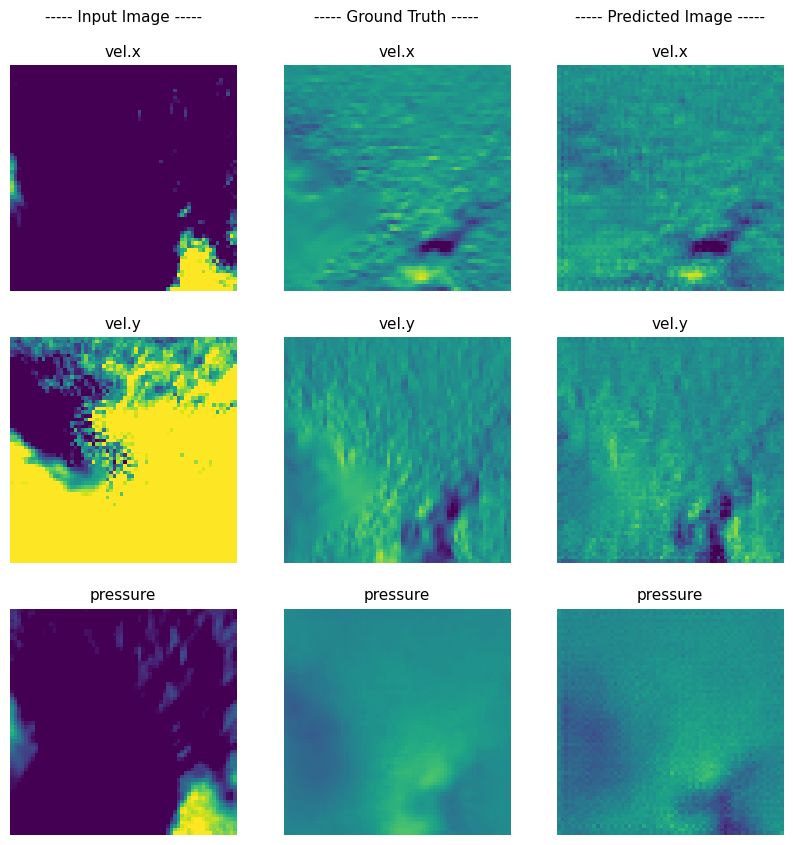

Checkpoint saved for epoch 100
Epoch 100 took 93.11 seconds
Epoch 101, Batch 0:
Generator Loss: 2.4838,  LR: 2.65e-05
Discriminator Loss: 0.0427,  LR: 6.63e-06
Epoch 101, Batch 200:
Generator Loss: 1.0123,  LR: 2.65e-05
Discriminator Loss: 0.0611,  LR: 6.63e-06
Epoch 101, Batch 400:
Generator Loss: 1.4538,  LR: 2.65e-05
Discriminator Loss: 0.0232,  LR: 6.63e-06
Epoch 101, Batch 600:
Generator Loss: 1.0170,  LR: 2.65e-05
Discriminator Loss: 0.0368,  LR: 6.63e-06
Epoch 101 took 86.84 seconds
Epoch 102, Batch 0:
Generator Loss: 1.0085,  LR: 2.65e-05
Discriminator Loss: 0.0485,  LR: 6.63e-06
Epoch 102, Batch 200:
Generator Loss: 1.1058,  LR: 2.65e-05
Discriminator Loss: 0.0723,  LR: 6.63e-06
Epoch 102, Batch 400:
Generator Loss: 1.0974,  LR: 2.65e-05
Discriminator Loss: 0.0289,  LR: 6.63e-06
Epoch 102, Batch 600:
Generator Loss: 1.0975,  LR: 2.65e-05
Discriminator Loss: 0.1172,  LR: 6.63e-06
Epoch 102 took 86.56 seconds
Epoch 103, Batch 0:
Generator Loss: 1.9914,  LR: 2.65e-05
Discriminato

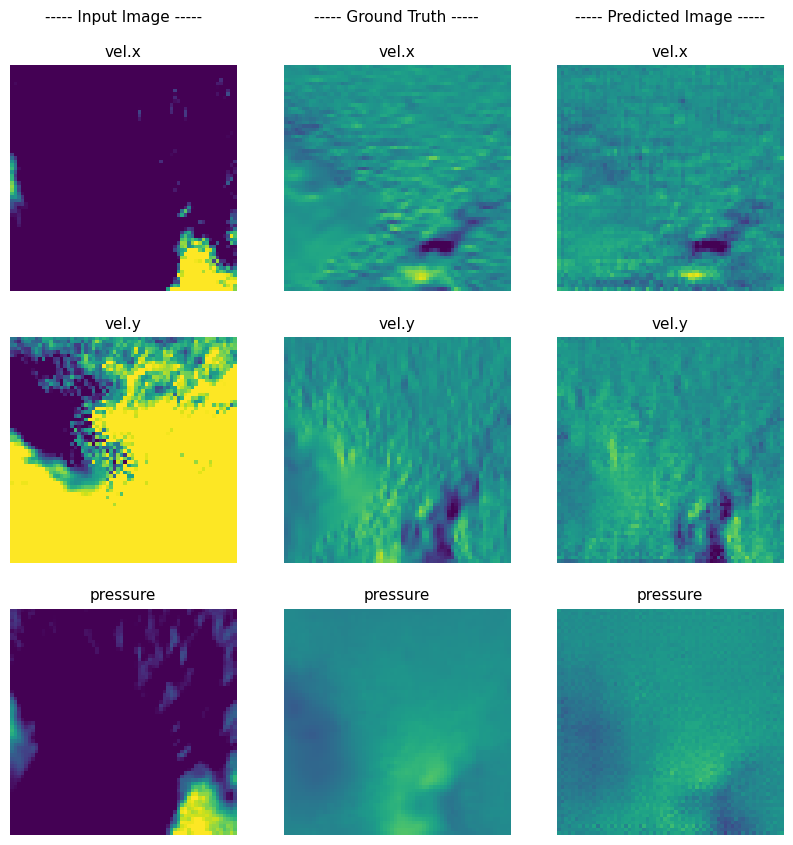

Epoch 105 took 86.77 seconds
Epoch 106, Batch 0:
Generator Loss: 1.0664,  LR: 2.55e-05
Discriminator Loss: 0.0471,  LR: 6.37e-06
Epoch 106, Batch 200:
Generator Loss: 1.5142,  LR: 2.55e-05
Discriminator Loss: 0.0896,  LR: 6.37e-06
Epoch 106, Batch 400:
Generator Loss: 1.4044,  LR: 2.55e-05
Discriminator Loss: 0.0589,  LR: 6.37e-06
Epoch 106, Batch 600:
Generator Loss: 1.2026,  LR: 2.55e-05
Discriminator Loss: 0.2925,  LR: 6.37e-06
Epoch 106 took 86.53 seconds
Epoch 107, Batch 0:
Generator Loss: 1.0638,  LR: 2.55e-05
Discriminator Loss: 0.0308,  LR: 6.37e-06
Epoch 107, Batch 200:
Generator Loss: 1.0752,  LR: 2.55e-05
Discriminator Loss: 0.0873,  LR: 6.37e-06
Epoch 107, Batch 400:
Generator Loss: 1.2628,  LR: 2.55e-05
Discriminator Loss: 0.0602,  LR: 6.37e-06
Epoch 107, Batch 600:
Generator Loss: 1.1635,  LR: 2.55e-05
Discriminator Loss: 0.0703,  LR: 6.37e-06
Epoch 107 took 86.40 seconds
Epoch 108, Batch 0:
Generator Loss: 1.0276,  LR: 2.55e-05
Discriminator Loss: 0.1264,  LR: 6.37e-06
E

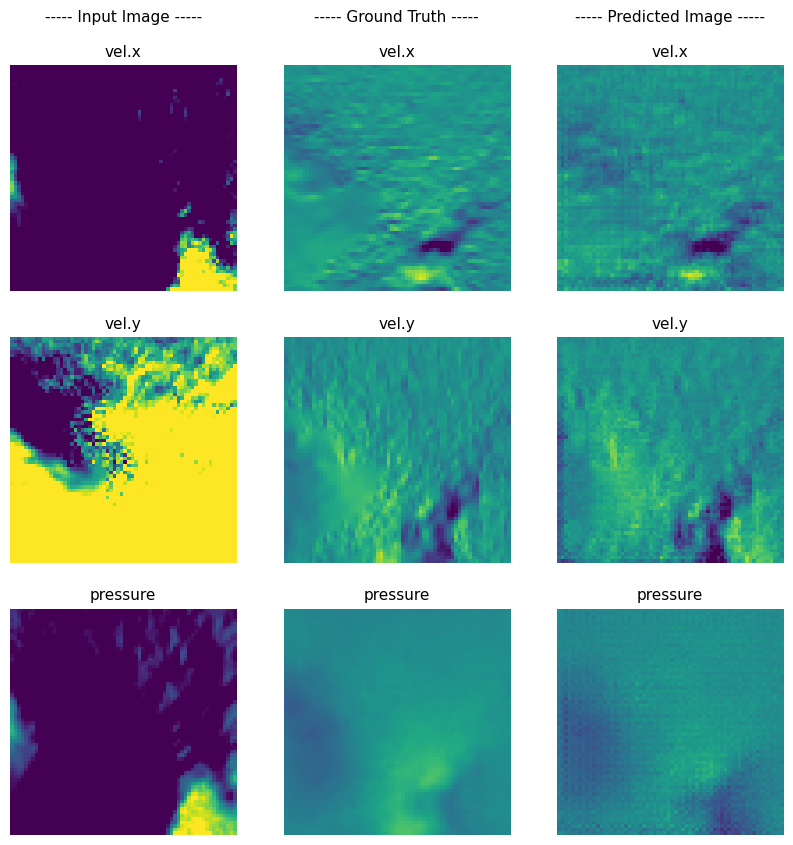

Epoch 110 took 91.93 seconds
Epoch 111, Batch 0:
Generator Loss: 2.4388,  LR: 2.45e-05
Discriminator Loss: 0.0759,  LR: 6.12e-06
Epoch 111, Batch 200:
Generator Loss: 1.3116,  LR: 2.45e-05
Discriminator Loss: 0.1483,  LR: 6.12e-06
Epoch 111, Batch 400:
Generator Loss: 1.5830,  LR: 2.45e-05
Discriminator Loss: 0.0451,  LR: 6.12e-06
Epoch 111, Batch 600:
Generator Loss: 0.8060,  LR: 2.45e-05
Discriminator Loss: 0.2515,  LR: 6.12e-06
Epoch 111 took 86.47 seconds
Epoch 112, Batch 0:
Generator Loss: 1.1629,  LR: 2.45e-05
Discriminator Loss: 0.0330,  LR: 6.12e-06
Epoch 112, Batch 200:
Generator Loss: 1.1464,  LR: 2.45e-05
Discriminator Loss: 0.0889,  LR: 6.12e-06
Epoch 112, Batch 400:
Generator Loss: 1.3933,  LR: 2.45e-05
Discriminator Loss: 0.0570,  LR: 6.12e-06
Epoch 112, Batch 600:
Generator Loss: 1.5902,  LR: 2.45e-05
Discriminator Loss: 0.0624,  LR: 6.12e-06
Epoch 112 took 86.69 seconds
Epoch 113, Batch 0:
Generator Loss: 1.8631,  LR: 2.45e-05
Discriminator Loss: 0.0763,  LR: 6.12e-06
E

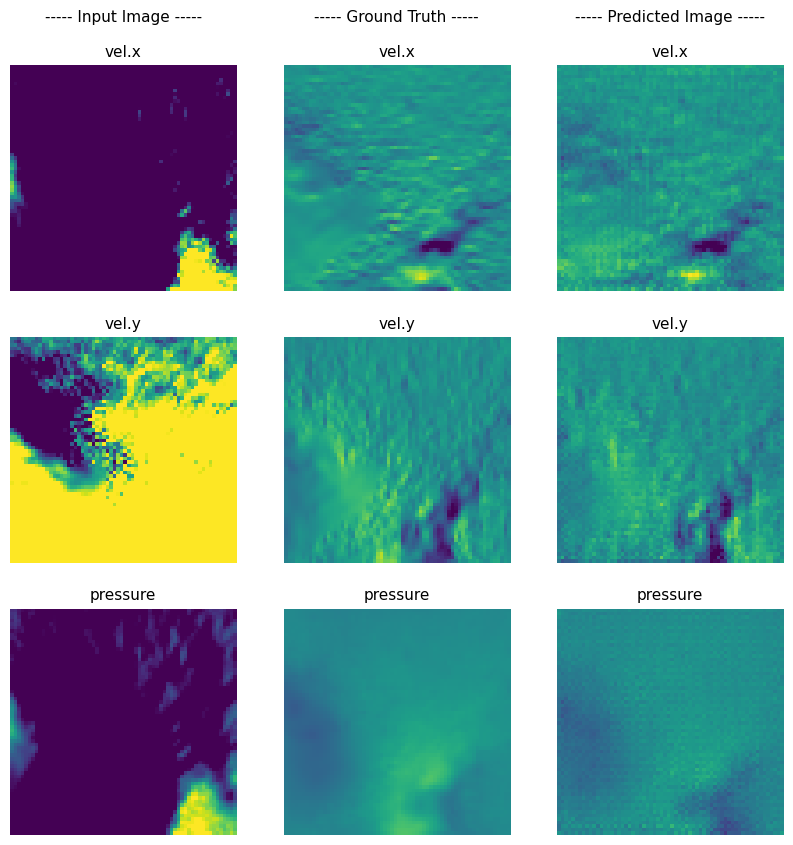

Epoch 115 took 87.08 seconds
Epoch 116, Batch 0:
Generator Loss: 0.9897,  LR: 2.35e-05
Discriminator Loss: 0.0297,  LR: 5.87e-06
Epoch 116, Batch 200:
Generator Loss: 0.8772,  LR: 2.35e-05
Discriminator Loss: 0.0974,  LR: 5.87e-06
Epoch 116, Batch 400:
Generator Loss: 1.2528,  LR: 2.35e-05
Discriminator Loss: 0.0676,  LR: 5.87e-06
Epoch 116, Batch 600:
Generator Loss: 1.3560,  LR: 2.35e-05
Discriminator Loss: 0.3545,  LR: 5.87e-06
Epoch 116 took 86.38 seconds
Epoch 117, Batch 0:
Generator Loss: 1.0910,  LR: 2.35e-05
Discriminator Loss: 0.0387,  LR: 5.87e-06
Epoch 117, Batch 200:
Generator Loss: 1.3389,  LR: 2.35e-05
Discriminator Loss: 0.0436,  LR: 5.87e-06
Epoch 117, Batch 400:
Generator Loss: 0.8723,  LR: 2.35e-05
Discriminator Loss: 0.0498,  LR: 5.87e-06
Epoch 117, Batch 600:
Generator Loss: 0.8924,  LR: 2.35e-05
Discriminator Loss: 0.1957,  LR: 5.87e-06
Epoch 117 took 86.53 seconds
Epoch 118, Batch 0:
Generator Loss: 1.2696,  LR: 2.35e-05
Discriminator Loss: 0.0363,  LR: 5.87e-06
E

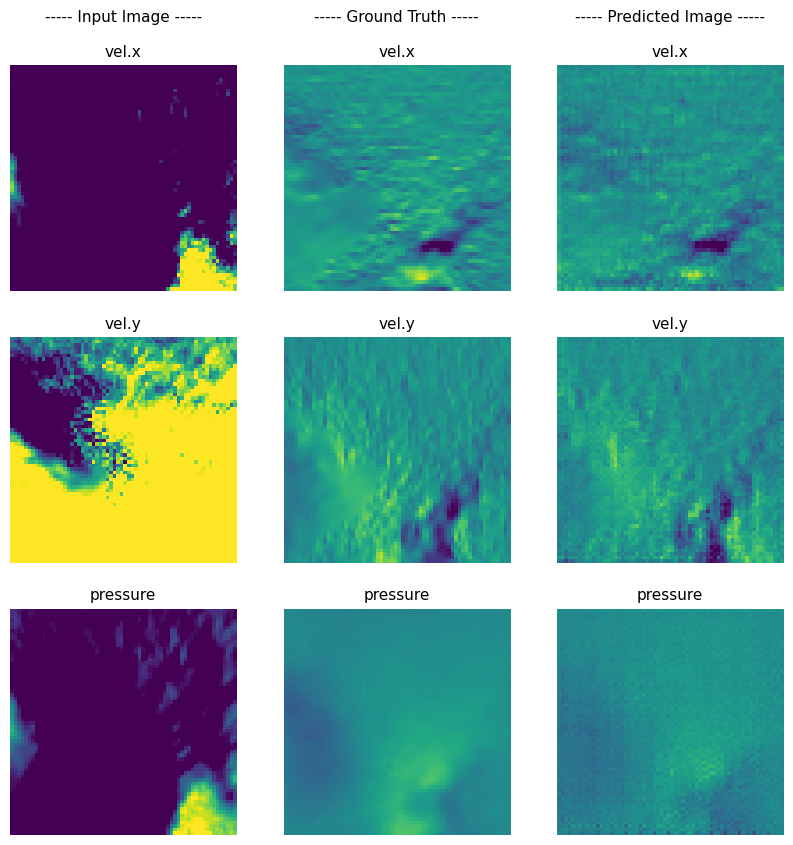

Checkpoint saved for epoch 120
Epoch 120 took 93.02 seconds
Epoch 121, Batch 0:
Generator Loss: 2.5137,  LR: 2.26e-05
Discriminator Loss: 0.0925,  LR: 5.64e-06
Epoch 121, Batch 200:
Generator Loss: 1.0011,  LR: 2.26e-05
Discriminator Loss: 0.1063,  LR: 5.64e-06
Epoch 121, Batch 400:
Generator Loss: 1.3374,  LR: 2.26e-05
Discriminator Loss: 0.0740,  LR: 5.64e-06
Epoch 121, Batch 600:
Generator Loss: 1.2088,  LR: 2.26e-05
Discriminator Loss: 0.0183,  LR: 5.64e-06
Epoch 121 took 86.54 seconds
Epoch 122, Batch 0:
Generator Loss: 1.7415,  LR: 2.26e-05
Discriminator Loss: 0.0472,  LR: 5.64e-06
Epoch 122, Batch 200:
Generator Loss: 1.6541,  LR: 2.26e-05
Discriminator Loss: 0.0755,  LR: 5.64e-06
Epoch 122, Batch 400:
Generator Loss: 1.3571,  LR: 2.26e-05
Discriminator Loss: 0.0630,  LR: 5.64e-06
Epoch 122, Batch 600:
Generator Loss: 1.1089,  LR: 2.26e-05
Discriminator Loss: 0.0434,  LR: 5.64e-06
Epoch 122 took 86.66 seconds
Epoch 123, Batch 0:
Generator Loss: 1.2279,  LR: 2.26e-05
Discriminato

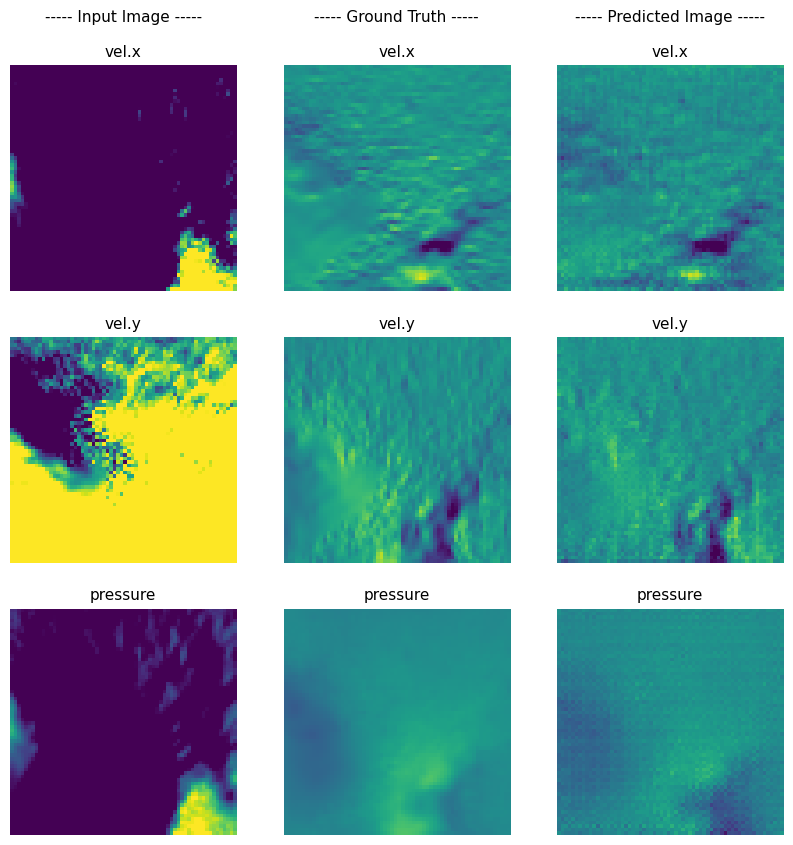

Epoch 125 took 86.69 seconds
Epoch 126, Batch 0:
Generator Loss: 1.2700,  LR: 2.17e-05
Discriminator Loss: 0.0359,  LR: 5.42e-06
Epoch 126, Batch 200:
Generator Loss: 1.2408,  LR: 2.17e-05
Discriminator Loss: 0.0286,  LR: 5.42e-06
Epoch 126, Batch 400:
Generator Loss: 1.0933,  LR: 2.17e-05
Discriminator Loss: 0.0204,  LR: 5.42e-06
Epoch 126, Batch 600:
Generator Loss: 1.4393,  LR: 2.17e-05
Discriminator Loss: 0.0274,  LR: 5.42e-06
Epoch 126 took 86.85 seconds
Epoch 127, Batch 0:
Generator Loss: 1.2151,  LR: 2.17e-05
Discriminator Loss: 0.0486,  LR: 5.42e-06
Epoch 127, Batch 200:
Generator Loss: 1.0205,  LR: 2.17e-05
Discriminator Loss: 0.0871,  LR: 5.42e-06
Epoch 127, Batch 400:
Generator Loss: 0.8444,  LR: 2.17e-05
Discriminator Loss: 0.1052,  LR: 5.42e-06
Epoch 127, Batch 600:
Generator Loss: 0.9034,  LR: 2.17e-05
Discriminator Loss: 0.0839,  LR: 5.42e-06
Epoch 127 took 86.08 seconds
Epoch 128, Batch 0:
Generator Loss: 1.3327,  LR: 2.17e-05
Discriminator Loss: 0.2567,  LR: 5.42e-06
E

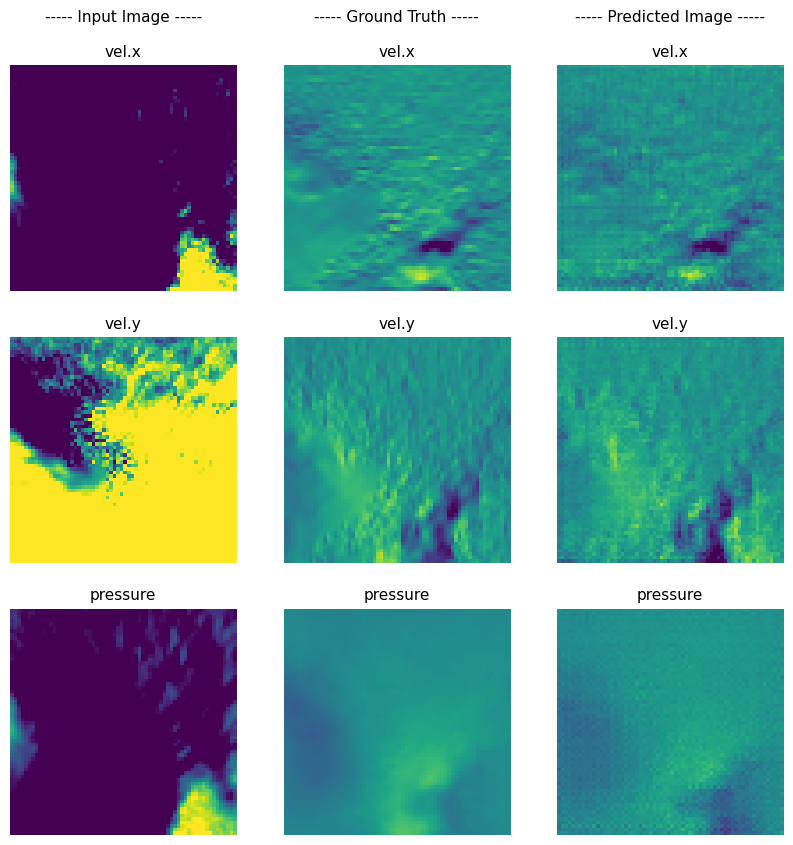

Epoch 130 took 91.77 seconds
Epoch 131, Batch 0:
Generator Loss: 2.6821,  LR: 2.08e-05
Discriminator Loss: 0.0709,  LR: 5.20e-06
Epoch 131, Batch 200:
Generator Loss: 1.3280,  LR: 2.08e-05
Discriminator Loss: 0.0864,  LR: 5.20e-06
Epoch 131, Batch 400:
Generator Loss: 1.1976,  LR: 2.08e-05
Discriminator Loss: 0.0328,  LR: 5.20e-06
Epoch 131, Batch 600:
Generator Loss: 1.2670,  LR: 2.08e-05
Discriminator Loss: 0.0243,  LR: 5.20e-06
Epoch 131 took 86.04 seconds
Epoch 132, Batch 0:
Generator Loss: 1.0781,  LR: 2.08e-05
Discriminator Loss: 0.1113,  LR: 5.20e-06
Epoch 132, Batch 200:
Generator Loss: 0.9943,  LR: 2.08e-05
Discriminator Loss: 0.0618,  LR: 5.20e-06
Epoch 132, Batch 400:
Generator Loss: 1.9194,  LR: 2.08e-05
Discriminator Loss: 0.0339,  LR: 5.20e-06
Epoch 132, Batch 600:
Generator Loss: 1.0801,  LR: 2.08e-05
Discriminator Loss: 0.0291,  LR: 5.20e-06
Epoch 132 took 86.83 seconds
Epoch 133, Batch 0:
Generator Loss: 0.9735,  LR: 2.08e-05
Discriminator Loss: 0.1231,  LR: 5.20e-06
E

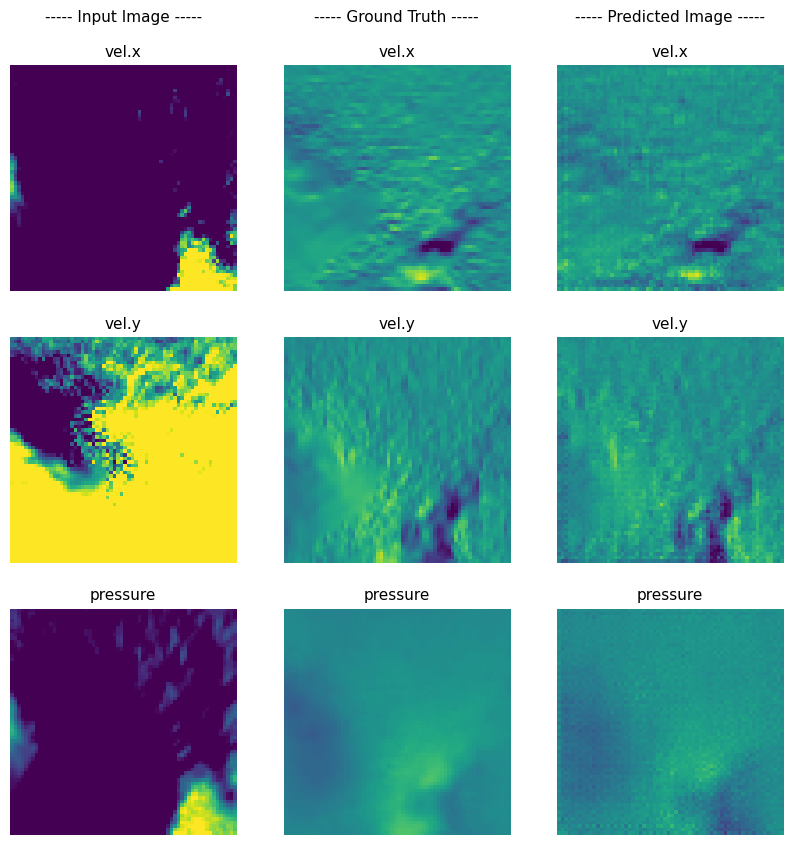

Epoch 135 took 86.99 seconds
Epoch 136, Batch 0:
Generator Loss: 0.9183,  LR: 2.00e-05
Discriminator Loss: 0.1174,  LR: 5.00e-06
Epoch 136, Batch 200:
Generator Loss: 0.9921,  LR: 2.00e-05
Discriminator Loss: 0.0647,  LR: 5.00e-06
Epoch 136, Batch 400:
Generator Loss: 0.9373,  LR: 2.00e-05
Discriminator Loss: 0.0378,  LR: 5.00e-06
Epoch 136, Batch 600:
Generator Loss: 1.2305,  LR: 2.00e-05
Discriminator Loss: 0.1075,  LR: 5.00e-06
Epoch 136 took 85.74 seconds
Epoch 137, Batch 0:
Generator Loss: 1.3193,  LR: 2.00e-05
Discriminator Loss: 0.0886,  LR: 5.00e-06
Epoch 137, Batch 200:
Generator Loss: 1.0123,  LR: 2.00e-05
Discriminator Loss: 0.0704,  LR: 5.00e-06
Epoch 137, Batch 400:
Generator Loss: 2.1724,  LR: 2.00e-05
Discriminator Loss: 0.0515,  LR: 5.00e-06
Epoch 137, Batch 600:
Generator Loss: 1.0493,  LR: 2.00e-05
Discriminator Loss: 0.1074,  LR: 5.00e-06
Epoch 137 took 86.44 seconds
Epoch 138, Batch 0:
Generator Loss: 0.7693,  LR: 2.00e-05
Discriminator Loss: 0.1108,  LR: 5.00e-06
E

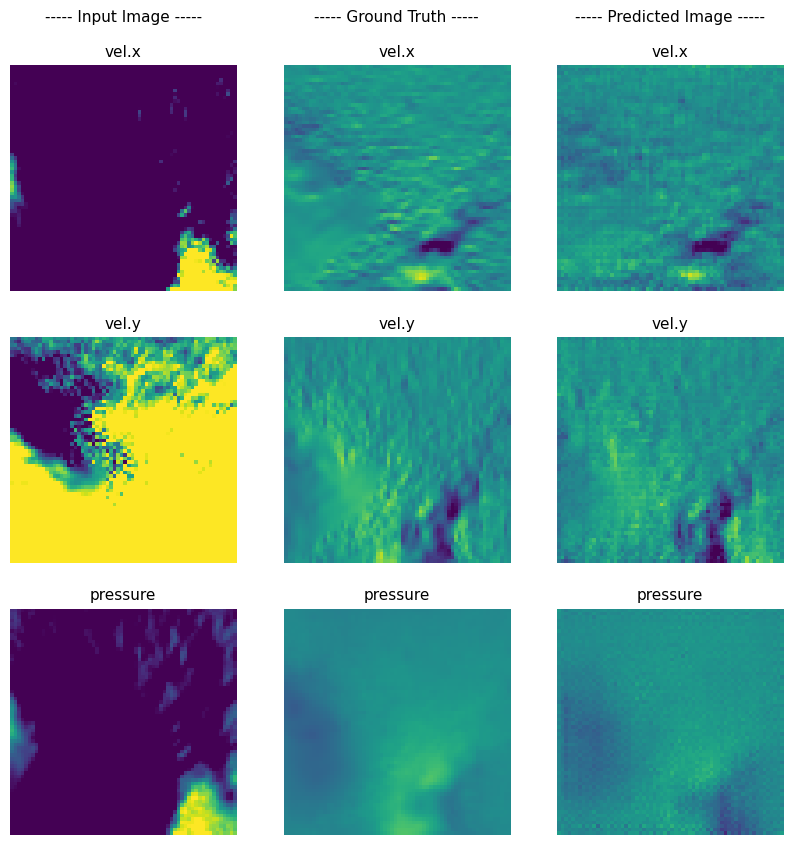

Checkpoint saved for epoch 140
Epoch 140 took 92.52 seconds
Epoch 141, Batch 0:
Generator Loss: 1.9516,  LR: 1.92e-05
Discriminator Loss: 0.1200,  LR: 4.80e-06
Epoch 141, Batch 200:
Generator Loss: 1.6052,  LR: 1.92e-05
Discriminator Loss: 0.0239,  LR: 4.80e-06
Epoch 141, Batch 400:
Generator Loss: 1.0607,  LR: 1.92e-05
Discriminator Loss: 0.0540,  LR: 4.80e-06
Epoch 141, Batch 600:
Generator Loss: 1.2968,  LR: 1.92e-05
Discriminator Loss: 0.1088,  LR: 4.80e-06
Epoch 141 took 86.34 seconds
Epoch 142, Batch 0:
Generator Loss: 1.0803,  LR: 1.92e-05
Discriminator Loss: 0.0275,  LR: 4.80e-06
Epoch 142, Batch 200:
Generator Loss: 1.1217,  LR: 1.92e-05
Discriminator Loss: 0.0376,  LR: 4.80e-06
Epoch 142, Batch 400:
Generator Loss: 1.1529,  LR: 1.92e-05
Discriminator Loss: 0.0243,  LR: 4.80e-06
Epoch 142, Batch 600:
Generator Loss: 1.1264,  LR: 1.92e-05
Discriminator Loss: 0.0256,  LR: 4.80e-06
Epoch 142 took 86.22 seconds
Epoch 143, Batch 0:
Generator Loss: 1.3519,  LR: 1.92e-05
Discriminato

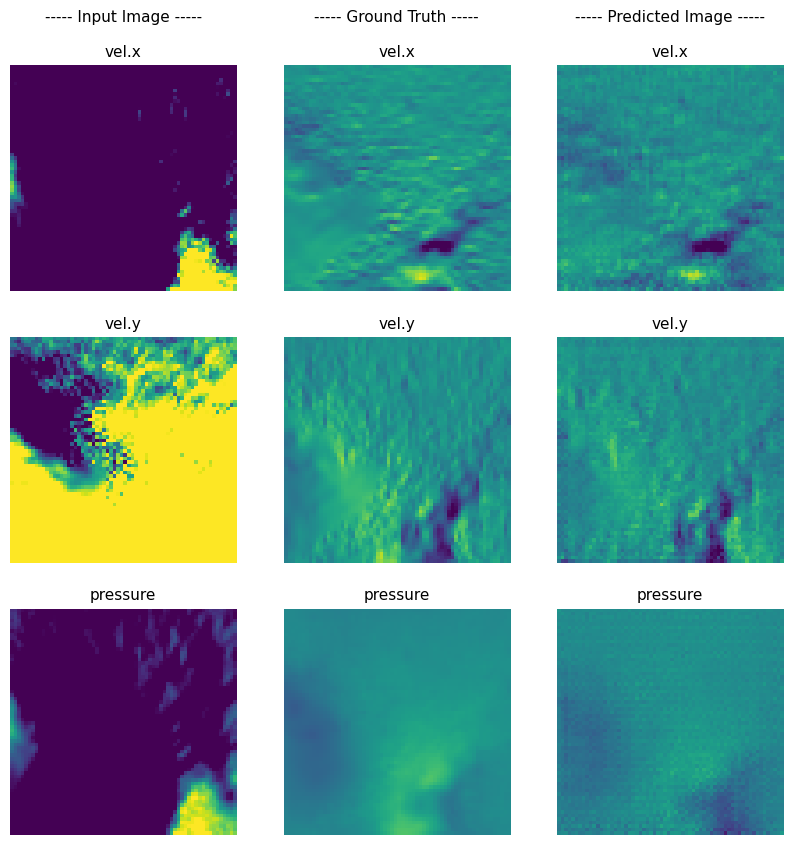

Epoch 145 took 86.61 seconds
Epoch 146, Batch 0:
Generator Loss: 1.1611,  LR: 1.84e-05
Discriminator Loss: 0.0383,  LR: 4.61e-06
Epoch 146, Batch 200:
Generator Loss: 1.1106,  LR: 1.84e-05
Discriminator Loss: 0.0725,  LR: 4.61e-06
Epoch 146, Batch 400:
Generator Loss: 0.9415,  LR: 1.84e-05
Discriminator Loss: 0.0571,  LR: 4.61e-06
Epoch 146, Batch 600:
Generator Loss: 1.1520,  LR: 1.84e-05
Discriminator Loss: 0.0261,  LR: 4.61e-06
Epoch 146 took 86.18 seconds
Epoch 147, Batch 0:
Generator Loss: 1.0909,  LR: 1.84e-05
Discriminator Loss: 0.0844,  LR: 4.61e-06
Epoch 147, Batch 200:
Generator Loss: 0.9840,  LR: 1.84e-05
Discriminator Loss: 0.0761,  LR: 4.61e-06
Epoch 147, Batch 400:
Generator Loss: 0.9962,  LR: 1.84e-05
Discriminator Loss: 0.0420,  LR: 4.61e-06
Epoch 147, Batch 600:
Generator Loss: 0.9757,  LR: 1.84e-05
Discriminator Loss: 0.1095,  LR: 4.61e-06
Epoch 147 took 85.91 seconds
Epoch 148, Batch 0:
Generator Loss: 0.9657,  LR: 1.84e-05
Discriminator Loss: 0.0620,  LR: 4.61e-06
E

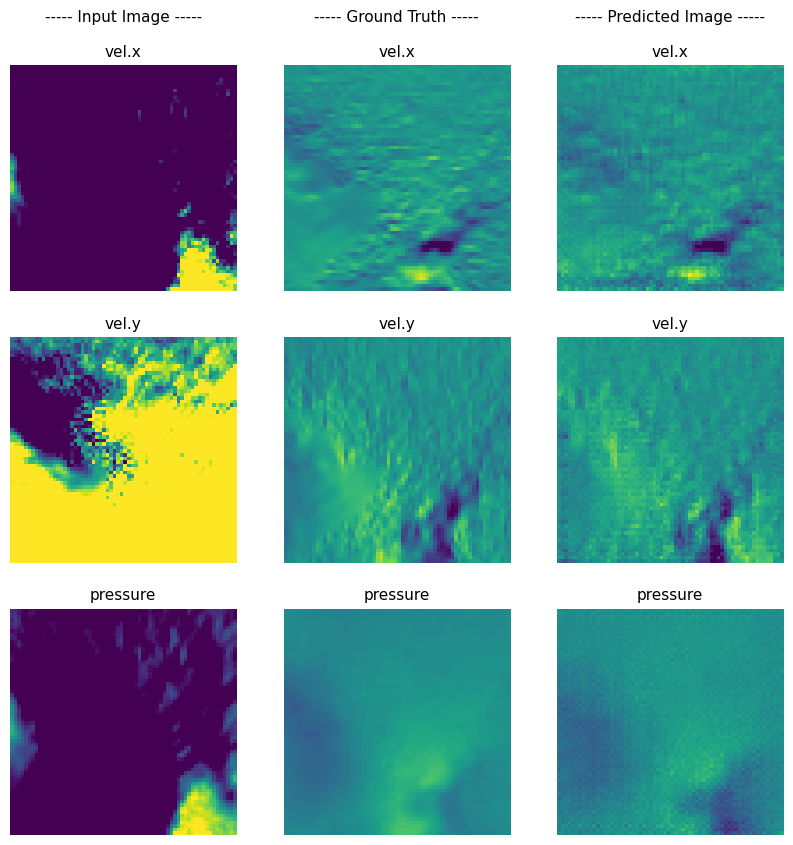

Epoch 150 took 92.34 seconds
Epoch 151, Batch 0:
Generator Loss: 2.2398,  LR: 1.77e-05
Discriminator Loss: 2.6873,  LR: 4.43e-06
Epoch 151, Batch 200:
Generator Loss: 0.9104,  LR: 1.77e-05
Discriminator Loss: 0.1187,  LR: 4.43e-06
Epoch 151, Batch 400:
Generator Loss: 1.0484,  LR: 1.77e-05
Discriminator Loss: 0.0449,  LR: 4.43e-06
Epoch 151, Batch 600:
Generator Loss: 1.1931,  LR: 1.77e-05
Discriminator Loss: 0.0883,  LR: 4.43e-06
Epoch 151 took 85.90 seconds
Epoch 152, Batch 0:
Generator Loss: 1.3019,  LR: 1.77e-05
Discriminator Loss: 0.0570,  LR: 4.43e-06
Epoch 152, Batch 200:
Generator Loss: 1.0717,  LR: 1.77e-05
Discriminator Loss: 0.0262,  LR: 4.43e-06
Epoch 152, Batch 400:
Generator Loss: 1.3740,  LR: 1.77e-05
Discriminator Loss: 0.0627,  LR: 4.43e-06
Epoch 152, Batch 600:
Generator Loss: 1.2049,  LR: 1.77e-05
Discriminator Loss: 0.0196,  LR: 4.43e-06
Epoch 152 took 85.98 seconds
Epoch 153, Batch 0:
Generator Loss: 0.9669,  LR: 1.77e-05
Discriminator Loss: 0.0310,  LR: 4.43e-06
E

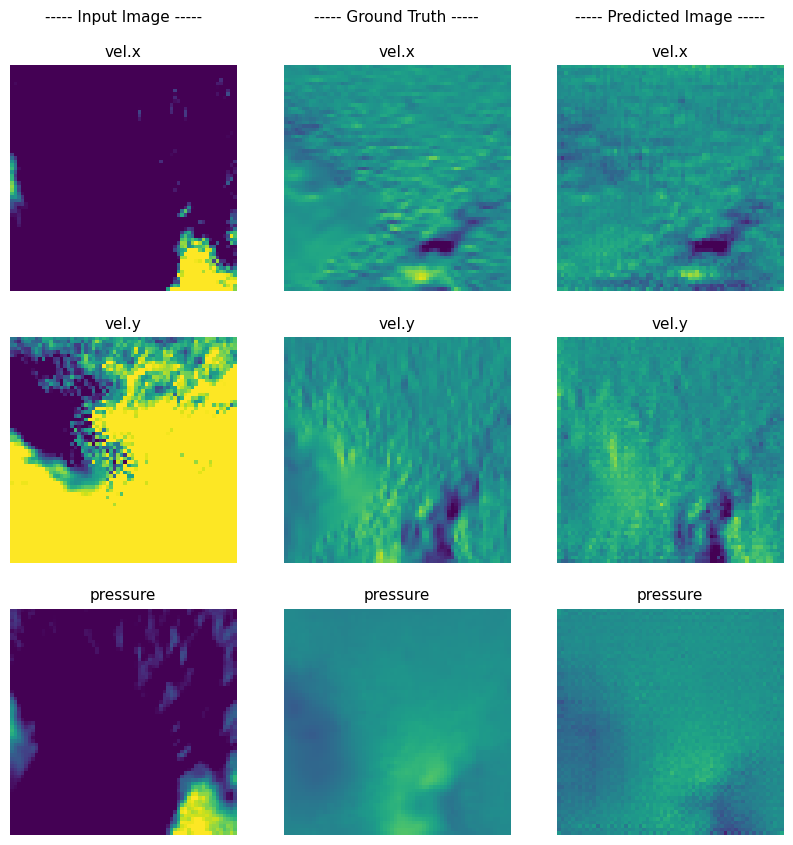

Epoch 155 took 86.83 seconds
Epoch 156, Batch 0:
Generator Loss: 0.9476,  LR: 1.70e-05
Discriminator Loss: 0.0390,  LR: 4.25e-06
Epoch 156, Batch 200:
Generator Loss: 0.9732,  LR: 1.70e-05
Discriminator Loss: 0.0368,  LR: 4.25e-06
Epoch 156, Batch 400:
Generator Loss: 1.2348,  LR: 1.70e-05
Discriminator Loss: 0.0287,  LR: 4.25e-06
Epoch 156, Batch 600:
Generator Loss: 1.0118,  LR: 1.70e-05
Discriminator Loss: 0.0910,  LR: 4.25e-06
Epoch 156 took 86.20 seconds
Epoch 157, Batch 0:
Generator Loss: 1.3513,  LR: 1.70e-05
Discriminator Loss: 0.0230,  LR: 4.25e-06
Epoch 157, Batch 200:
Generator Loss: 1.1268,  LR: 1.70e-05
Discriminator Loss: 0.0414,  LR: 4.25e-06
Epoch 157, Batch 400:
Generator Loss: 0.9013,  LR: 1.70e-05
Discriminator Loss: 0.0380,  LR: 4.25e-06
Epoch 157, Batch 600:
Generator Loss: 1.2100,  LR: 1.70e-05
Discriminator Loss: 0.0669,  LR: 4.25e-06
Epoch 157 took 86.48 seconds
Epoch 158, Batch 0:
Generator Loss: 1.1071,  LR: 1.70e-05
Discriminator Loss: 0.0369,  LR: 4.25e-06
E

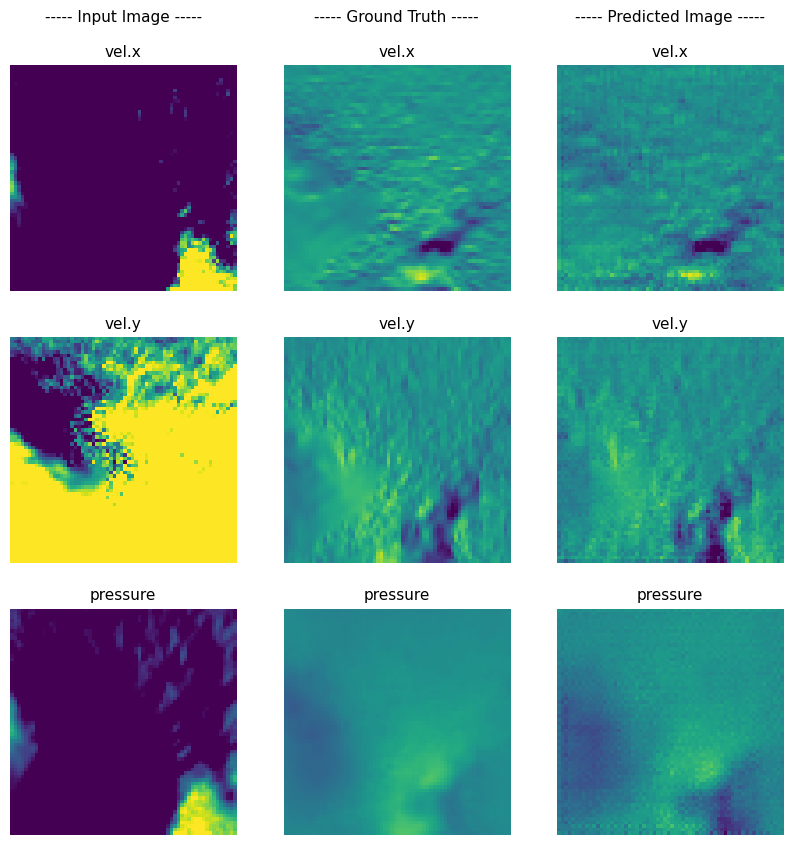

Checkpoint saved for epoch 160
Epoch 160 took 92.65 seconds
Epoch 161, Batch 0:
Generator Loss: 2.3704,  LR: 1.63e-05
Discriminator Loss: 0.1478,  LR: 4.08e-06
Epoch 161, Batch 200:
Generator Loss: 1.3914,  LR: 1.63e-05
Discriminator Loss: 0.0408,  LR: 4.08e-06
Epoch 161, Batch 400:
Generator Loss: 1.0217,  LR: 1.63e-05
Discriminator Loss: 0.0590,  LR: 4.08e-06
Epoch 161, Batch 600:
Generator Loss: 1.0217,  LR: 1.63e-05
Discriminator Loss: 0.0640,  LR: 4.08e-06
Epoch 161 took 86.28 seconds
Epoch 162, Batch 0:
Generator Loss: 1.7565,  LR: 1.63e-05
Discriminator Loss: 0.0992,  LR: 4.08e-06
Epoch 162, Batch 200:
Generator Loss: 1.3631,  LR: 1.63e-05
Discriminator Loss: 0.0912,  LR: 4.08e-06
Epoch 162, Batch 400:
Generator Loss: 1.0942,  LR: 1.63e-05
Discriminator Loss: 0.0963,  LR: 4.08e-06
Epoch 162, Batch 600:
Generator Loss: 1.3384,  LR: 1.63e-05
Discriminator Loss: 0.0187,  LR: 4.08e-06
Epoch 162 took 86.25 seconds
Epoch 163, Batch 0:
Generator Loss: 0.8508,  LR: 1.63e-05
Discriminato

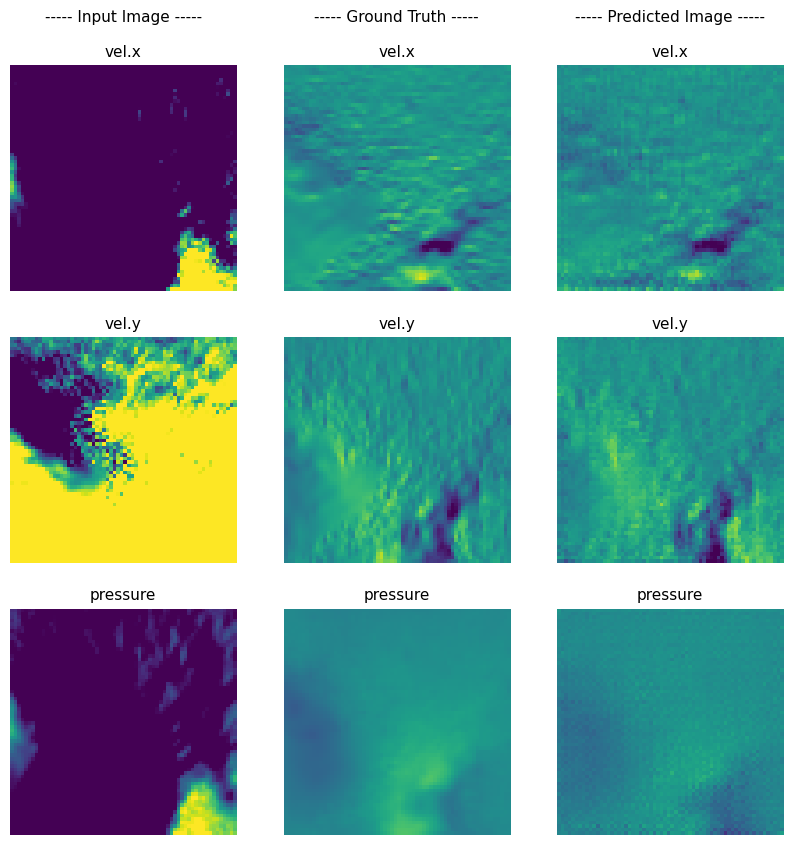

Epoch 165 took 86.58 seconds
Epoch 166, Batch 0:
Generator Loss: 1.1865,  LR: 1.57e-05
Discriminator Loss: 0.0779,  LR: 3.92e-06
Epoch 166, Batch 200:
Generator Loss: 1.1123,  LR: 1.57e-05
Discriminator Loss: 0.0547,  LR: 3.92e-06
Epoch 166, Batch 400:
Generator Loss: 1.5445,  LR: 1.57e-05
Discriminator Loss: 0.0784,  LR: 3.92e-06
Epoch 166, Batch 600:
Generator Loss: 1.0172,  LR: 1.57e-05
Discriminator Loss: 0.0641,  LR: 3.92e-06
Epoch 166 took 86.31 seconds
Epoch 167, Batch 0:
Generator Loss: 0.8403,  LR: 1.57e-05
Discriminator Loss: 0.0854,  LR: 3.92e-06
Epoch 167, Batch 200:
Generator Loss: 1.0684,  LR: 1.57e-05
Discriminator Loss: 0.0616,  LR: 3.92e-06
Epoch 167, Batch 400:
Generator Loss: 1.3577,  LR: 1.57e-05
Discriminator Loss: 0.0628,  LR: 3.92e-06
Epoch 167, Batch 600:
Generator Loss: 1.0826,  LR: 1.57e-05
Discriminator Loss: 0.0681,  LR: 3.92e-06
Epoch 167 took 86.40 seconds
Epoch 168, Batch 0:
Generator Loss: 1.0515,  LR: 1.57e-05
Discriminator Loss: 0.0438,  LR: 3.92e-06
E

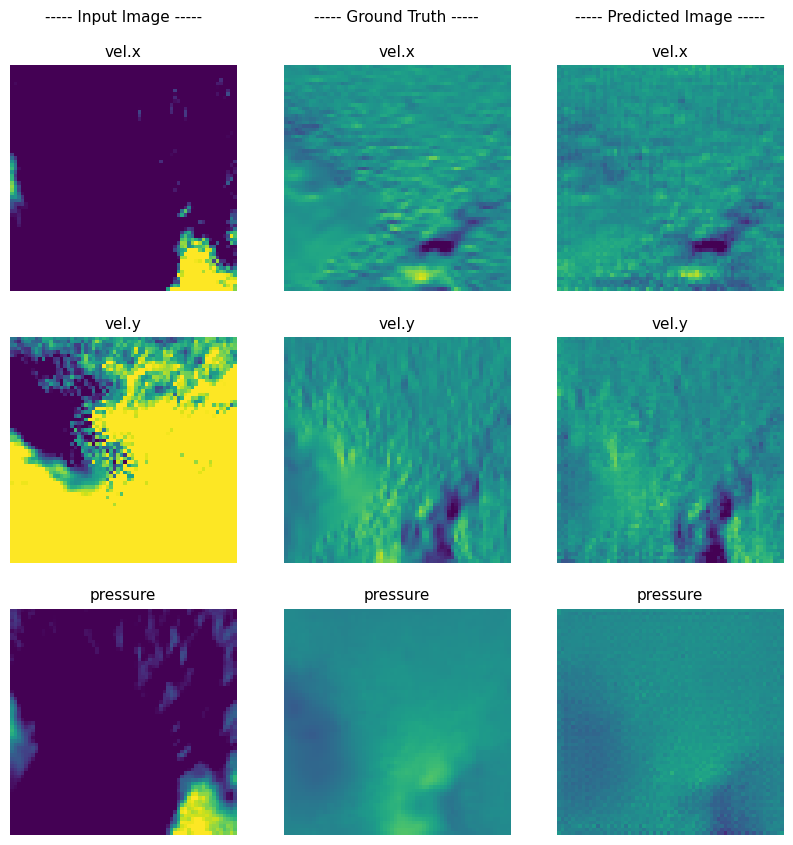

Epoch 170 took 92.04 seconds
Epoch 171, Batch 0:
Generator Loss: 2.1903,  LR: 1.51e-05
Discriminator Loss: 0.0677,  LR: 3.77e-06
Epoch 171, Batch 200:
Generator Loss: 1.0750,  LR: 1.51e-05
Discriminator Loss: 0.0582,  LR: 3.77e-06
Epoch 171, Batch 400:
Generator Loss: 1.2323,  LR: 1.51e-05
Discriminator Loss: 0.0790,  LR: 3.77e-06
Epoch 171, Batch 600:
Generator Loss: 1.1779,  LR: 1.51e-05
Discriminator Loss: 0.0627,  LR: 3.77e-06
Epoch 171 took 86.54 seconds
Epoch 172, Batch 0:
Generator Loss: 0.8579,  LR: 1.51e-05
Discriminator Loss: 0.1276,  LR: 3.77e-06
Epoch 172, Batch 200:
Generator Loss: 1.7541,  LR: 1.51e-05
Discriminator Loss: 0.0367,  LR: 3.77e-06
Epoch 172, Batch 400:
Generator Loss: 0.9891,  LR: 1.51e-05
Discriminator Loss: 0.0200,  LR: 3.77e-06
Epoch 172, Batch 600:
Generator Loss: 0.8549,  LR: 1.51e-05
Discriminator Loss: 0.0983,  LR: 3.77e-06
Epoch 172 took 86.66 seconds
Epoch 173, Batch 0:
Generator Loss: 1.1689,  LR: 1.51e-05
Discriminator Loss: 0.0724,  LR: 3.77e-06
E

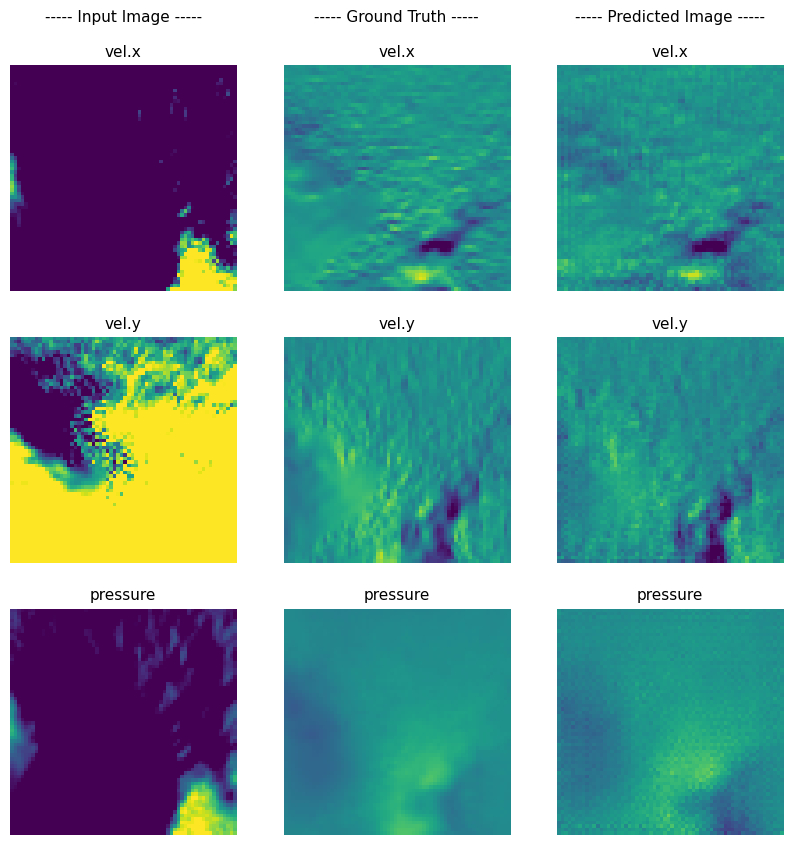

Epoch 175 took 86.45 seconds
Epoch 176, Batch 0:
Generator Loss: 1.0745,  LR: 1.45e-05
Discriminator Loss: 0.0180,  LR: 3.62e-06
Epoch 176, Batch 200:
Generator Loss: 1.3236,  LR: 1.45e-05
Discriminator Loss: 0.0473,  LR: 3.62e-06
Epoch 176, Batch 400:
Generator Loss: 1.0613,  LR: 1.45e-05
Discriminator Loss: 0.0736,  LR: 3.62e-06
Epoch 176, Batch 600:
Generator Loss: 1.5077,  LR: 1.45e-05
Discriminator Loss: 0.0668,  LR: 3.62e-06
Epoch 176 took 86.31 seconds
Epoch 177, Batch 0:
Generator Loss: 1.0522,  LR: 1.45e-05
Discriminator Loss: 0.5728,  LR: 3.62e-06
Epoch 177, Batch 200:
Generator Loss: 0.8716,  LR: 1.45e-05
Discriminator Loss: 0.1107,  LR: 3.62e-06
Epoch 177, Batch 400:
Generator Loss: 0.8754,  LR: 1.45e-05
Discriminator Loss: 0.1323,  LR: 3.62e-06
Epoch 177, Batch 600:
Generator Loss: 0.9791,  LR: 1.45e-05
Discriminator Loss: 0.0278,  LR: 3.62e-06
Epoch 177 took 86.49 seconds
Epoch 178, Batch 0:
Generator Loss: 1.5443,  LR: 1.45e-05
Discriminator Loss: 0.0976,  LR: 3.62e-06
E

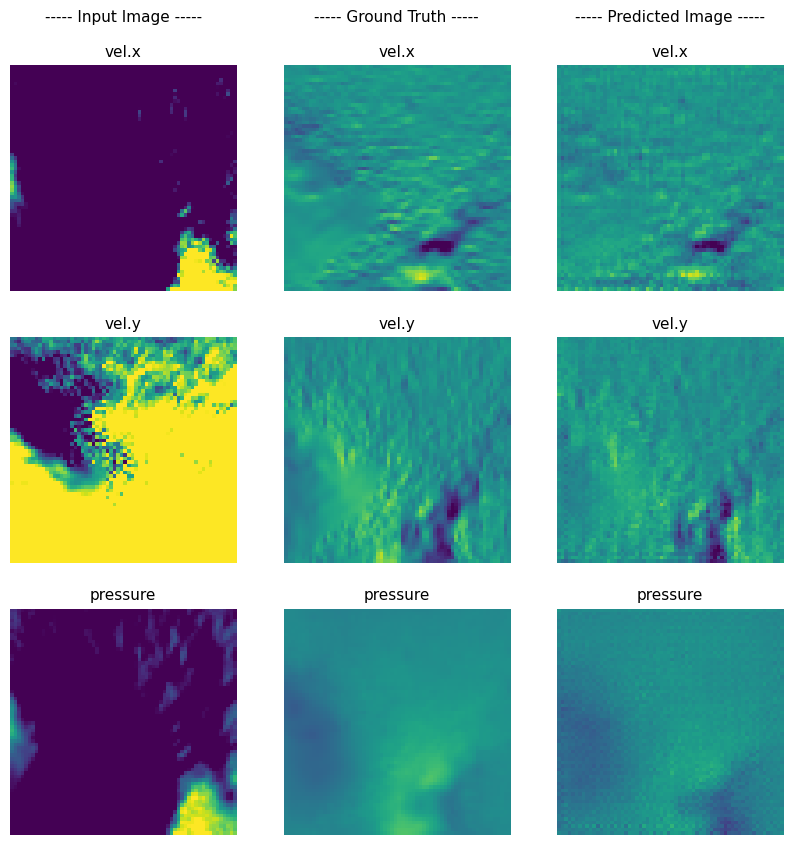

Checkpoint saved for epoch 180
Epoch 180 took 92.51 seconds
Epoch 181, Batch 0:
Generator Loss: 2.7891,  LR: 1.39e-05
Discriminator Loss: 0.1722,  LR: 3.47e-06
Epoch 181, Batch 200:
Generator Loss: 1.0520,  LR: 1.39e-05
Discriminator Loss: 0.0371,  LR: 3.47e-06
Epoch 181, Batch 400:
Generator Loss: 0.9169,  LR: 1.39e-05
Discriminator Loss: 0.0777,  LR: 3.47e-06
Epoch 181, Batch 600:
Generator Loss: 0.8194,  LR: 1.39e-05
Discriminator Loss: 0.0730,  LR: 3.47e-06
Epoch 181 took 86.24 seconds
Epoch 182, Batch 0:
Generator Loss: 1.7214,  LR: 1.39e-05
Discriminator Loss: 0.0921,  LR: 3.47e-06
Epoch 182, Batch 200:
Generator Loss: 0.9546,  LR: 1.39e-05
Discriminator Loss: 0.0387,  LR: 3.47e-06
Epoch 182, Batch 400:
Generator Loss: 1.2922,  LR: 1.39e-05
Discriminator Loss: 0.0381,  LR: 3.47e-06
Epoch 182, Batch 600:
Generator Loss: 1.3305,  LR: 1.39e-05
Discriminator Loss: 0.0162,  LR: 3.47e-06
Epoch 182 took 86.14 seconds
Epoch 183, Batch 0:
Generator Loss: 1.3080,  LR: 1.39e-05
Discriminato

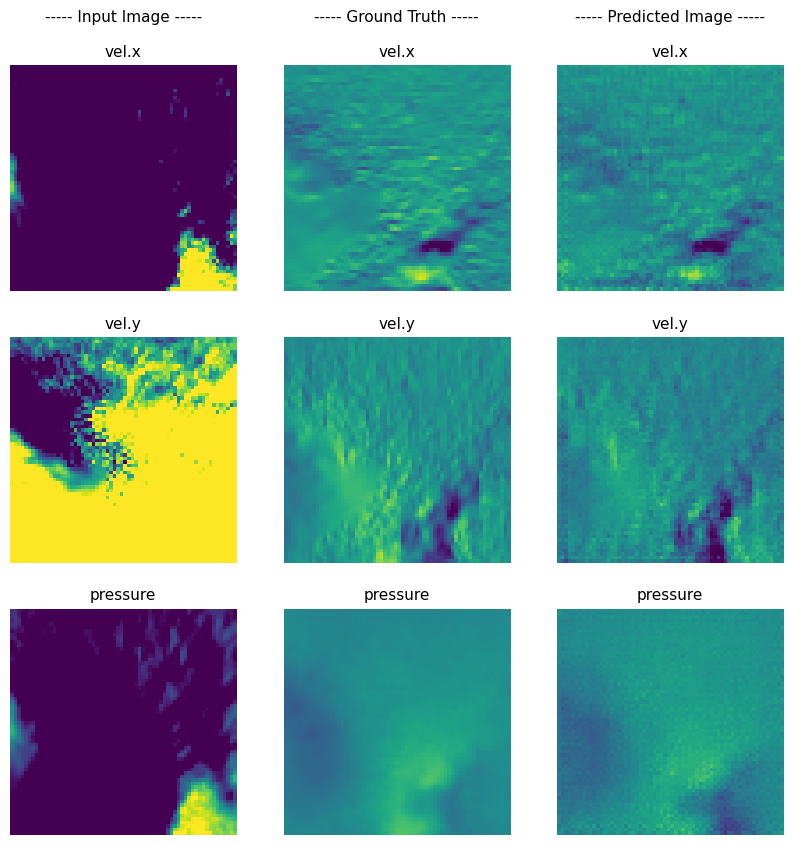

Epoch 185 took 86.42 seconds
Epoch 186, Batch 0:
Generator Loss: 0.9918,  LR: 1.33e-05
Discriminator Loss: 0.0917,  LR: 3.34e-06
Epoch 186, Batch 200:
Generator Loss: 0.9689,  LR: 1.33e-05
Discriminator Loss: 0.0200,  LR: 3.34e-06
Epoch 186, Batch 400:
Generator Loss: 0.9194,  LR: 1.33e-05
Discriminator Loss: 0.0246,  LR: 3.34e-06
Epoch 186, Batch 600:
Generator Loss: 1.0401,  LR: 1.33e-05
Discriminator Loss: 0.0338,  LR: 3.34e-06
Epoch 186 took 86.23 seconds
Epoch 187, Batch 0:
Generator Loss: 1.6525,  LR: 1.33e-05
Discriminator Loss: 0.0492,  LR: 3.34e-06
Epoch 187, Batch 200:
Generator Loss: 1.2415,  LR: 1.33e-05
Discriminator Loss: 0.0451,  LR: 3.34e-06
Epoch 187, Batch 400:
Generator Loss: 0.9075,  LR: 1.33e-05
Discriminator Loss: 0.0524,  LR: 3.34e-06
Epoch 187, Batch 600:
Generator Loss: 1.3542,  LR: 1.33e-05
Discriminator Loss: 0.0861,  LR: 3.34e-06
Epoch 187 took 86.04 seconds
Epoch 188, Batch 0:
Generator Loss: 1.0124,  LR: 1.33e-05
Discriminator Loss: 0.0372,  LR: 3.34e-06
E

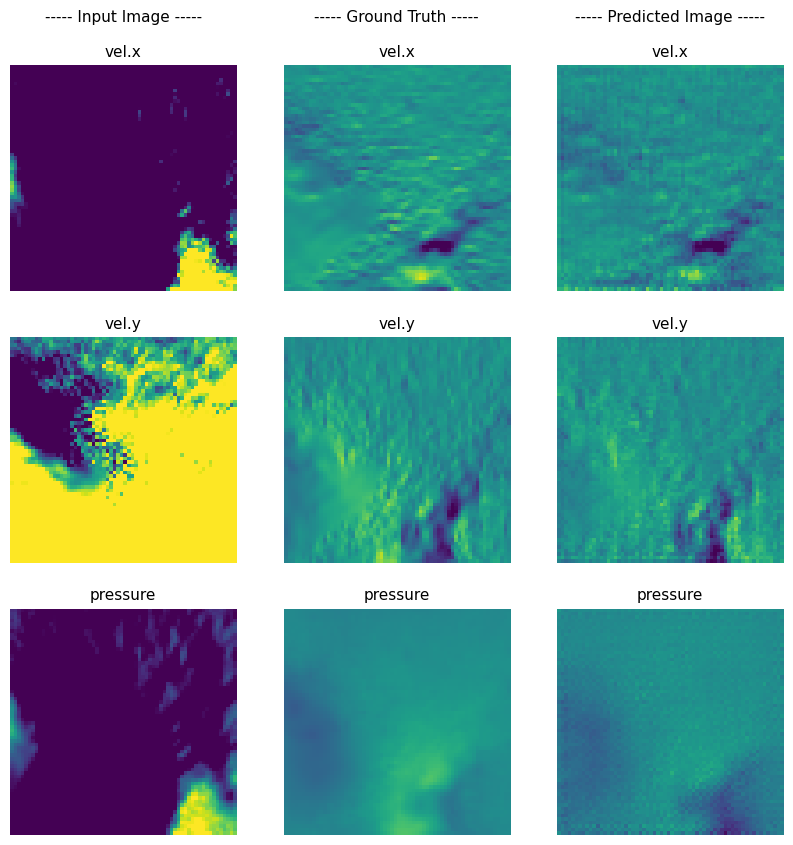

Epoch 190 took 91.74 seconds
Epoch 191, Batch 0:
Generator Loss: 2.3635,  LR: 1.28e-05
Discriminator Loss: 0.3568,  LR: 3.20e-06
Epoch 191, Batch 200:
Generator Loss: 0.9493,  LR: 1.28e-05
Discriminator Loss: 0.1017,  LR: 3.20e-06
Epoch 191, Batch 400:
Generator Loss: 1.3206,  LR: 1.28e-05
Discriminator Loss: 0.0464,  LR: 3.20e-06
Epoch 191, Batch 600:
Generator Loss: 1.0096,  LR: 1.28e-05
Discriminator Loss: 0.0872,  LR: 3.20e-06
Epoch 191 took 86.06 seconds
Epoch 192, Batch 0:
Generator Loss: 1.0502,  LR: 1.28e-05
Discriminator Loss: 0.0886,  LR: 3.20e-06
Epoch 192, Batch 200:
Generator Loss: 0.8301,  LR: 1.28e-05
Discriminator Loss: 0.1361,  LR: 3.20e-06
Epoch 192, Batch 400:
Generator Loss: 1.0761,  LR: 1.28e-05
Discriminator Loss: 0.0320,  LR: 3.20e-06
Epoch 192, Batch 600:
Generator Loss: 1.0424,  LR: 1.28e-05
Discriminator Loss: 0.0318,  LR: 3.20e-06
Epoch 192 took 86.24 seconds
Epoch 193, Batch 0:
Generator Loss: 1.5104,  LR: 1.28e-05
Discriminator Loss: 0.1315,  LR: 3.20e-06
E

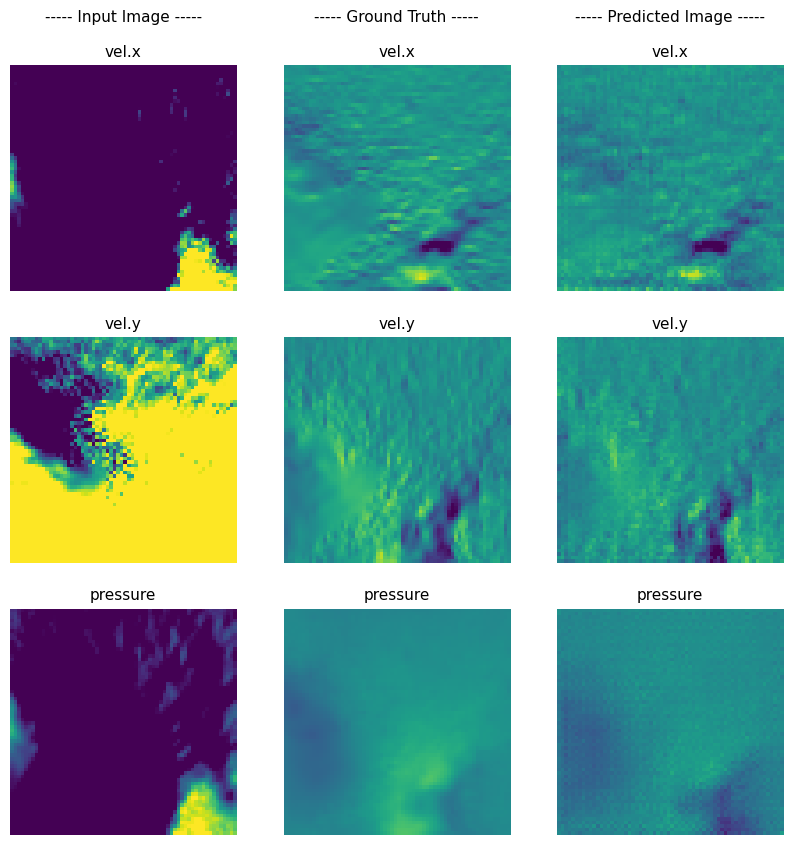

Epoch 195 took 86.58 seconds
Epoch 196, Batch 0:
Generator Loss: 1.1981,  LR: 1.23e-05
Discriminator Loss: 0.0185,  LR: 3.08e-06
Epoch 196, Batch 200:
Generator Loss: 0.9946,  LR: 1.23e-05
Discriminator Loss: 0.0397,  LR: 3.08e-06
Epoch 196, Batch 400:
Generator Loss: 1.0188,  LR: 1.23e-05
Discriminator Loss: 0.0400,  LR: 3.08e-06
Epoch 196, Batch 600:
Generator Loss: 1.1758,  LR: 1.23e-05
Discriminator Loss: 0.0620,  LR: 3.08e-06
Epoch 196 took 86.39 seconds
Epoch 197, Batch 0:
Generator Loss: 1.4314,  LR: 1.23e-05
Discriminator Loss: 0.0271,  LR: 3.08e-06
Epoch 197, Batch 200:
Generator Loss: 0.9437,  LR: 1.23e-05
Discriminator Loss: 0.0672,  LR: 3.08e-06
Epoch 197, Batch 400:
Generator Loss: 0.7978,  LR: 1.23e-05
Discriminator Loss: 0.1267,  LR: 3.08e-06
Epoch 197, Batch 600:
Generator Loss: 1.1117,  LR: 1.23e-05
Discriminator Loss: 0.1389,  LR: 3.08e-06
Epoch 197 took 86.14 seconds
Epoch 198, Batch 0:
Generator Loss: 1.5801,  LR: 1.23e-05
Discriminator Loss: 0.0464,  LR: 3.08e-06
E

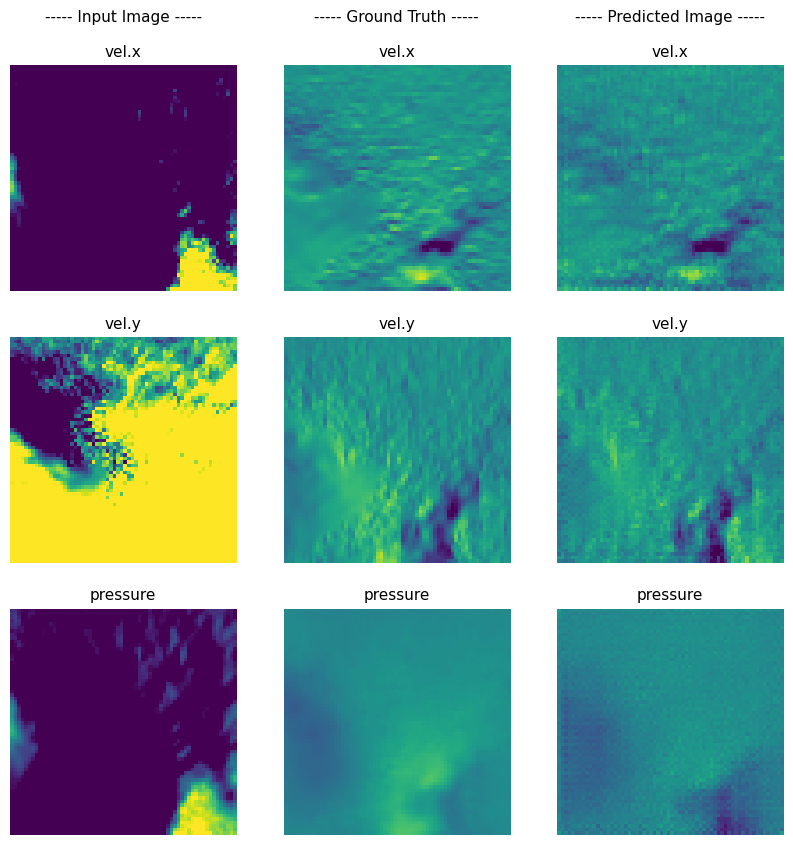

Checkpoint saved for epoch 200
Epoch 200 took 92.91 seconds
Epoch 201, Batch 0:
Generator Loss: 1.9909,  LR: 1.18e-05
Discriminator Loss: 0.0838,  LR: 2.96e-06
Epoch 201, Batch 200:
Generator Loss: 1.2450,  LR: 1.18e-05
Discriminator Loss: 0.0331,  LR: 2.96e-06
Epoch 201, Batch 400:
Generator Loss: 1.3471,  LR: 1.18e-05
Discriminator Loss: 0.0432,  LR: 2.96e-06
Epoch 201, Batch 600:
Generator Loss: 0.9456,  LR: 1.18e-05
Discriminator Loss: 0.0983,  LR: 2.96e-06
Epoch 201 took 86.32 seconds
Epoch 202, Batch 0:
Generator Loss: 1.0641,  LR: 1.18e-05
Discriminator Loss: 0.0659,  LR: 2.96e-06
Epoch 202, Batch 200:
Generator Loss: 1.8452,  LR: 1.18e-05
Discriminator Loss: 0.0220,  LR: 2.96e-06
Epoch 202, Batch 400:
Generator Loss: 1.1992,  LR: 1.18e-05
Discriminator Loss: 0.0410,  LR: 2.96e-06
Epoch 202, Batch 600:
Generator Loss: 1.2610,  LR: 1.18e-05
Discriminator Loss: 0.0387,  LR: 2.96e-06
Epoch 202 took 86.44 seconds
Epoch 203, Batch 0:
Generator Loss: 0.9364,  LR: 1.18e-05
Discriminato

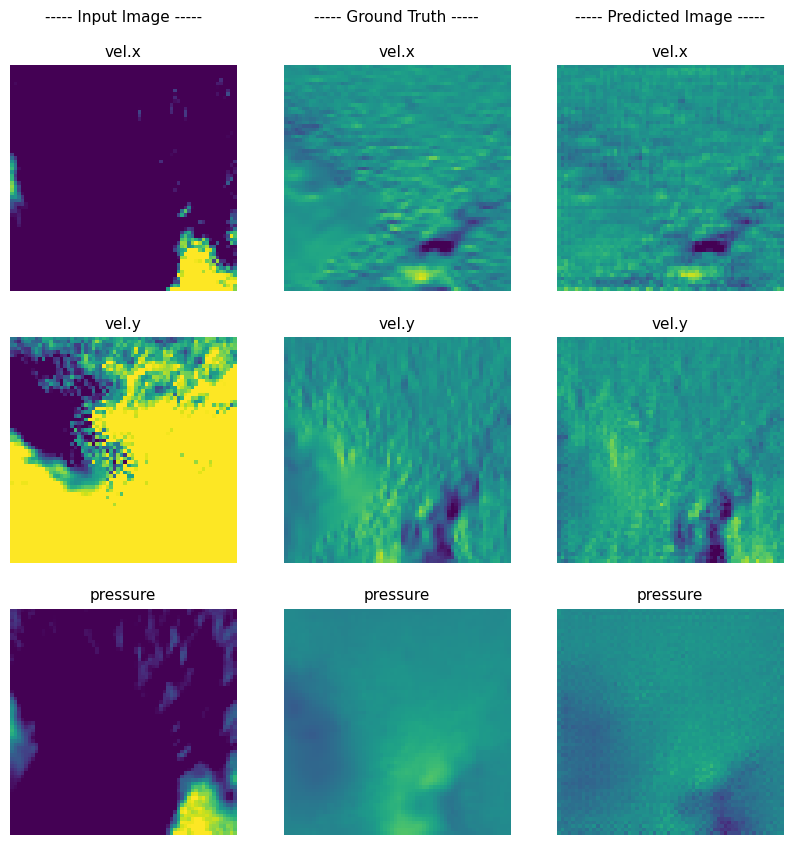

Epoch 205 took 86.43 seconds
Epoch 206, Batch 0:
Generator Loss: 1.9214,  LR: 1.14e-05
Discriminator Loss: 0.0261,  LR: 2.84e-06
Epoch 206, Batch 200:
Generator Loss: 1.0023,  LR: 1.14e-05
Discriminator Loss: 0.0355,  LR: 2.84e-06
Epoch 206, Batch 400:
Generator Loss: 1.1795,  LR: 1.14e-05
Discriminator Loss: 0.0366,  LR: 2.84e-06
Epoch 206, Batch 600:
Generator Loss: 1.3866,  LR: 1.14e-05
Discriminator Loss: 0.0850,  LR: 2.84e-06
Epoch 206 took 86.18 seconds
Epoch 207, Batch 0:
Generator Loss: 1.0634,  LR: 1.14e-05
Discriminator Loss: 0.0742,  LR: 2.84e-06
Epoch 207, Batch 200:
Generator Loss: 0.8313,  LR: 1.14e-05
Discriminator Loss: 0.0707,  LR: 2.84e-06
Epoch 207, Batch 400:
Generator Loss: 1.0453,  LR: 1.14e-05
Discriminator Loss: 0.0630,  LR: 2.84e-06
Epoch 207, Batch 600:
Generator Loss: 1.2175,  LR: 1.14e-05
Discriminator Loss: 0.0443,  LR: 2.84e-06
Epoch 207 took 86.06 seconds
Epoch 208, Batch 0:
Generator Loss: 0.9428,  LR: 1.14e-05
Discriminator Loss: 0.0429,  LR: 2.84e-06
E

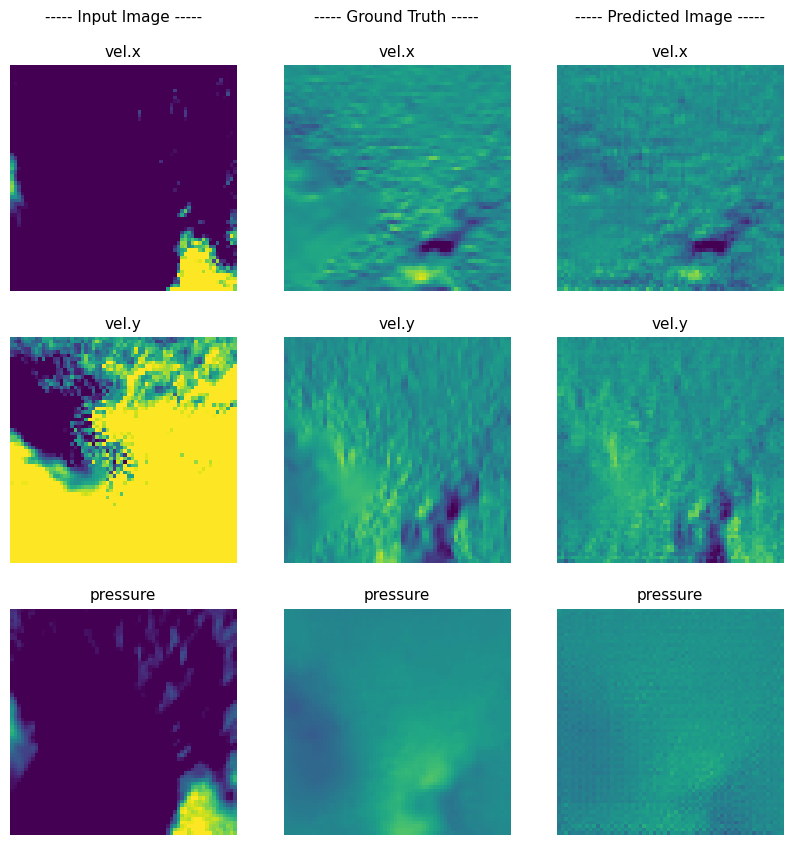

Epoch 210 took 91.69 seconds
Epoch 211, Batch 0:
Generator Loss: 2.1861,  LR: 1.09e-05
Discriminator Loss: 1.3299,  LR: 2.73e-06
Epoch 211, Batch 200:
Generator Loss: 1.1201,  LR: 1.09e-05
Discriminator Loss: 0.0457,  LR: 2.73e-06
Epoch 211, Batch 400:
Generator Loss: 1.2283,  LR: 1.09e-05
Discriminator Loss: 0.0342,  LR: 2.73e-06
Epoch 211, Batch 600:
Generator Loss: 0.8044,  LR: 1.09e-05
Discriminator Loss: 0.1422,  LR: 2.73e-06
Epoch 211 took 86.28 seconds
Epoch 212, Batch 0:
Generator Loss: 1.0963,  LR: 1.09e-05
Discriminator Loss: 0.0433,  LR: 2.73e-06
Epoch 212, Batch 200:
Generator Loss: 1.0822,  LR: 1.09e-05
Discriminator Loss: 0.0795,  LR: 2.73e-06
Epoch 212, Batch 400:
Generator Loss: 1.0761,  LR: 1.09e-05
Discriminator Loss: 0.0951,  LR: 2.73e-06
Epoch 212, Batch 600:
Generator Loss: 1.3916,  LR: 1.09e-05
Discriminator Loss: 0.0284,  LR: 2.73e-06
Epoch 212 took 86.47 seconds
Epoch 213, Batch 0:
Generator Loss: 0.8489,  LR: 1.09e-05
Discriminator Loss: 0.0497,  LR: 2.73e-06
E

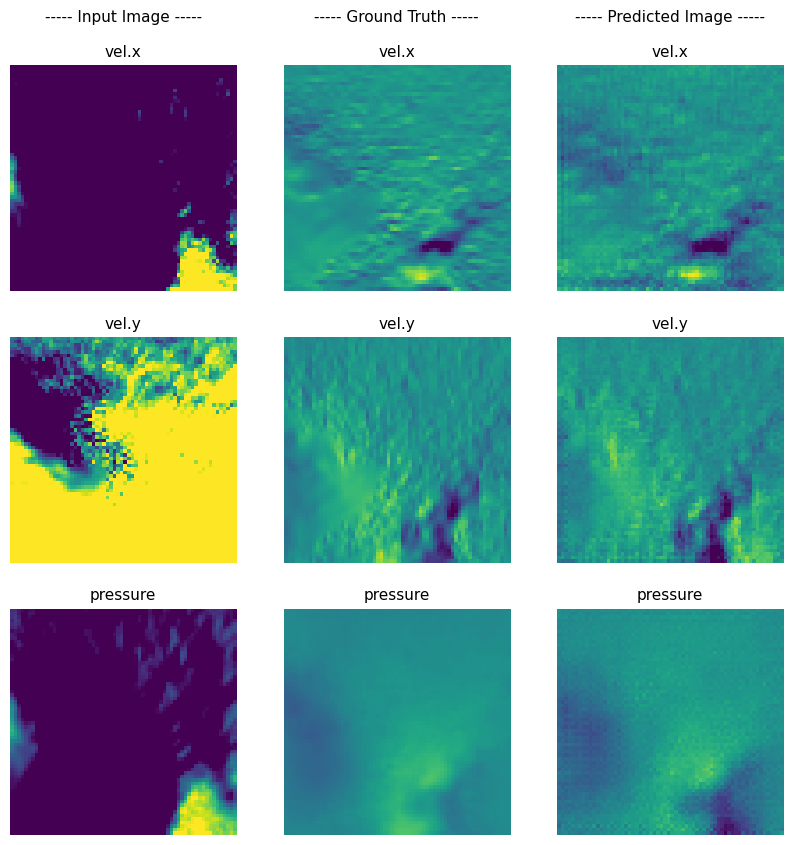

Epoch 215 took 86.62 seconds
Epoch 216, Batch 0:
Generator Loss: 0.7886,  LR: 1.05e-05
Discriminator Loss: 0.0955,  LR: 2.62e-06
Epoch 216, Batch 200:
Generator Loss: 1.3526,  LR: 1.05e-05
Discriminator Loss: 0.0736,  LR: 2.62e-06
Epoch 216, Batch 400:
Generator Loss: 1.7044,  LR: 1.05e-05
Discriminator Loss: 0.0230,  LR: 2.62e-06
Epoch 216, Batch 600:
Generator Loss: 1.0814,  LR: 1.05e-05
Discriminator Loss: 0.1208,  LR: 2.62e-06
Epoch 216 took 86.67 seconds
Epoch 217, Batch 0:
Generator Loss: 0.9088,  LR: 1.05e-05
Discriminator Loss: 0.0431,  LR: 2.62e-06
Epoch 217, Batch 200:
Generator Loss: 0.9517,  LR: 1.05e-05
Discriminator Loss: 0.0384,  LR: 2.62e-06
Epoch 217, Batch 400:
Generator Loss: 0.9021,  LR: 1.05e-05
Discriminator Loss: 0.0654,  LR: 2.62e-06
Epoch 217, Batch 600:
Generator Loss: 0.9762,  LR: 1.05e-05
Discriminator Loss: 0.0251,  LR: 2.62e-06
Epoch 217 took 86.25 seconds
Epoch 218, Batch 0:
Generator Loss: 1.2286,  LR: 1.05e-05
Discriminator Loss: 0.0431,  LR: 2.62e-06
E

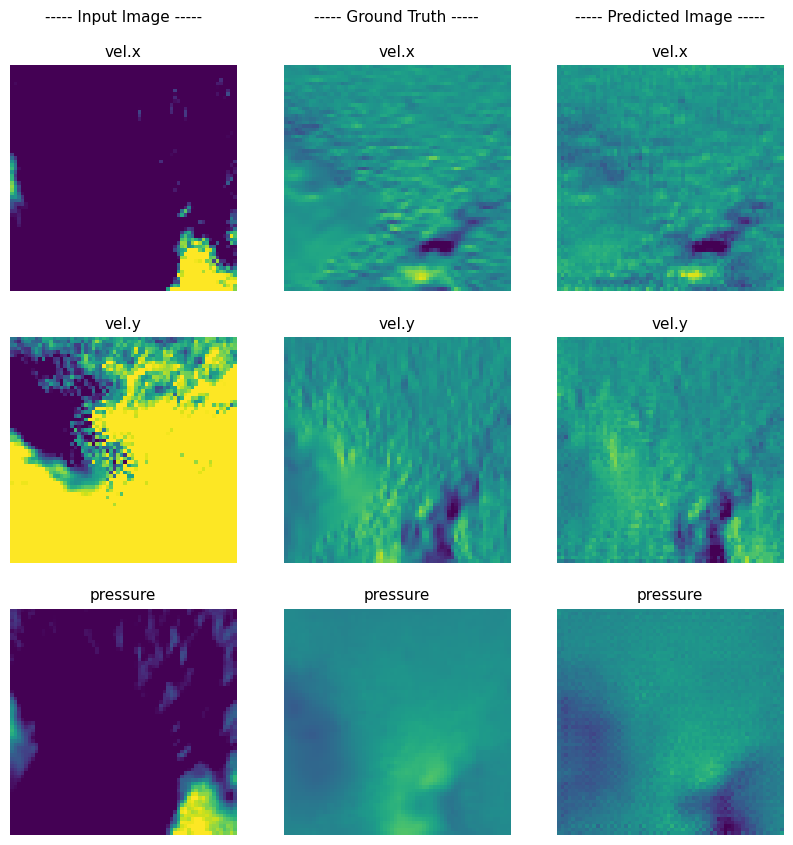

Checkpoint saved for epoch 220
Epoch 220 took 92.67 seconds
Epoch 221, Batch 0:
Generator Loss: 2.7938,  LR: 1.01e-05
Discriminator Loss: 0.2326,  LR: 2.51e-06
Epoch 221, Batch 200:
Generator Loss: 0.9181,  LR: 1.01e-05
Discriminator Loss: 0.0925,  LR: 2.51e-06
Epoch 221, Batch 400:
Generator Loss: 1.0460,  LR: 1.01e-05
Discriminator Loss: 0.0529,  LR: 2.51e-06
Epoch 221, Batch 600:
Generator Loss: 0.8821,  LR: 1.01e-05
Discriminator Loss: 0.0883,  LR: 2.51e-06
Epoch 221 took 86.33 seconds
Epoch 222, Batch 0:
Generator Loss: 0.9114,  LR: 1.01e-05
Discriminator Loss: 0.1656,  LR: 2.51e-06
Epoch 222, Batch 200:
Generator Loss: 0.8203,  LR: 1.01e-05
Discriminator Loss: 0.0813,  LR: 2.51e-06
Epoch 222, Batch 400:
Generator Loss: 0.6534,  LR: 1.01e-05
Discriminator Loss: 0.1471,  LR: 2.51e-06
Epoch 222, Batch 600:
Generator Loss: 1.1441,  LR: 1.01e-05
Discriminator Loss: 0.0541,  LR: 2.51e-06
Epoch 222 took 86.17 seconds
Epoch 223, Batch 0:
Generator Loss: 0.9742,  LR: 1.01e-05
Discriminato

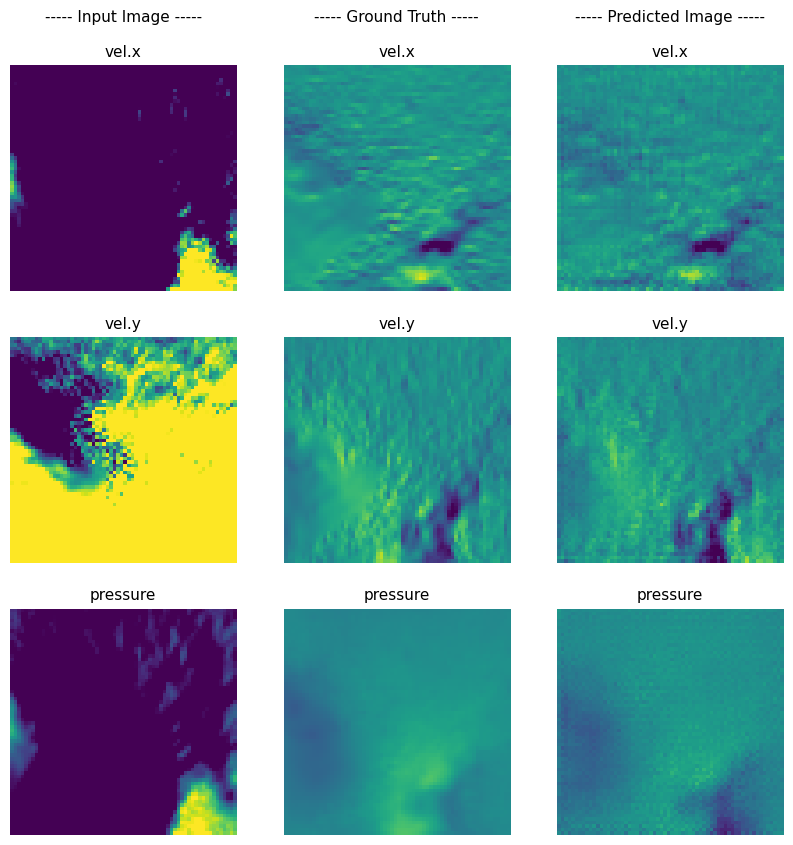

Epoch 225 took 86.59 seconds
Epoch 226, Batch 0:
Generator Loss: 0.9909,  LR: 9.66e-06
Discriminator Loss: 0.0287,  LR: 2.41e-06
Epoch 226, Batch 200:
Generator Loss: 1.0620,  LR: 9.66e-06
Discriminator Loss: 0.0572,  LR: 2.41e-06
Epoch 226, Batch 400:
Generator Loss: 1.0677,  LR: 9.66e-06
Discriminator Loss: 0.0459,  LR: 2.41e-06
Epoch 226, Batch 600:
Generator Loss: 1.0462,  LR: 9.66e-06
Discriminator Loss: 0.0221,  LR: 2.41e-06
Epoch 226 took 86.31 seconds
Epoch 227, Batch 0:
Generator Loss: 0.8856,  LR: 9.66e-06
Discriminator Loss: 0.0931,  LR: 2.41e-06
Epoch 227, Batch 200:
Generator Loss: 1.1029,  LR: 9.66e-06
Discriminator Loss: 0.1449,  LR: 2.41e-06
Epoch 227, Batch 400:
Generator Loss: 1.0489,  LR: 9.66e-06
Discriminator Loss: 0.0287,  LR: 2.41e-06
Epoch 227, Batch 600:
Generator Loss: 0.8810,  LR: 9.66e-06
Discriminator Loss: 0.0554,  LR: 2.41e-06
Epoch 227 took 86.33 seconds
Epoch 228, Batch 0:
Generator Loss: 0.9541,  LR: 9.66e-06
Discriminator Loss: 0.0505,  LR: 2.41e-06
E

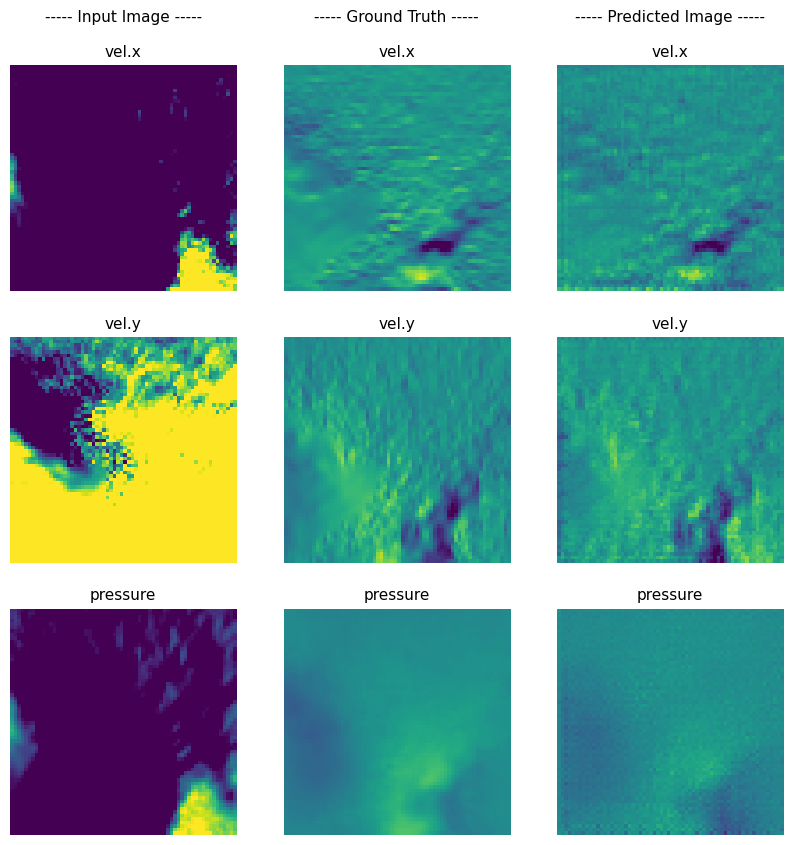

Epoch 230 took 91.32 seconds
Epoch 231, Batch 0:
Generator Loss: 2.7153,  LR: 9.28e-06
Discriminator Loss: 0.0363,  LR: 2.32e-06
Epoch 231, Batch 200:
Generator Loss: 0.8962,  LR: 9.28e-06
Discriminator Loss: 0.0343,  LR: 2.32e-06
Epoch 231, Batch 400:
Generator Loss: 0.9569,  LR: 9.28e-06
Discriminator Loss: 0.0538,  LR: 2.32e-06
Epoch 231, Batch 600:
Generator Loss: 0.9577,  LR: 9.28e-06
Discriminator Loss: 0.0388,  LR: 2.32e-06
Epoch 231 took 86.25 seconds
Epoch 232, Batch 0:
Generator Loss: 0.9571,  LR: 9.28e-06
Discriminator Loss: 0.0426,  LR: 2.32e-06
Epoch 232, Batch 200:
Generator Loss: 1.4725,  LR: 9.28e-06
Discriminator Loss: 0.0380,  LR: 2.32e-06
Epoch 232, Batch 400:
Generator Loss: 1.1495,  LR: 9.28e-06
Discriminator Loss: 0.0455,  LR: 2.32e-06
Epoch 232, Batch 600:
Generator Loss: 0.9318,  LR: 9.28e-06
Discriminator Loss: 0.0359,  LR: 2.32e-06
Epoch 232 took 86.34 seconds
Epoch 233, Batch 0:
Generator Loss: 0.7496,  LR: 9.28e-06
Discriminator Loss: 0.1180,  LR: 2.32e-06
E

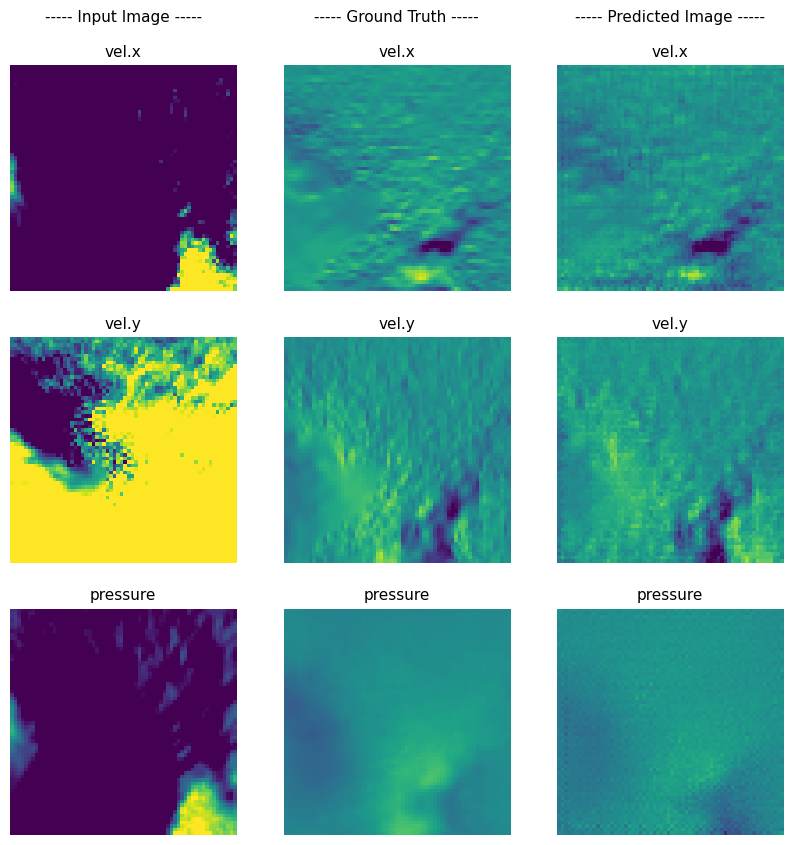

Epoch 235 took 86.61 seconds
Epoch 236, Batch 0:
Generator Loss: 0.8688,  LR: 8.91e-06
Discriminator Loss: 0.0981,  LR: 2.23e-06
Epoch 236, Batch 200:
Generator Loss: 0.8812,  LR: 8.91e-06
Discriminator Loss: 0.1528,  LR: 2.23e-06
Epoch 236, Batch 400:
Generator Loss: 1.3590,  LR: 8.91e-06
Discriminator Loss: 0.0298,  LR: 2.23e-06
Epoch 236, Batch 600:
Generator Loss: 1.0288,  LR: 8.91e-06
Discriminator Loss: 0.0458,  LR: 2.23e-06
Epoch 236 took 86.28 seconds
Epoch 237, Batch 0:
Generator Loss: 1.1301,  LR: 8.91e-06
Discriminator Loss: 0.0851,  LR: 2.23e-06
Epoch 237, Batch 200:
Generator Loss: 0.8639,  LR: 8.91e-06
Discriminator Loss: 0.0623,  LR: 2.23e-06
Epoch 237, Batch 400:
Generator Loss: 0.9221,  LR: 8.91e-06
Discriminator Loss: 0.0352,  LR: 2.23e-06
Epoch 237, Batch 600:
Generator Loss: 1.0716,  LR: 8.91e-06
Discriminator Loss: 0.1074,  LR: 2.23e-06
Epoch 237 took 86.17 seconds
Epoch 238, Batch 0:
Generator Loss: 1.5476,  LR: 8.91e-06
Discriminator Loss: 0.0380,  LR: 2.23e-06
E

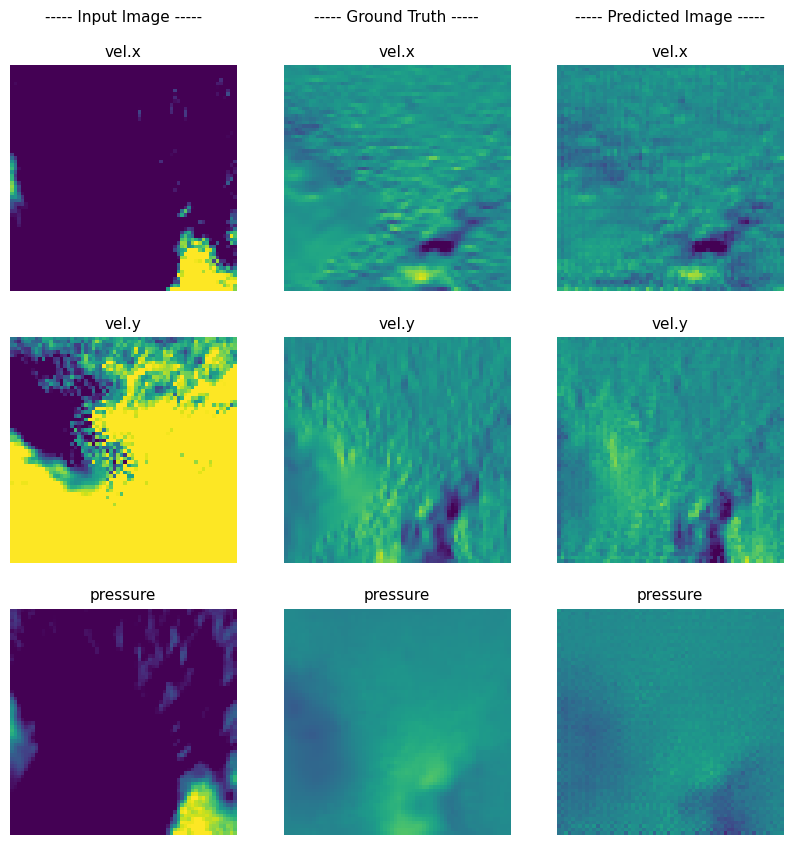

Checkpoint saved for epoch 240
Epoch 240 took 92.63 seconds
Epoch 241, Batch 0:
Generator Loss: 1.9422,  LR: 8.56e-06
Discriminator Loss: 0.1259,  LR: 2.14e-06
Epoch 241, Batch 200:
Generator Loss: 0.9697,  LR: 8.56e-06
Discriminator Loss: 0.0281,  LR: 2.14e-06
Epoch 241, Batch 400:
Generator Loss: 1.2315,  LR: 8.56e-06
Discriminator Loss: 0.0126,  LR: 2.14e-06
Epoch 241, Batch 600:
Generator Loss: 0.8661,  LR: 8.56e-06
Discriminator Loss: 0.0658,  LR: 2.14e-06
Epoch 241 took 86.20 seconds
Epoch 242, Batch 0:
Generator Loss: 1.1382,  LR: 8.56e-06
Discriminator Loss: 0.0805,  LR: 2.14e-06
Epoch 242, Batch 200:
Generator Loss: 1.3551,  LR: 8.56e-06
Discriminator Loss: 0.0437,  LR: 2.14e-06
Epoch 242, Batch 400:
Generator Loss: 1.0131,  LR: 8.56e-06
Discriminator Loss: 0.0557,  LR: 2.14e-06
Epoch 242, Batch 600:
Generator Loss: 0.8857,  LR: 8.56e-06
Discriminator Loss: 0.1076,  LR: 2.14e-06
Epoch 242 took 86.58 seconds
Epoch 243, Batch 0:
Generator Loss: 0.8676,  LR: 8.56e-06
Discriminato

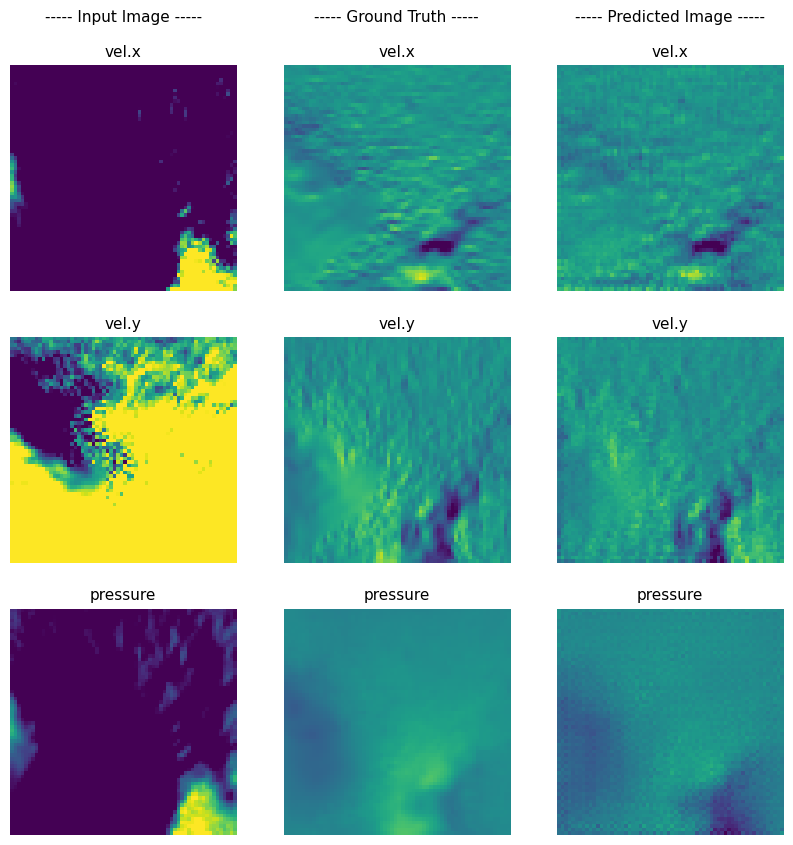

Epoch 245 took 86.84 seconds
Epoch 246, Batch 0:
Generator Loss: 1.0003,  LR: 8.22e-06
Discriminator Loss: 0.0531,  LR: 2.05e-06
Epoch 246, Batch 200:
Generator Loss: 0.8943,  LR: 8.22e-06
Discriminator Loss: 0.0413,  LR: 2.05e-06
Epoch 246, Batch 400:
Generator Loss: 1.0387,  LR: 8.22e-06
Discriminator Loss: 0.0588,  LR: 2.05e-06
Epoch 246, Batch 600:
Generator Loss: 0.9953,  LR: 8.22e-06
Discriminator Loss: 0.0531,  LR: 2.05e-06
Epoch 246 took 86.34 seconds
Epoch 247, Batch 0:
Generator Loss: 0.9093,  LR: 8.22e-06
Discriminator Loss: 0.0196,  LR: 2.05e-06
Epoch 247, Batch 200:
Generator Loss: 1.0482,  LR: 8.22e-06
Discriminator Loss: 0.0413,  LR: 2.05e-06
Epoch 247, Batch 400:
Generator Loss: 1.0709,  LR: 8.22e-06
Discriminator Loss: 0.0205,  LR: 2.05e-06
Epoch 247, Batch 600:
Generator Loss: 0.8938,  LR: 8.22e-06
Discriminator Loss: 0.0404,  LR: 2.05e-06
Epoch 247 took 85.98 seconds
Epoch 248, Batch 0:
Generator Loss: 0.8638,  LR: 8.22e-06
Discriminator Loss: 0.0866,  LR: 2.05e-06
E

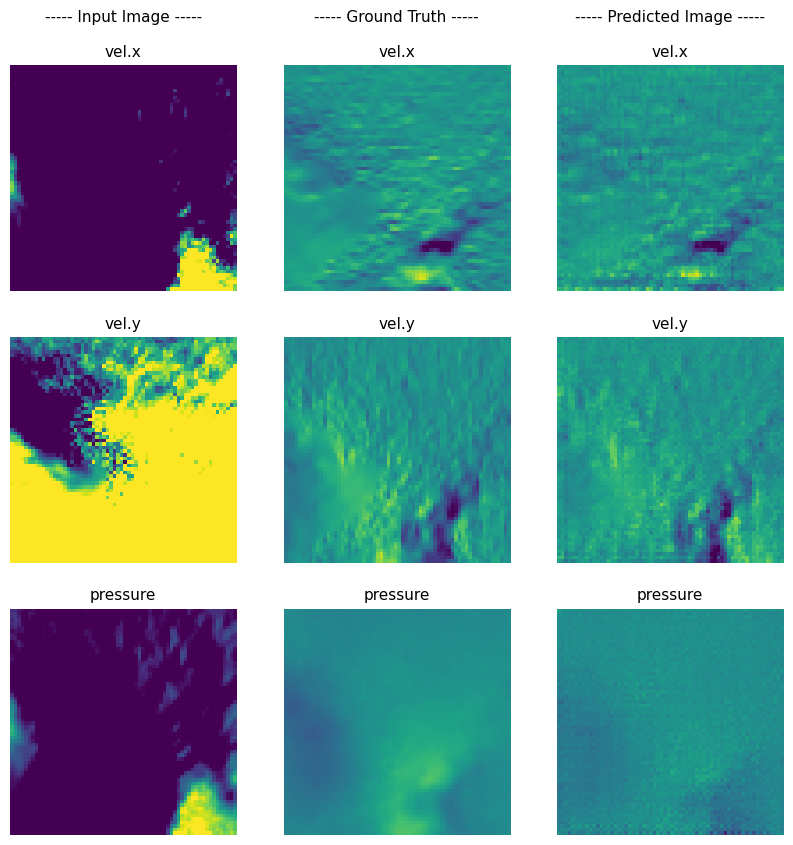

Epoch 250 took 91.90 seconds
Epoch 251, Batch 0:
Generator Loss: 1.7904,  LR: 7.89e-06
Discriminator Loss: 0.1341,  LR: 1.97e-06
Epoch 251, Batch 200:
Generator Loss: 1.1140,  LR: 7.89e-06
Discriminator Loss: 0.0373,  LR: 1.97e-06
Epoch 251, Batch 400:
Generator Loss: 0.9577,  LR: 7.89e-06
Discriminator Loss: 0.0314,  LR: 1.97e-06
Epoch 251, Batch 600:
Generator Loss: 1.3464,  LR: 7.89e-06
Discriminator Loss: 0.0315,  LR: 1.97e-06
Epoch 251 took 86.12 seconds
Epoch 252, Batch 0:
Generator Loss: 1.0567,  LR: 7.89e-06
Discriminator Loss: 0.0323,  LR: 1.97e-06
Epoch 252, Batch 200:
Generator Loss: 1.0556,  LR: 7.89e-06
Discriminator Loss: 0.0295,  LR: 1.97e-06
Epoch 252, Batch 400:
Generator Loss: 1.0210,  LR: 7.89e-06
Discriminator Loss: 0.0364,  LR: 1.97e-06
Epoch 252, Batch 600:
Generator Loss: 1.1341,  LR: 7.89e-06
Discriminator Loss: 0.0228,  LR: 1.97e-06
Epoch 252 took 86.13 seconds
Epoch 253, Batch 0:
Generator Loss: 2.5106,  LR: 7.89e-06
Discriminator Loss: 0.0219,  LR: 1.97e-06
E

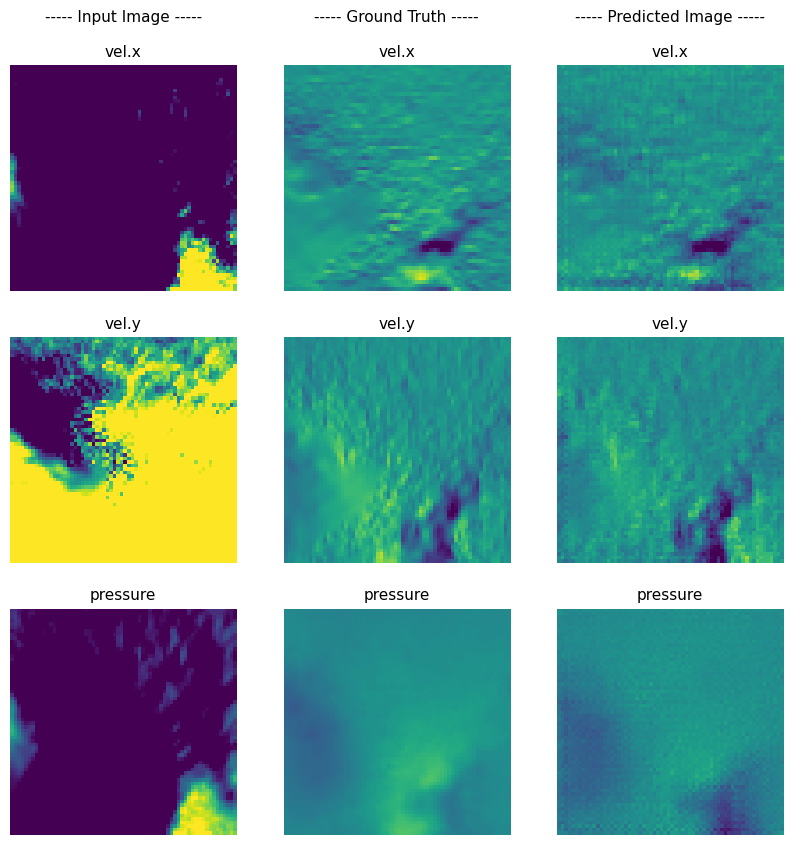

Epoch 255 took 86.58 seconds
Epoch 256, Batch 0:
Generator Loss: 0.8622,  LR: 7.58e-06
Discriminator Loss: 0.0608,  LR: 1.89e-06
Epoch 256, Batch 200:
Generator Loss: 0.9023,  LR: 7.58e-06
Discriminator Loss: 0.0558,  LR: 1.89e-06
Epoch 256, Batch 400:
Generator Loss: 0.7757,  LR: 7.58e-06
Discriminator Loss: 0.0873,  LR: 1.89e-06
Epoch 256, Batch 600:
Generator Loss: 1.0918,  LR: 7.58e-06
Discriminator Loss: 0.0385,  LR: 1.89e-06
Epoch 256 took 86.26 seconds
Epoch 257, Batch 0:
Generator Loss: 2.1480,  LR: 7.58e-06
Discriminator Loss: 0.0328,  LR: 1.89e-06
Epoch 257, Batch 200:
Generator Loss: 0.9750,  LR: 7.58e-06
Discriminator Loss: 0.0282,  LR: 1.89e-06
Epoch 257, Batch 400:
Generator Loss: 0.8994,  LR: 7.58e-06
Discriminator Loss: 0.1431,  LR: 1.89e-06
Epoch 257, Batch 600:
Generator Loss: 0.8557,  LR: 7.58e-06
Discriminator Loss: 0.0540,  LR: 1.89e-06
Epoch 257 took 86.33 seconds
Epoch 258, Batch 0:
Generator Loss: 1.0727,  LR: 7.58e-06
Discriminator Loss: 0.0343,  LR: 1.89e-06
E

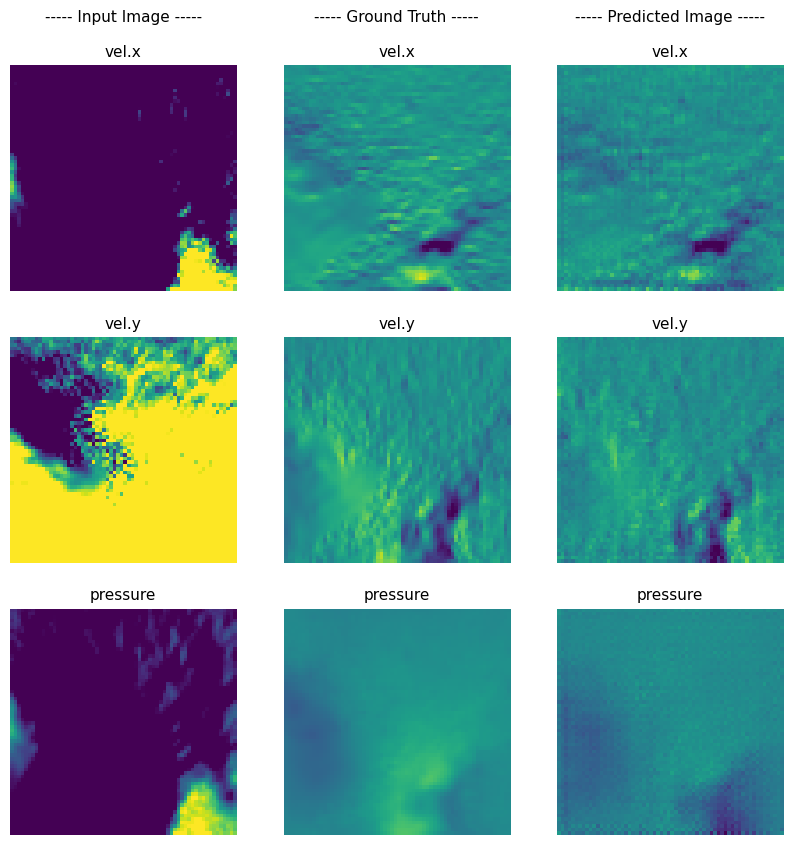

Checkpoint saved for epoch 260
Epoch 260 took 92.86 seconds
Epoch 261, Batch 0:
Generator Loss: 1.9029,  LR: 7.28e-06
Discriminator Loss: 0.2271,  LR: 1.82e-06
Epoch 261, Batch 200:
Generator Loss: 0.7180,  LR: 7.28e-06
Discriminator Loss: 0.1664,  LR: 1.82e-06
Epoch 261, Batch 400:
Generator Loss: 0.9712,  LR: 7.28e-06
Discriminator Loss: 0.0753,  LR: 1.82e-06
Epoch 261, Batch 600:
Generator Loss: 1.2660,  LR: 7.28e-06
Discriminator Loss: 0.1173,  LR: 1.82e-06
Epoch 261 took 86.38 seconds
Epoch 262, Batch 0:
Generator Loss: 1.0146,  LR: 7.28e-06
Discriminator Loss: 0.0334,  LR: 1.82e-06
Epoch 262, Batch 200:
Generator Loss: 1.1425,  LR: 7.28e-06
Discriminator Loss: 0.0282,  LR: 1.82e-06
Epoch 262, Batch 400:
Generator Loss: 0.7705,  LR: 7.28e-06
Discriminator Loss: 0.0700,  LR: 1.82e-06
Epoch 262, Batch 600:
Generator Loss: 1.0415,  LR: 7.28e-06
Discriminator Loss: 0.0848,  LR: 1.82e-06
Epoch 262 took 85.99 seconds
Epoch 263, Batch 0:
Generator Loss: 1.7049,  LR: 7.28e-06
Discriminato

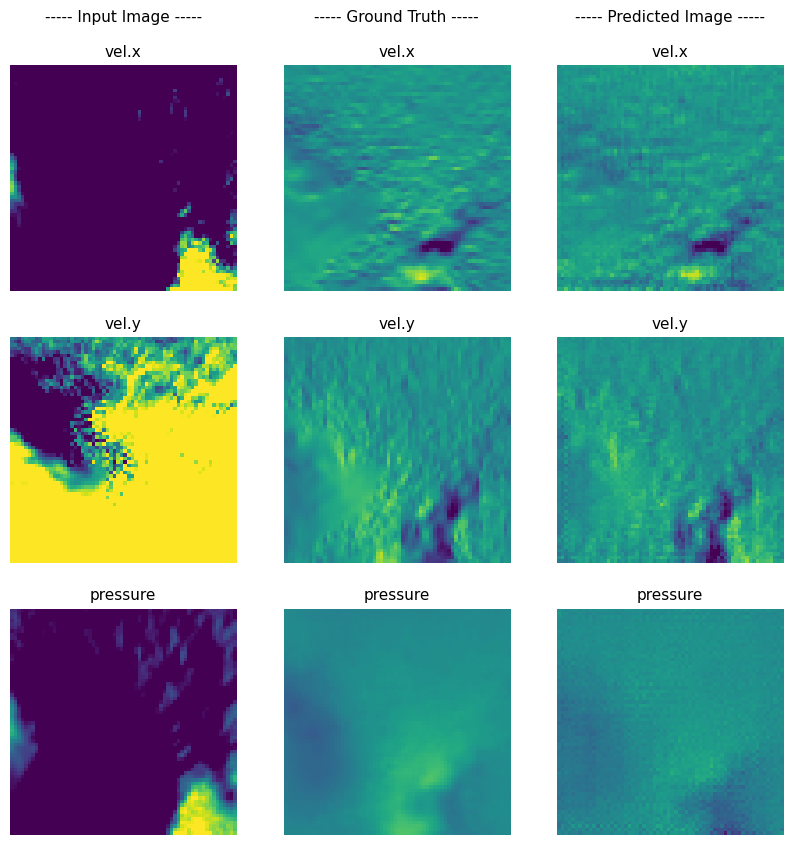

Epoch 265 took 86.57 seconds
Epoch 266, Batch 0:
Generator Loss: 0.9699,  LR: 6.99e-06
Discriminator Loss: 0.0527,  LR: 1.75e-06
Epoch 266, Batch 200:
Generator Loss: 1.0431,  LR: 6.99e-06
Discriminator Loss: 0.0176,  LR: 1.75e-06
Epoch 266, Batch 400:
Generator Loss: 0.8682,  LR: 6.99e-06
Discriminator Loss: 0.0879,  LR: 1.75e-06
Epoch 266, Batch 600:
Generator Loss: 1.0386,  LR: 6.99e-06
Discriminator Loss: 0.0677,  LR: 1.75e-06
Epoch 266 took 86.11 seconds
Epoch 267, Batch 0:
Generator Loss: 1.0156,  LR: 6.99e-06
Discriminator Loss: 0.0184,  LR: 1.75e-06
Epoch 267, Batch 200:
Generator Loss: 1.0192,  LR: 6.99e-06
Discriminator Loss: 0.0174,  LR: 1.75e-06
Epoch 267, Batch 400:
Generator Loss: 1.0208,  LR: 6.99e-06
Discriminator Loss: 0.0335,  LR: 1.75e-06
Epoch 267, Batch 600:
Generator Loss: 0.8925,  LR: 6.99e-06
Discriminator Loss: 0.0799,  LR: 1.75e-06
Epoch 267 took 86.34 seconds
Epoch 268, Batch 0:
Generator Loss: 0.9730,  LR: 6.99e-06
Discriminator Loss: 0.0298,  LR: 1.75e-06
E

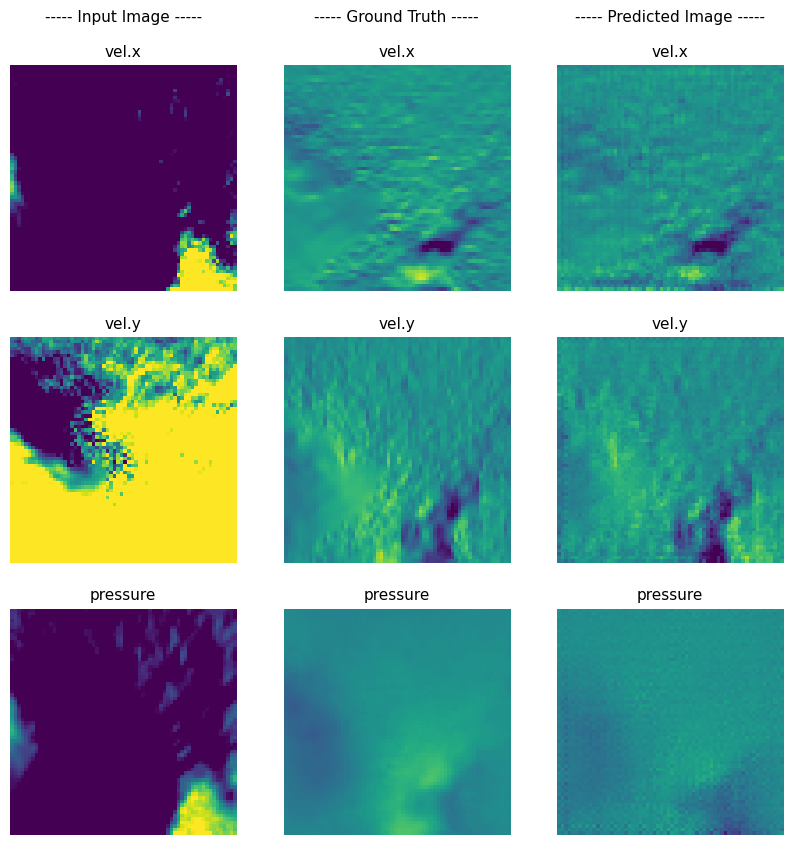

Epoch 270 took 91.69 seconds
Epoch 271, Batch 0:
Generator Loss: 2.6973,  LR: 6.71e-06
Discriminator Loss: 0.0797,  LR: 1.68e-06
Epoch 271, Batch 200:
Generator Loss: 0.9476,  LR: 6.71e-06
Discriminator Loss: 0.0549,  LR: 1.68e-06
Epoch 271, Batch 400:
Generator Loss: 0.9111,  LR: 6.71e-06
Discriminator Loss: 0.0851,  LR: 1.68e-06
Epoch 271, Batch 600:
Generator Loss: 1.4265,  LR: 6.71e-06
Discriminator Loss: 0.0611,  LR: 1.68e-06
Epoch 271 took 86.15 seconds
Epoch 272, Batch 0:
Generator Loss: 1.0458,  LR: 6.71e-06
Discriminator Loss: 0.0501,  LR: 1.68e-06
Epoch 272, Batch 200:
Generator Loss: 0.9200,  LR: 6.71e-06
Discriminator Loss: 0.0300,  LR: 1.68e-06
Epoch 272, Batch 400:
Generator Loss: 1.0078,  LR: 6.71e-06
Discriminator Loss: 0.0909,  LR: 1.68e-06
Epoch 272, Batch 600:
Generator Loss: 1.0752,  LR: 6.71e-06
Discriminator Loss: 0.0382,  LR: 1.68e-06
Epoch 272 took 86.23 seconds
Epoch 273, Batch 0:
Generator Loss: 1.1670,  LR: 6.71e-06
Discriminator Loss: 0.0744,  LR: 1.68e-06
E

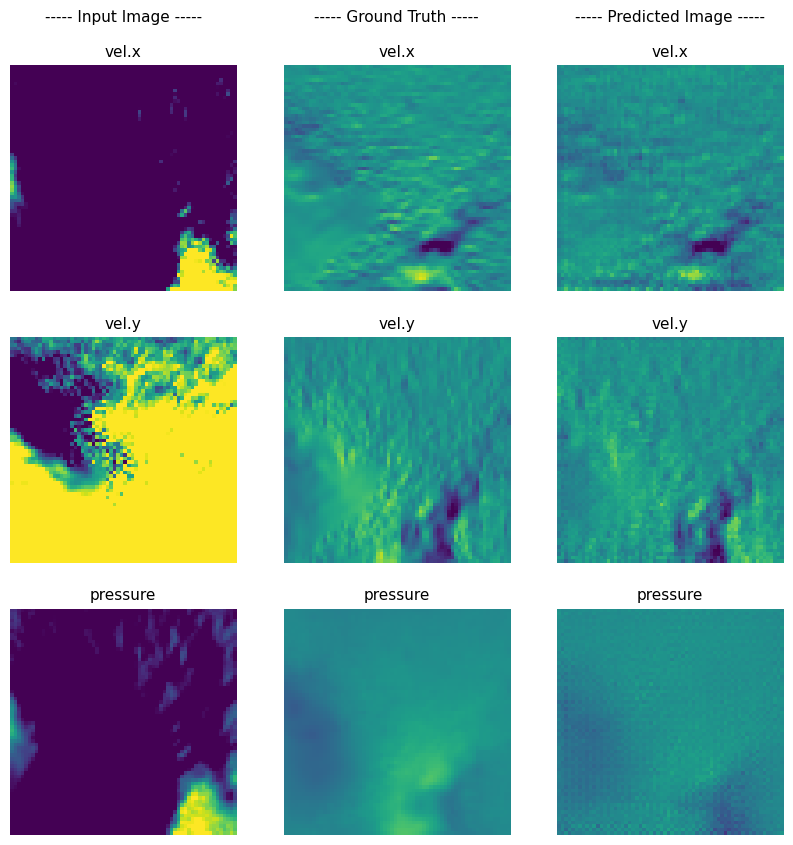

Epoch 275 took 86.42 seconds
Epoch 276, Batch 0:
Generator Loss: 0.9812,  LR: 6.45e-06
Discriminator Loss: 0.0644,  LR: 1.61e-06
Epoch 276, Batch 200:
Generator Loss: 0.9512,  LR: 6.45e-06
Discriminator Loss: 0.0262,  LR: 1.61e-06
Epoch 276, Batch 400:
Generator Loss: 1.0852,  LR: 6.45e-06
Discriminator Loss: 0.0164,  LR: 1.61e-06
Epoch 276, Batch 600:
Generator Loss: 0.8745,  LR: 6.45e-06
Discriminator Loss: 0.0430,  LR: 1.61e-06
Epoch 276 took 86.42 seconds
Epoch 277, Batch 0:
Generator Loss: 0.8703,  LR: 6.45e-06
Discriminator Loss: 0.0632,  LR: 1.61e-06
Epoch 277, Batch 200:
Generator Loss: 0.8450,  LR: 6.45e-06
Discriminator Loss: 0.0405,  LR: 1.61e-06
Epoch 277, Batch 400:
Generator Loss: 0.9627,  LR: 6.45e-06
Discriminator Loss: 0.0296,  LR: 1.61e-06
Epoch 277, Batch 600:
Generator Loss: 0.8837,  LR: 6.45e-06
Discriminator Loss: 0.0577,  LR: 1.61e-06
Epoch 277 took 86.45 seconds
Epoch 278, Batch 0:
Generator Loss: 0.8537,  LR: 6.45e-06
Discriminator Loss: 0.1006,  LR: 1.61e-06
E

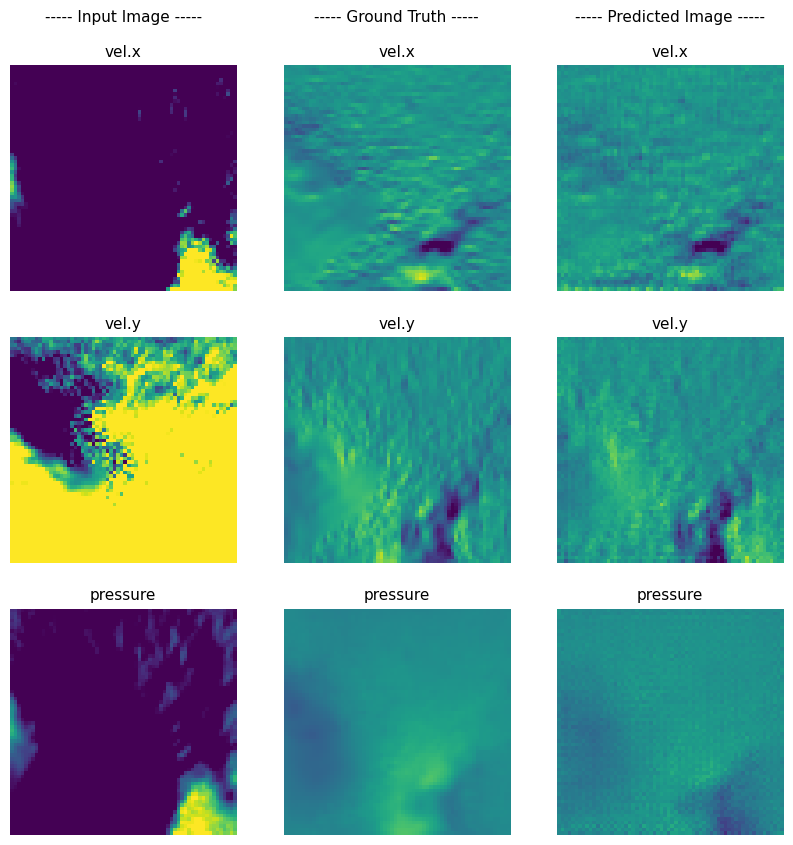

Checkpoint saved for epoch 280
Epoch 280 took 92.80 seconds
Epoch 281, Batch 0:
Generator Loss: 2.6051,  LR: 6.19e-06
Discriminator Loss: 0.0344,  LR: 1.55e-06
Epoch 281, Batch 200:
Generator Loss: 0.9597,  LR: 6.19e-06
Discriminator Loss: 0.0438,  LR: 1.55e-06
Epoch 281, Batch 400:
Generator Loss: 1.0940,  LR: 6.19e-06
Discriminator Loss: 0.0184,  LR: 1.55e-06
Epoch 281, Batch 600:
Generator Loss: 1.0781,  LR: 6.19e-06
Discriminator Loss: 0.0589,  LR: 1.55e-06
Epoch 281 took 86.74 seconds
Epoch 282, Batch 0:
Generator Loss: 0.9264,  LR: 6.19e-06
Discriminator Loss: 0.0476,  LR: 1.55e-06
Epoch 282, Batch 200:
Generator Loss: 0.7394,  LR: 6.19e-06
Discriminator Loss: 0.0916,  LR: 1.55e-06
Epoch 282, Batch 400:
Generator Loss: 1.1040,  LR: 6.19e-06
Discriminator Loss: 0.0219,  LR: 1.55e-06
Epoch 282, Batch 600:
Generator Loss: 1.3220,  LR: 6.19e-06
Discriminator Loss: 0.0304,  LR: 1.55e-06
Epoch 282 took 86.40 seconds
Epoch 283, Batch 0:
Generator Loss: 0.9407,  LR: 6.19e-06
Discriminato

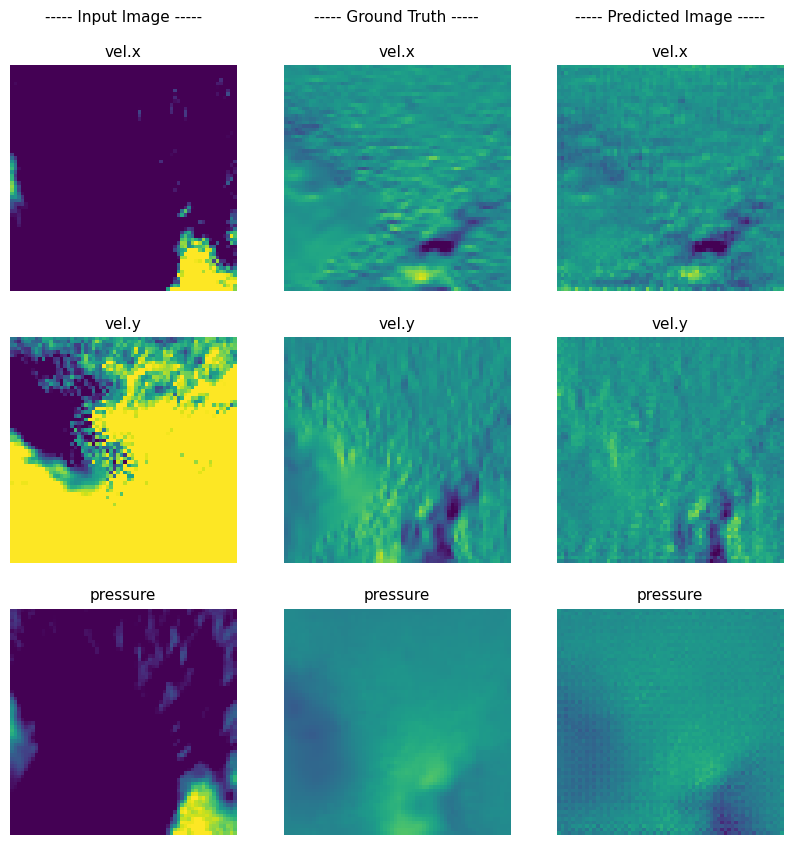

Epoch 285 took 86.57 seconds
Epoch 286, Batch 0:
Generator Loss: 0.9889,  LR: 5.95e-06
Discriminator Loss: 0.0346,  LR: 1.49e-06
Epoch 286, Batch 200:
Generator Loss: 0.7778,  LR: 5.95e-06
Discriminator Loss: 0.0965,  LR: 1.49e-06
Epoch 286, Batch 400:
Generator Loss: 0.9604,  LR: 5.95e-06
Discriminator Loss: 0.0192,  LR: 1.49e-06
Epoch 286, Batch 600:
Generator Loss: 1.0094,  LR: 5.95e-06
Discriminator Loss: 0.0223,  LR: 1.49e-06
Epoch 286 took 85.84 seconds
Epoch 287, Batch 0:
Generator Loss: 1.0641,  LR: 5.95e-06
Discriminator Loss: 0.0605,  LR: 1.49e-06
Epoch 287, Batch 200:
Generator Loss: 1.0989,  LR: 5.95e-06
Discriminator Loss: 0.0197,  LR: 1.49e-06
Epoch 287, Batch 400:
Generator Loss: 1.1050,  LR: 5.95e-06
Discriminator Loss: 0.0470,  LR: 1.49e-06
Epoch 287, Batch 600:
Generator Loss: 0.9306,  LR: 5.95e-06
Discriminator Loss: 0.0545,  LR: 1.49e-06
Epoch 287 took 86.48 seconds
Epoch 288, Batch 0:
Generator Loss: 1.8176,  LR: 5.95e-06
Discriminator Loss: 0.0269,  LR: 1.49e-06
E

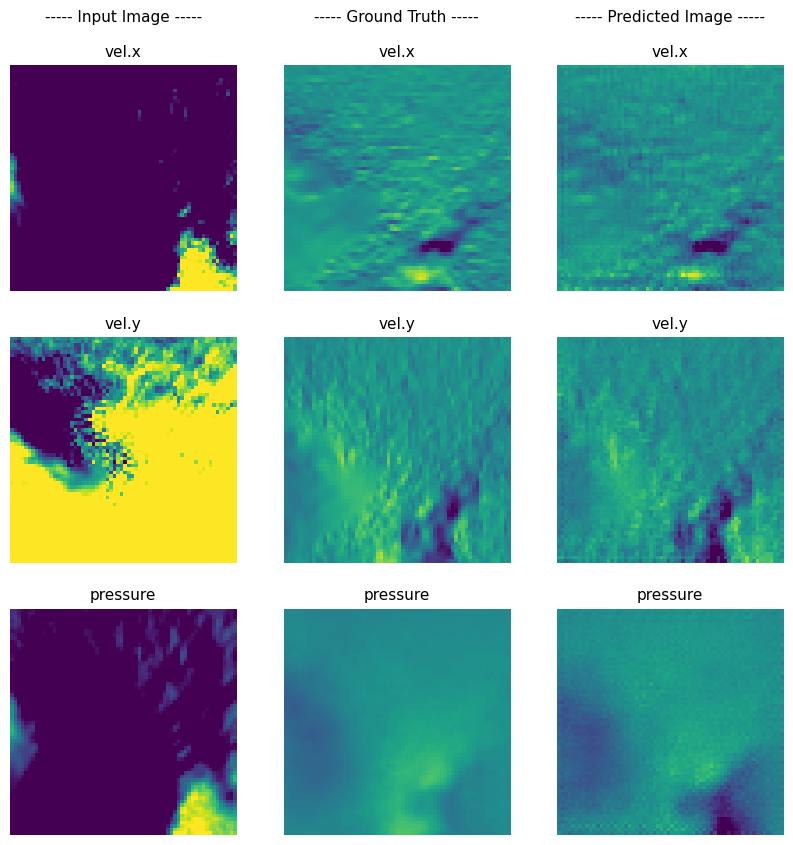

Epoch 290 took 91.56 seconds
Epoch 291, Batch 0:
Generator Loss: 2.6097,  LR: 5.71e-06
Discriminator Loss: 0.0373,  LR: 1.43e-06
Epoch 291, Batch 200:
Generator Loss: 1.0851,  LR: 5.71e-06
Discriminator Loss: 0.0913,  LR: 1.43e-06
Epoch 291, Batch 400:
Generator Loss: 1.3389,  LR: 5.71e-06
Discriminator Loss: 0.0765,  LR: 1.43e-06
Epoch 291, Batch 600:
Generator Loss: 1.4494,  LR: 5.71e-06
Discriminator Loss: 0.0684,  LR: 1.43e-06
Epoch 291 took 86.35 seconds
Epoch 292, Batch 0:
Generator Loss: 0.9888,  LR: 5.71e-06
Discriminator Loss: 0.0405,  LR: 1.43e-06
Epoch 292, Batch 200:
Generator Loss: 1.3391,  LR: 5.71e-06
Discriminator Loss: 0.0428,  LR: 1.43e-06
Epoch 292, Batch 400:
Generator Loss: 0.8233,  LR: 5.71e-06
Discriminator Loss: 0.1949,  LR: 1.43e-06
Epoch 292, Batch 600:
Generator Loss: 0.9393,  LR: 5.71e-06
Discriminator Loss: 0.0932,  LR: 1.43e-06
Epoch 292 took 86.79 seconds
Epoch 293, Batch 0:
Generator Loss: 0.7924,  LR: 5.71e-06
Discriminator Loss: 0.0672,  LR: 1.43e-06
E

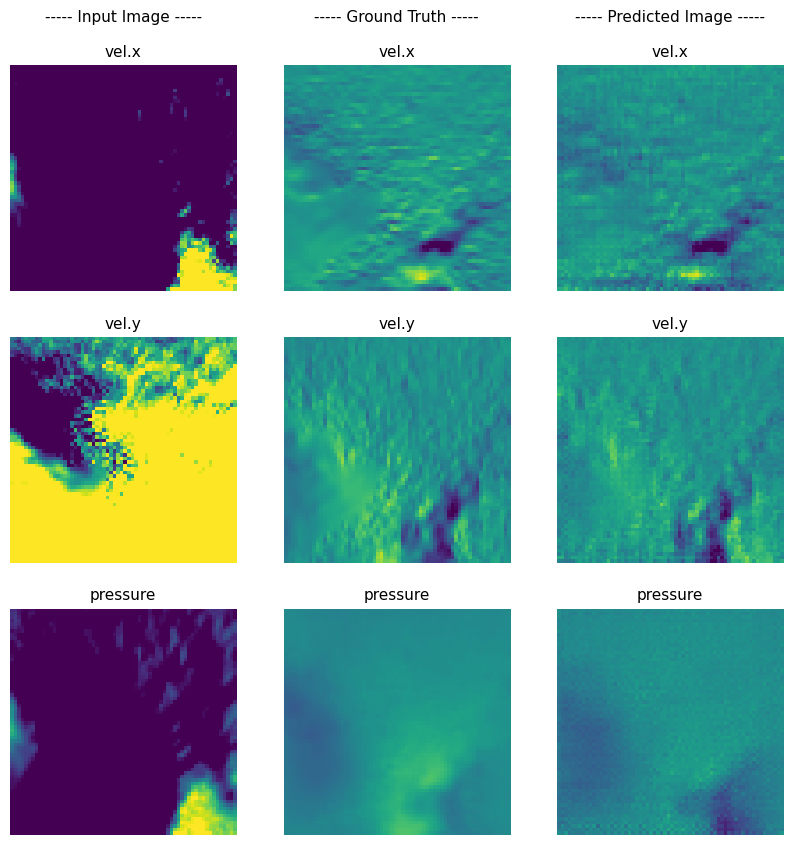

Epoch 295 took 86.96 seconds
Epoch 296, Batch 0:
Generator Loss: 1.0367,  LR: 5.49e-06
Discriminator Loss: 0.0807,  LR: 1.37e-06
Epoch 296, Batch 200:
Generator Loss: 1.0675,  LR: 5.49e-06
Discriminator Loss: 0.1620,  LR: 1.37e-06
Epoch 296, Batch 400:
Generator Loss: 0.8379,  LR: 5.49e-06
Discriminator Loss: 0.1436,  LR: 1.37e-06
Epoch 296, Batch 600:
Generator Loss: 0.9160,  LR: 5.49e-06
Discriminator Loss: 0.0876,  LR: 1.37e-06
Epoch 296 took 86.52 seconds
Epoch 297, Batch 0:
Generator Loss: 0.9179,  LR: 5.49e-06
Discriminator Loss: 0.0545,  LR: 1.37e-06
Epoch 297, Batch 200:
Generator Loss: 0.9164,  LR: 5.49e-06
Discriminator Loss: 0.0943,  LR: 1.37e-06
Epoch 297, Batch 400:
Generator Loss: 1.0818,  LR: 5.49e-06
Discriminator Loss: 0.0419,  LR: 1.37e-06
Epoch 297, Batch 600:
Generator Loss: 1.1418,  LR: 5.49e-06
Discriminator Loss: 0.0256,  LR: 1.37e-06
Epoch 297 took 86.29 seconds
Epoch 298, Batch 0:
Generator Loss: 1.0592,  LR: 5.49e-06
Discriminator Loss: 0.0264,  LR: 1.37e-06
E

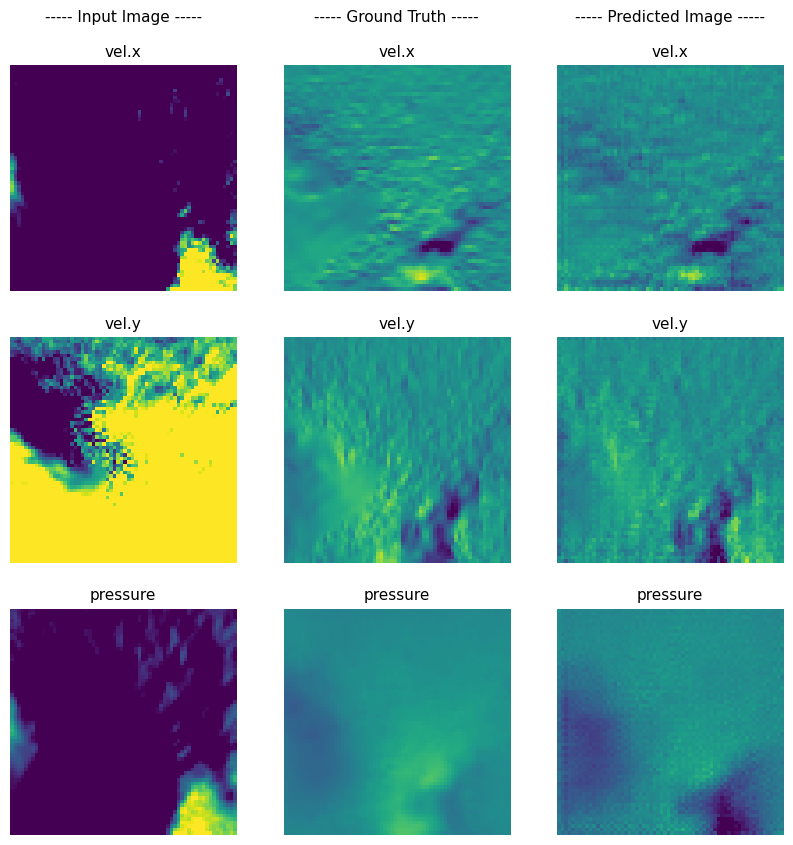

Checkpoint saved for epoch 300
Epoch 300 took 92.84 seconds
Epoch 301, Batch 0:
Generator Loss: 1.9035,  LR: 5.27e-06
Discriminator Loss: 0.1063,  LR: 1.32e-06
Epoch 301, Batch 200:
Generator Loss: 0.9750,  LR: 5.27e-06
Discriminator Loss: 0.0941,  LR: 1.32e-06
Epoch 301, Batch 400:
Generator Loss: 0.9277,  LR: 5.27e-06
Discriminator Loss: 0.0898,  LR: 1.32e-06
Epoch 301, Batch 600:
Generator Loss: 1.1832,  LR: 5.27e-06
Discriminator Loss: 0.0651,  LR: 1.32e-06
Epoch 301 took 86.69 seconds
Epoch 302, Batch 0:
Generator Loss: 0.9902,  LR: 5.27e-06
Discriminator Loss: 0.0596,  LR: 1.32e-06
Epoch 302, Batch 200:
Generator Loss: 0.8995,  LR: 5.27e-06
Discriminator Loss: 0.0246,  LR: 1.32e-06
Epoch 302, Batch 400:
Generator Loss: 0.8963,  LR: 5.27e-06
Discriminator Loss: 0.0805,  LR: 1.32e-06
Epoch 302, Batch 600:
Generator Loss: 0.9696,  LR: 5.27e-06
Discriminator Loss: 0.0449,  LR: 1.32e-06
Epoch 302 took 86.43 seconds
Epoch 303, Batch 0:
Generator Loss: 1.0602,  LR: 5.27e-06
Discriminato

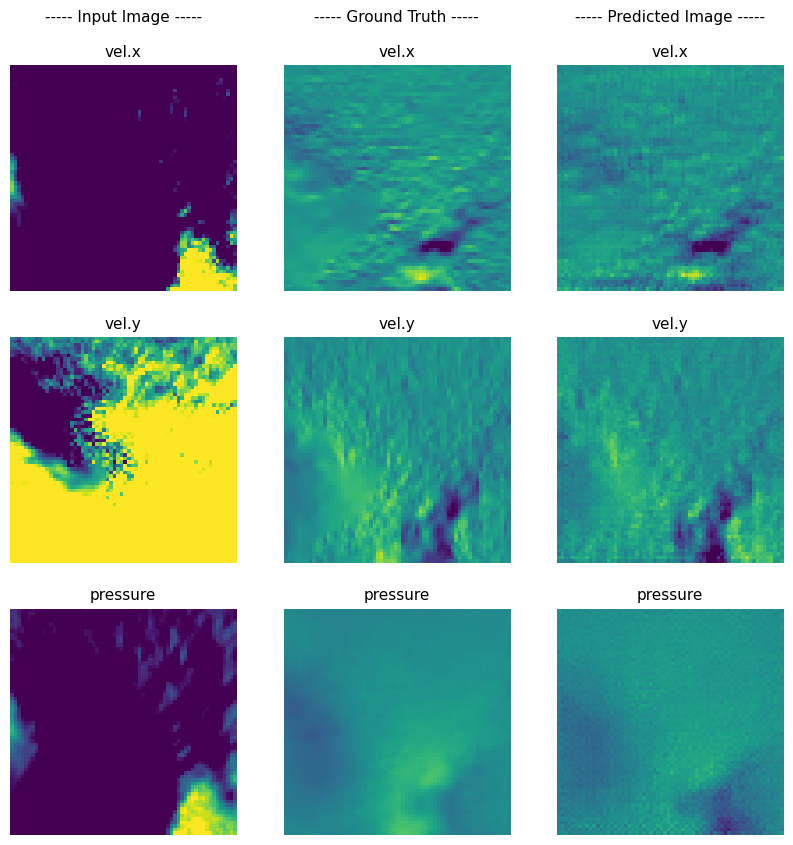

Epoch 305 took 86.72 seconds
Epoch 306, Batch 0:
Generator Loss: 0.7580,  LR: 5.06e-06
Discriminator Loss: 0.0834,  LR: 1.27e-06
Epoch 306, Batch 200:
Generator Loss: 0.9703,  LR: 5.06e-06
Discriminator Loss: 0.0614,  LR: 1.27e-06
Epoch 306, Batch 400:
Generator Loss: 1.0451,  LR: 5.06e-06
Discriminator Loss: 0.0549,  LR: 1.27e-06
Epoch 306, Batch 600:
Generator Loss: 1.0660,  LR: 5.06e-06
Discriminator Loss: 0.0266,  LR: 1.27e-06
Epoch 306 took 86.37 seconds
Epoch 307, Batch 0:
Generator Loss: 1.0646,  LR: 5.06e-06
Discriminator Loss: 0.0314,  LR: 1.27e-06
Epoch 307, Batch 200:
Generator Loss: 1.0280,  LR: 5.06e-06
Discriminator Loss: 0.0313,  LR: 1.27e-06
Epoch 307, Batch 400:
Generator Loss: 1.1167,  LR: 5.06e-06
Discriminator Loss: 0.0437,  LR: 1.27e-06
Epoch 307, Batch 600:
Generator Loss: 0.9023,  LR: 5.06e-06
Discriminator Loss: 0.0319,  LR: 1.27e-06
Epoch 307 took 86.34 seconds
Epoch 308, Batch 0:
Generator Loss: 0.9628,  LR: 5.06e-06
Discriminator Loss: 0.0964,  LR: 1.27e-06
E

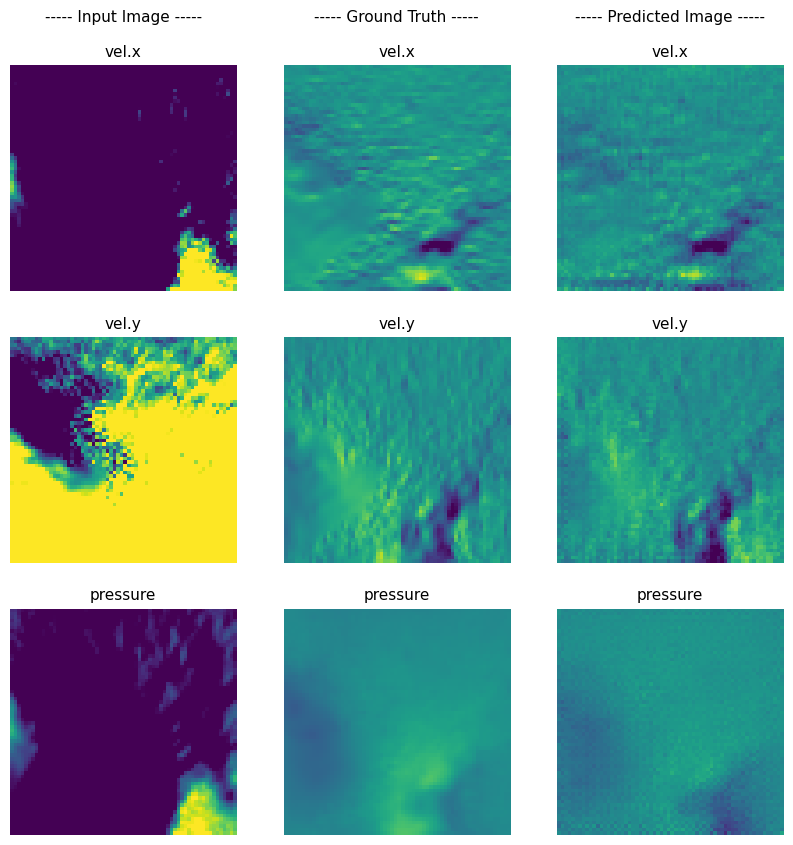

Epoch 310 took 91.78 seconds
Epoch 311, Batch 0:
Generator Loss: 1.9253,  LR: 4.86e-06
Discriminator Loss: 0.0672,  LR: 1.21e-06
Epoch 311, Batch 200:
Generator Loss: 0.7994,  LR: 4.86e-06
Discriminator Loss: 0.1294,  LR: 1.21e-06
Epoch 311, Batch 400:
Generator Loss: 1.3494,  LR: 4.86e-06
Discriminator Loss: 0.0199,  LR: 1.21e-06
Epoch 311, Batch 600:
Generator Loss: 0.8553,  LR: 4.86e-06
Discriminator Loss: 0.0776,  LR: 1.21e-06
Epoch 311 took 86.26 seconds
Epoch 312, Batch 0:
Generator Loss: 1.0122,  LR: 4.86e-06
Discriminator Loss: 0.0737,  LR: 1.21e-06
Epoch 312, Batch 200:
Generator Loss: 0.9993,  LR: 4.86e-06
Discriminator Loss: 0.0554,  LR: 1.21e-06
Epoch 312, Batch 400:
Generator Loss: 1.0012,  LR: 4.86e-06
Discriminator Loss: 0.0590,  LR: 1.21e-06
Epoch 312, Batch 600:
Generator Loss: 0.9650,  LR: 4.86e-06
Discriminator Loss: 0.0363,  LR: 1.21e-06
Epoch 312 took 86.60 seconds
Epoch 313, Batch 0:
Generator Loss: 1.0782,  LR: 4.86e-06
Discriminator Loss: 0.0588,  LR: 1.21e-06
E

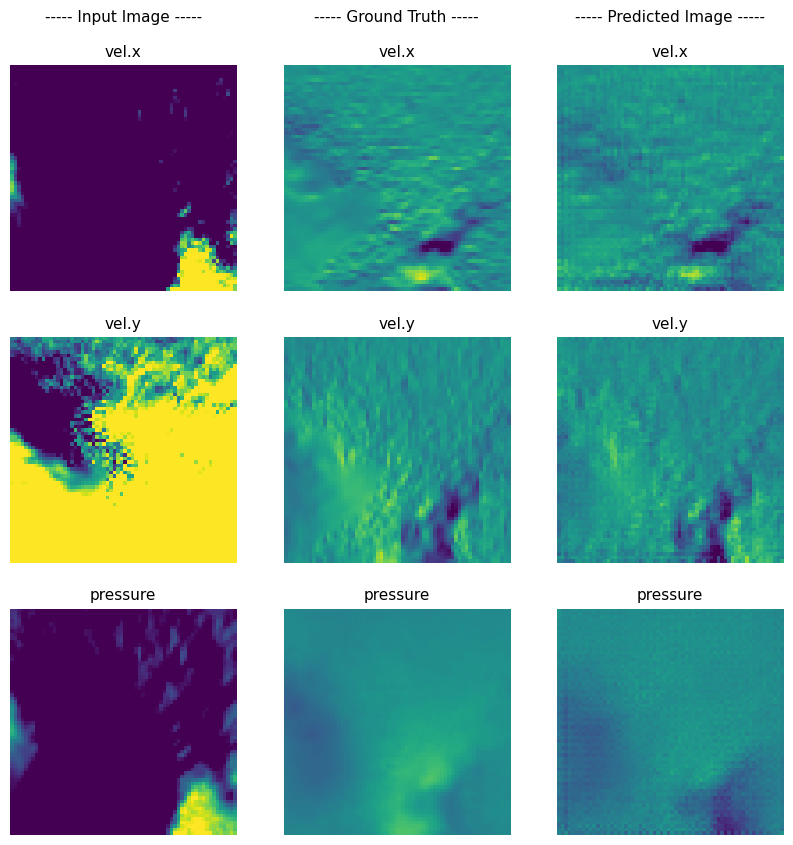

Epoch 315 took 86.67 seconds
Epoch 316, Batch 0:
Generator Loss: 0.9216,  LR: 4.67e-06
Discriminator Loss: 0.0426,  LR: 1.17e-06
Epoch 316, Batch 200:
Generator Loss: 0.9116,  LR: 4.67e-06
Discriminator Loss: 0.0476,  LR: 1.17e-06
Epoch 316, Batch 400:
Generator Loss: 0.8691,  LR: 4.67e-06
Discriminator Loss: 0.0454,  LR: 1.17e-06
Epoch 316, Batch 600:
Generator Loss: 0.9711,  LR: 4.67e-06
Discriminator Loss: 0.0433,  LR: 1.17e-06
Epoch 316 took 86.52 seconds
Epoch 317, Batch 0:
Generator Loss: 0.9079,  LR: 4.67e-06
Discriminator Loss: 0.0753,  LR: 1.17e-06
Epoch 317, Batch 200:
Generator Loss: 1.0869,  LR: 4.67e-06
Discriminator Loss: 0.0367,  LR: 1.17e-06
Epoch 317, Batch 400:
Generator Loss: 1.0989,  LR: 4.67e-06
Discriminator Loss: 0.0394,  LR: 1.17e-06
Epoch 317, Batch 600:
Generator Loss: 0.9049,  LR: 4.67e-06
Discriminator Loss: 0.0227,  LR: 1.17e-06
Epoch 317 took 86.15 seconds
Epoch 318, Batch 0:
Generator Loss: 1.5848,  LR: 4.67e-06
Discriminator Loss: 0.0300,  LR: 1.17e-06
E

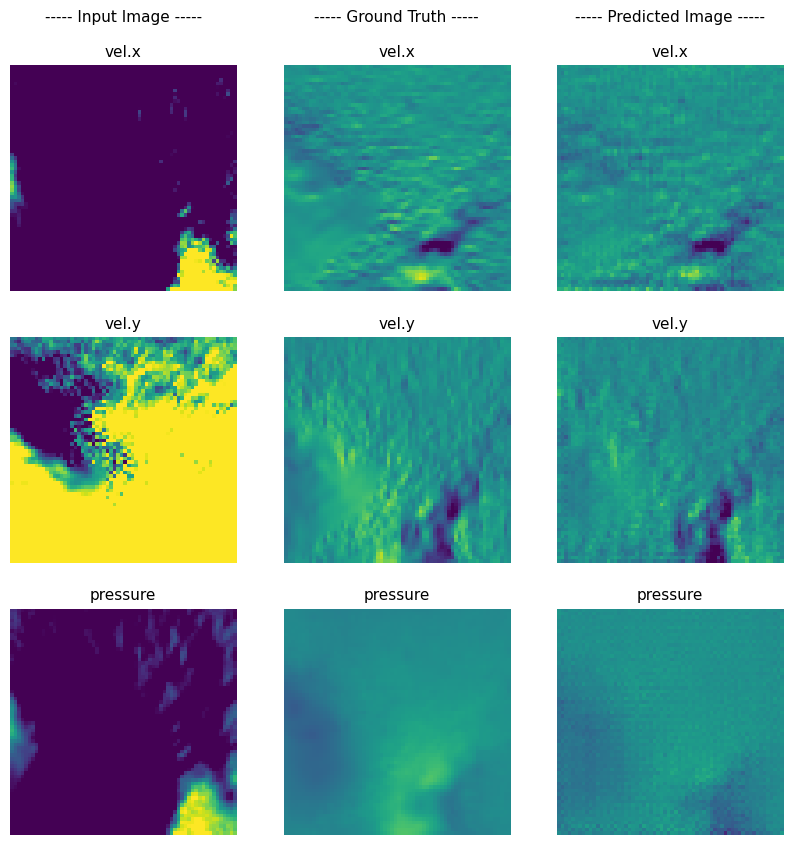

Checkpoint saved for epoch 320
Epoch 320 took 92.72 seconds
Epoch 321, Batch 0:
Generator Loss: 2.4410,  LR: 4.48e-06
Discriminator Loss: 0.0282,  LR: 1.12e-06
Epoch 321, Batch 200:
Generator Loss: 0.9831,  LR: 4.48e-06
Discriminator Loss: 0.1037,  LR: 1.12e-06
Epoch 321, Batch 400:
Generator Loss: 0.9596,  LR: 4.48e-06
Discriminator Loss: 0.0420,  LR: 1.12e-06
Epoch 321, Batch 600:
Generator Loss: 0.9464,  LR: 4.48e-06
Discriminator Loss: 0.1059,  LR: 1.12e-06
Epoch 321 took 86.64 seconds
Epoch 322, Batch 0:
Generator Loss: 1.7130,  LR: 4.48e-06
Discriminator Loss: 0.0328,  LR: 1.12e-06
Epoch 322, Batch 200:
Generator Loss: 0.9063,  LR: 4.48e-06
Discriminator Loss: 0.0846,  LR: 1.12e-06
Epoch 322, Batch 400:
Generator Loss: 1.0633,  LR: 4.48e-06
Discriminator Loss: 0.0477,  LR: 1.12e-06
Epoch 322, Batch 600:
Generator Loss: 1.0387,  LR: 4.48e-06
Discriminator Loss: 0.0272,  LR: 1.12e-06
Epoch 322 took 86.46 seconds
Epoch 323, Batch 0:
Generator Loss: 1.0919,  LR: 4.48e-06
Discriminato

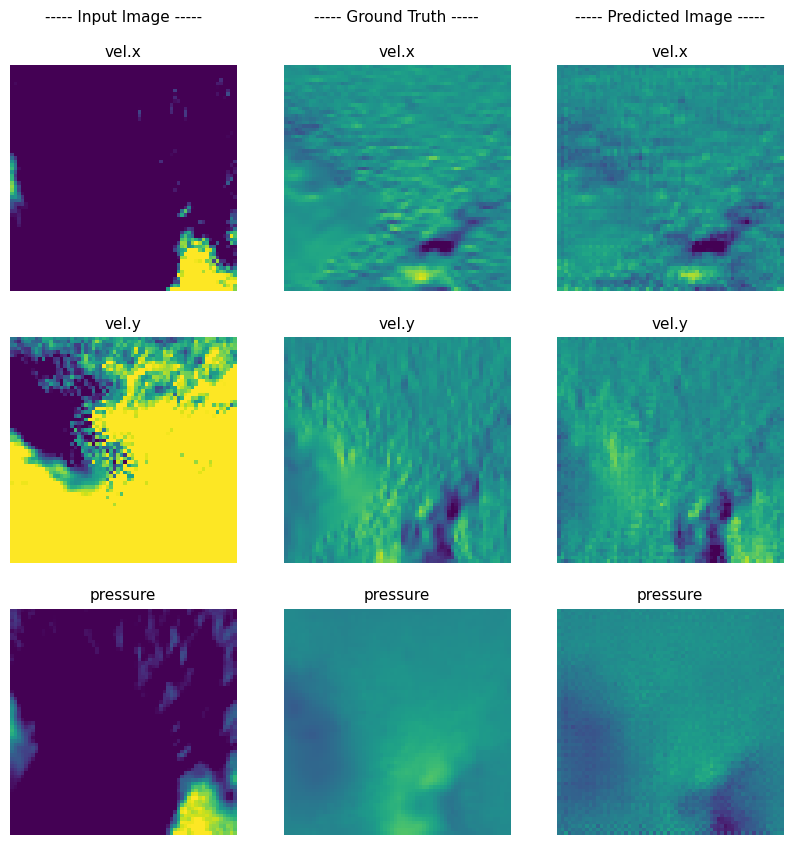

Epoch 325 took 86.13 seconds
Epoch 326, Batch 0:
Generator Loss: 1.1221,  LR: 4.31e-06
Discriminator Loss: 0.0304,  LR: 1.08e-06
Epoch 326, Batch 200:
Generator Loss: 1.0340,  LR: 4.31e-06
Discriminator Loss: 0.0175,  LR: 1.08e-06
Epoch 326, Batch 400:
Generator Loss: 0.9804,  LR: 4.31e-06
Discriminator Loss: 0.0449,  LR: 1.08e-06
Epoch 326, Batch 600:
Generator Loss: 0.9214,  LR: 4.31e-06
Discriminator Loss: 0.1040,  LR: 1.08e-06
Epoch 326 took 86.36 seconds
Epoch 327, Batch 0:
Generator Loss: 1.0655,  LR: 4.31e-06
Discriminator Loss: 0.0522,  LR: 1.08e-06
Epoch 327, Batch 200:
Generator Loss: 0.8830,  LR: 4.31e-06
Discriminator Loss: 0.0286,  LR: 1.08e-06
Epoch 327, Batch 400:
Generator Loss: 0.7348,  LR: 4.31e-06
Discriminator Loss: 0.1145,  LR: 1.08e-06
Epoch 327, Batch 600:
Generator Loss: 0.9848,  LR: 4.31e-06
Discriminator Loss: 0.0298,  LR: 1.08e-06
Epoch 327 took 85.99 seconds
Epoch 328, Batch 0:
Generator Loss: 1.1488,  LR: 4.31e-06
Discriminator Loss: 0.1777,  LR: 1.08e-06
E

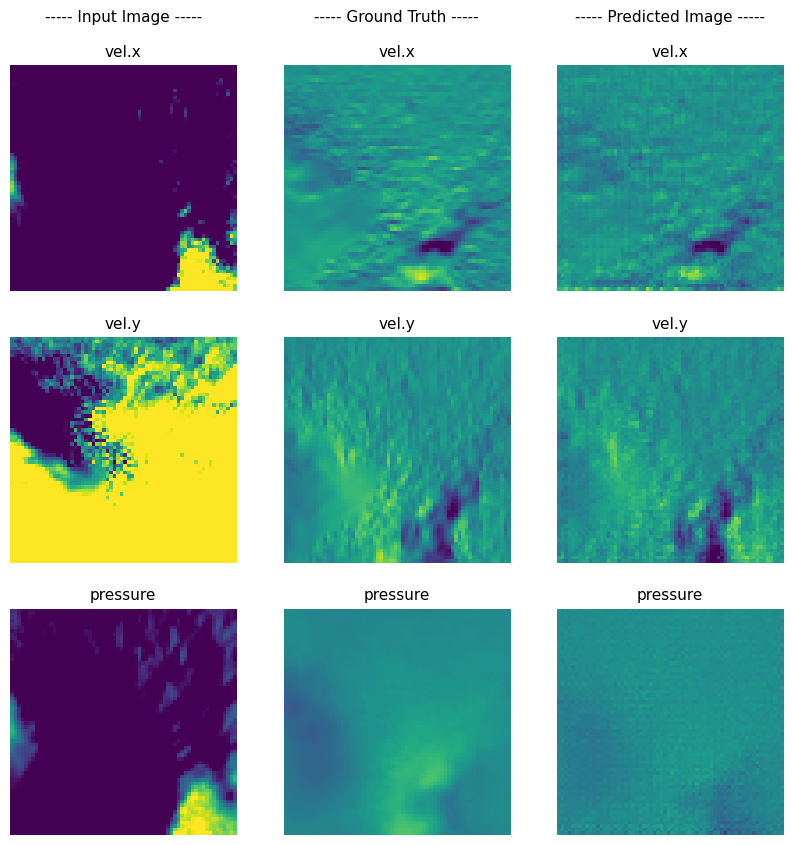

Epoch 330 took 91.49 seconds
Epoch 331, Batch 0:
Generator Loss: 2.5851,  LR: 4.13e-06
Discriminator Loss: 0.0308,  LR: 1.03e-06
Epoch 331, Batch 200:
Generator Loss: 0.9062,  LR: 4.13e-06
Discriminator Loss: 0.0328,  LR: 1.03e-06
Epoch 331, Batch 400:
Generator Loss: 0.8028,  LR: 4.13e-06
Discriminator Loss: 0.1047,  LR: 1.03e-06
Epoch 331, Batch 600:
Generator Loss: 1.4000,  LR: 4.13e-06
Discriminator Loss: 0.0466,  LR: 1.03e-06
Epoch 331 took 86.43 seconds
Epoch 332, Batch 0:
Generator Loss: 0.7715,  LR: 4.13e-06
Discriminator Loss: 0.0807,  LR: 1.03e-06
Epoch 332, Batch 200:
Generator Loss: 1.1448,  LR: 4.13e-06
Discriminator Loss: 0.0323,  LR: 1.03e-06
Epoch 332, Batch 400:
Generator Loss: 0.9877,  LR: 4.13e-06
Discriminator Loss: 0.0718,  LR: 1.03e-06
Epoch 332, Batch 600:
Generator Loss: 0.9997,  LR: 4.13e-06
Discriminator Loss: 0.0466,  LR: 1.03e-06
Epoch 332 took 86.24 seconds
Epoch 333, Batch 0:
Generator Loss: 0.9958,  LR: 4.13e-06
Discriminator Loss: 0.0498,  LR: 1.03e-06
E

In [ ]:
# Initialize models
generator = build_generator()
discriminator = build_discriminator()

# Initialize trainer
trainer = FluidGANTrainer(
    generator=generator,
    discriminator=discriminator,
    train_dataset=train_ds,
    test_dataset=test_ds,
    checkpoint_dir='./training_checkpointsF',
    preview_interval=5,
    checkpoint_interval=20,
    validation_interval=10,
    samples_per_epoch=4000,
    log_rate=200
)

# Start training
trainer.train(epochs=800, batch_size=5)

In [ ]:
import netron
model = "./models/pressure_predict_D_v0.h5"
netron.start(model)